In [2]:
import pandas as pd
import numpy as np


In [3]:
exdf = pd.read_csv('rewriter_with_topics3.csv')
exdf

question  \
0    As an employer, I need to understand the defin...   
1    I'm an employer in New York City and want to u...   
2    In the context of a bias audit, what is the de...   
3    As an employer conducting a bias audit, I want...   
4    I need to know the effective date of Local Law...   
..                                                 ...   
264  What are the factors that determine the simpli...   
265  What is the impact ratio for non-binary applic...   
266  According to the policy document, what is the ...   
267  Who is the best person to go to if I need them...   
268  What type of data does the vendor provide rega...   

                                      reference_answer  \
0    A 'Candidate for Employment' refers to a perso...   
1    An automated employment decision tool is defin...   
2    'Test data' refers to data used to conduct a b...   
3    An independent auditor may exclude a category ...   
4      This local law takes effect on January 1, 2023.   
..                                                 ...   
264  This question can not be answered by the conte...   
265  This question can not be answered by the conte...   
266  This question can not be answered by the conte...   
267  This question can not be answered by the conte...   
268  This question can not be answered by the conte...   

                                     reference_context conversation_history  \
0    Document 4: 1 \n \nNew York City Department of...                   []   
1    Document 0: Subchapter 25: Automated Employmen...                   []   
2    Document 18: (a) Historical Data. A bias audit...                   []   
3    Document 16: (d) Notwithstanding the requireme...                   []   
4    Document 27: File #: Int 1894-2020, Version: A...                   []   
..                                                 ...                  ...   
264  Document 10: Scoring Rate. “Scoring Rate” mean...                   []   
265  Document 12: Example: An employer wants to use...                   []   
266  Document 7: 3 \n \nSection 1.  Chapter 5 of Ti...                   []   
267  Document 24: File #: Int 1894-2020, Version: A...                   []   
268  Document 12: Example: An employer wants to use...                   []   

                                              metadata  \
0    {'question_type': 'complex_situational', 'seed...   
1    {'question_type': 'complex_situational', 'seed...   
2    {'question_type': 'complex_situational', 'seed...   
3    {'question_type': 'complex_situational', 'seed...   
4    {'question_type': 'complex_situational', 'seed...   
..                                                 ...   
264  {'question_type': 'out of scope', 'seed_docume...   
265  {'question_type': 'out of scope', 'seed_docume...   
266  {'question_type': 'out of scope', 'seed_docume...   
267  {'question_type': 'out of scope', 'seed_docume...   
268  {'question_type': 'out of scope', 'seed_docume...   

                                          agent_answer  correctness  \
0    According to the legal documents, a "Candidate...        False   
1    An automated employment decision tool is a com...         True   
2    In the context of a bias audit, 'test data' re...        False   
3    In a bias audit, the threshold for excluding a...        False   
4    The effective date of Local Law 27 (File #: In...         True   
..                                                 ...          ...   
264  The factors that determine the simplified outp...        False   
265  Based on the given context information, there ...         True   
266  According to the policy document, the definiti...        False   
267  If you need someone to conduct a bias audit, i...        False   
268  The vendor provides data regarding applicant s...        False   

                                    correctness_reason  RAGAS Context Recall  \
0    The agent's answer is broader and includes ind...                   

In [3]:
import os
import ast
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

# Function to extract 'question_type' from metadata string
def extract_question_type(metadata_str):
    if pd.isna(metadata_str):
        return np.nan
    try:
        metadata_dict = ast.literal_eval(metadata_str)
        return metadata_dict.get('question_type')
    except (ValueError, SyntaxError):
        return np.nan

def compute_metrics(file_path, display_overall_only=False):
    # Determine the output file path
    output_file_path = os.path.splitext(file_path)[0] + '_final_results.csv'
    
    # Check if the output file already exists
    if os.path.exists(output_file_path):
        print(f"File already exists: {output_file_path}. Loading it directly.")
        return pd.read_csv(output_file_path)

    # Load the dataset
    df = pd.read_csv(file_path)

    # Extract question type
    df['question_type'] = df['metadata'].apply(extract_question_type)

    # Ensure 'correctness' column is boolean
    df['correctness'] = df['correctness'].astype(bool)

    # Check for 'correctness_method2' column and map its values if present
    if 'correctness_method2' in df.columns:
        df['correctness_method2_mapped'] = df['correctness_method2'].apply(lambda x: 1 if x >= 4 else 0)

    # Remove rows with NaN values
    df = df.dropna(subset=['question_type', 'reference_answer', 'agent_answer'])

    # Load the pre-trained sentence transformer model
    model = SentenceTransformer("BAAI/bge-large-en-v1.5")

    # Generate embeddings for reference and agent answers
    reference_embeddings = model.encode(df['reference_answer'].tolist(), convert_to_tensor=True)
    agent_embeddings = model.encode(df['agent_answer'].tolist(), convert_to_tensor=True)

    # Calculate cosine similarity between embeddings
    cosine_similarities = util.pytorch_cos_sim(reference_embeddings, agent_embeddings).diagonal().tolist()
    df['answer similarity'] = cosine_similarities

    # Define the metrics
    available_metrics = [metric for metric in ['RAGAS Context Recall', 'RAGAS Faithfulness', 'RAGAS Answer Relevancy', 'RAGAS Context Precision'] if metric in df.columns]
    metrics = available_metrics + ['answer similarity']

    if not display_overall_only:
        # Compute average metrics per question type
        average_metrics_per_question_type = df.groupby('question_type')[metrics].mean().reset_index()

        # Calculate Context F1 score if both Recall and Precision are available
        if 'RAGAS Context Recall' in available_metrics and 'RAGAS Context Precision' in available_metrics:
            average_metrics_per_question_type['RAGAS Context F1 Score'] = 2 * (
                (average_metrics_per_question_type['RAGAS Context Recall'] * average_metrics_per_question_type['RAGAS Context Precision']) /
                (average_metrics_per_question_type['RAGAS Context Recall'] + average_metrics_per_question_type['RAGAS Context Precision'])
            )
        else:
            average_metrics_per_question_type['RAGAS Context F1 Score'] = np.nan

        # Calculate correctness for each question type
        correctness_per_question_type = df.groupby('question_type')['correctness'].mean().reset_index()
        correctness_per_question_type['correctness'] = correctness_per_question_type['correctness'] * 100  # Convert to percentage

        # If 'correctness_method2' is present, calculate its raw and mapped averages for each question type
        if 'correctness_method2' in df.columns:
            correctness_method2_raw_per_question_type = df.groupby('question_type')['correctness_method2'].mean().reset_index()
            correctness_method2_mapped_per_question_type = df.groupby('question_type')['correctness_method2_mapped'].mean().reset_index()
            correctness_method2_mapped_per_question_type['correctness_method2_mapped'] = correctness_method2_mapped_per_question_type['correctness_method2_mapped'] * 100  # Convert to percentage
            average_metrics_per_question_type = pd.merge(average_metrics_per_question_type, correctness_method2_raw_per_question_type, on='question_type', how='left')
            average_metrics_per_question_type = pd.merge(average_metrics_per_question_type, correctness_method2_mapped_per_question_type, on='question_type', how='left')

        # Merge correctness with average metrics
        average_metrics_per_question_type = pd.merge(average_metrics_per_question_type, correctness_per_question_type, on='question_type')

        # Set metrics to 'N/A' for 'out of scope' questions
        out_of_scope_idx = average_metrics_per_question_type['question_type'] == 'out of scope'
        average_metrics_per_question_type.loc[out_of_scope_idx, metrics[:-1]] = np.nan  # Exclude 'answer similarity'
        average_metrics_per_question_type.loc[out_of_scope_idx, 'RAGAS Context F1 Score'] = np.nan

    # Filter out 'out of scope' questions for overall metrics except for correctness and answer similarity
    in_scope_df = df[df['question_type'] != 'out of scope']
    overall_metrics_excluding_out_of_scope = in_scope_df[available_metrics].mean()

    # Calculate overall Context F1 score excluding 'out of scope' if applicable
    if 'RAGAS Context Recall' in available_metrics and 'RAGAS Context Precision' in available_metrics:
        overall_context_f1_score_excluding_out_of_scope = 2 * (
            (overall_metrics_excluding_out_of_scope['RAGAS Context Recall'] * overall_metrics_excluding_out_of_scope['RAGAS Context Precision']) /
            (overall_metrics_excluding_out_of_scope['RAGAS Context Recall'] + overall_metrics_excluding_out_of_scope['RAGAS Context Precision'])
        )
    else:
        overall_context_f1_score_excluding_out_of_scope = np.nan

    # Calculate overall correctness and answer similarity including all questions
    overall_correctness = df['correctness'].mean() * 100  # Convert to percentage
    overall_answer_similarity = df['answer similarity'].mean()

    # If 'correctness_method2' is present, calculate its overall raw and mapped averages
    if 'correctness_method2' in df.columns:
        overall_correctness_method2_raw = df['correctness_method2'].mean()  # Raw average
        overall_correctness_method2_mapped = df['correctness_method2_mapped'].mean() * 100  # Convert to percentage
    else:
        overall_correctness_method2_raw = np.nan
        overall_correctness_method2_mapped = np.nan

    # Combine overall metrics into a DataFrame
    overall_metrics_df = pd.DataFrame(overall_metrics_excluding_out_of_scope).transpose()
    overall_metrics_df['question_type'] = 'Overall'
    overall_metrics_df['RAGAS Context F1 Score'] = overall_context_f1_score_excluding_out_of_scope
    overall_metrics_df['correctness'] = overall_correctness
    overall_metrics_df['answer similarity'] = overall_answer_similarity
    if 'correctness_method2' in df.columns:
        overall_metrics_df['correctness_method2'] = overall_correctness_method2_raw
        overall_metrics_df['correctness_method2_mapped'] = overall_correctness_method2_mapped

    if display_overall_only:
        final_df = overall_metrics_df
    else:
        # Combine the per-question type metrics with the overall metrics
        final_df = pd.concat([average_metrics_per_question_type, overall_metrics_df], ignore_index=True)

    # Save the final DataFrame to a CSV file
    final_df.to_csv(output_file_path, index=False)
    print(f"Metrics saved to: {output_file_path}")

    return final_df


/Users/rishi/Documents/MSc DSML/MSc Project/ProjectFiles/RAG_Files/rag1/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


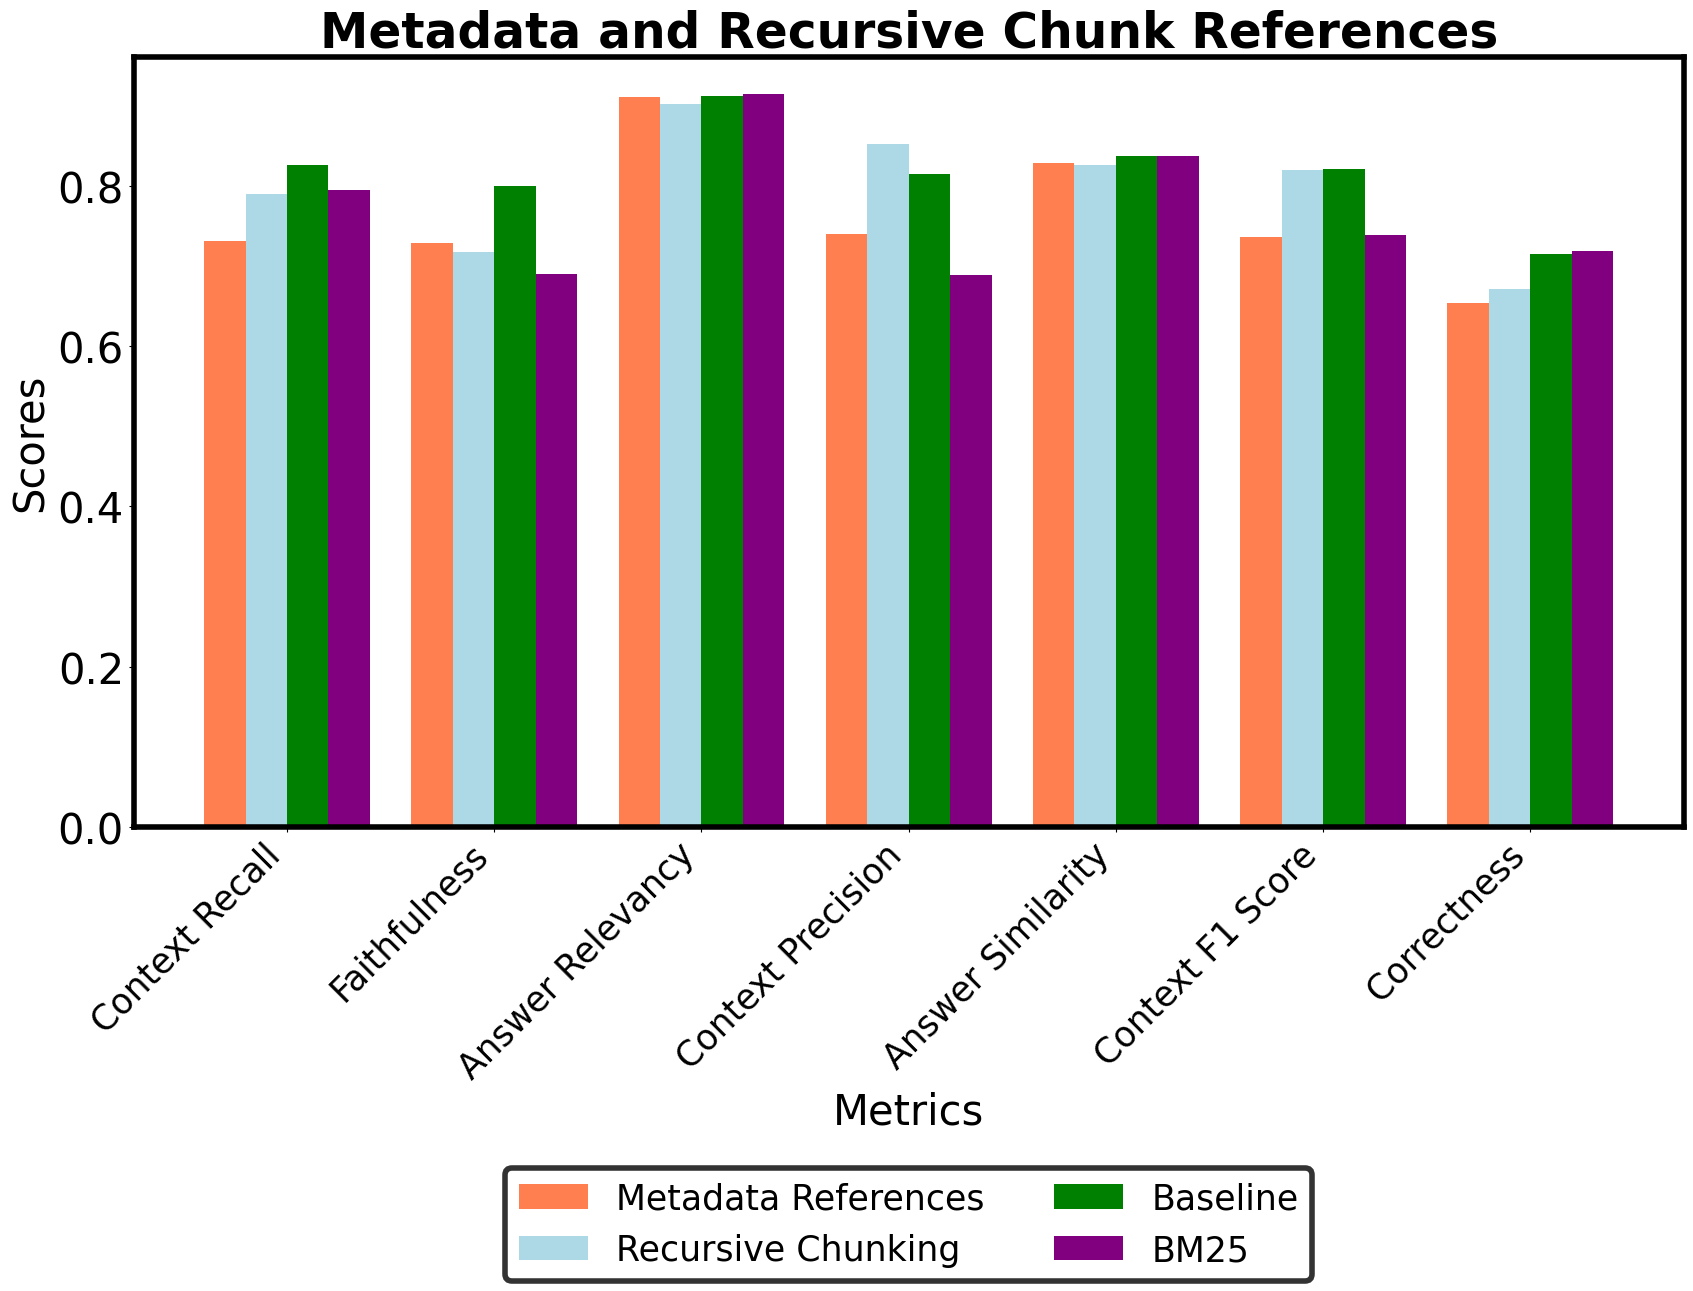

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the 'BM25' metrics
bm25_metrics = [
    0.794846, 0.690142, 0.914674, 0.689090, 0.836503, 0.738199, 71.89781 / 100
]

# Data for plotting
labels = [
    'Context Recall', 'Faithfulness', 'Answer Relevancy',
    'Context Precision', 'Answer Similarity', 'Context F1 Score',
    'Correctness'
]

metadata_metrics = [
    0.731317, 0.728841, 0.910567, 0.739960, 0.828284, 0.735613, 65.328467 / 100
]

recursive_metrics = [
    0.789157, 0.717205, 0.901623, 0.851740, 0.826449, 0.819255, 67.153285 / 100
]

baseline_metrics = [
    0.826238, 0.799011, 0.911948, 0.814926, 0.837374, 0.820543, 71.532847 / 100
]

x = np.arange(len(labels))  # label locations
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(20, 10))
bars1 = ax.bar(x - 1.5 * width, metadata_metrics, width, label='Metadata References', color='coral')
bars2 = ax.bar(x - 0.5 * width, recursive_metrics, width, label='Recursive Chunking', color='lightblue')
bars3 = ax.bar(x + 0.5 * width, baseline_metrics, width, label='Baseline', color='green')
bars4 = ax.bar(x + 1.5 * width, bm25_metrics, width, label='BM25', color='purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics', fontsize=30)
ax.set_ylabel('Scores', fontsize=30)
ax.set_title('Metadata and Recursive Chunk References', fontsize=35, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=25)
ax.tick_params(axis='y', labelsize=30)

# Add legend with a border and increased font size, positioned below the plot
legend = ax.legend(fontsize=25, loc='upper center', bbox_to_anchor=(0.5, -0.42), ncol=2)

# Customize the legend border
legend.get_frame().set_linewidth(4)
# Customize the legend border
legend.get_frame().set_linewidth(4)
legend.get_frame().set_edgecolor('black')

# Customize the border of the plot
# Thicker border around each plot
for spine in ax.spines.values():
    spine.set_linewidth(4)

# Display the bar chart
plt.show()


In [7]:
metrics_df_k3 = compute_metrics('hybrid_search2_k3.csv')

metrics_df_k5 = compute_metrics('hybrid_search2_k5.csv')

metrics_df_k7 = compute_metrics('hybrid_search2_k7.csv')

metrics_df_k10 = compute_metrics('hybrid_search2_k10.csv')

metrics_df_adaptive_3class = compute_metrics('adaptive_k_ft_classifier_3.csv')
metrics_df_adaptive_2class = compute_metrics('adaptive_k_ft_classifier_2.csv')

Metrics saved to: hybrid_search2_k3_final_results.csv
Metrics saved to: hybrid_search2_k5_final_results.csv
Metrics saved to: hybrid_search2_k7_final_results.csv
Metrics saved to: hybrid_search2_k10_final_results.csv
Metrics saved to: adaptive_k_ft_classifier_3_final_results.csv
Metrics saved to: adaptive_k_ft_classifier_2_final_results.csv


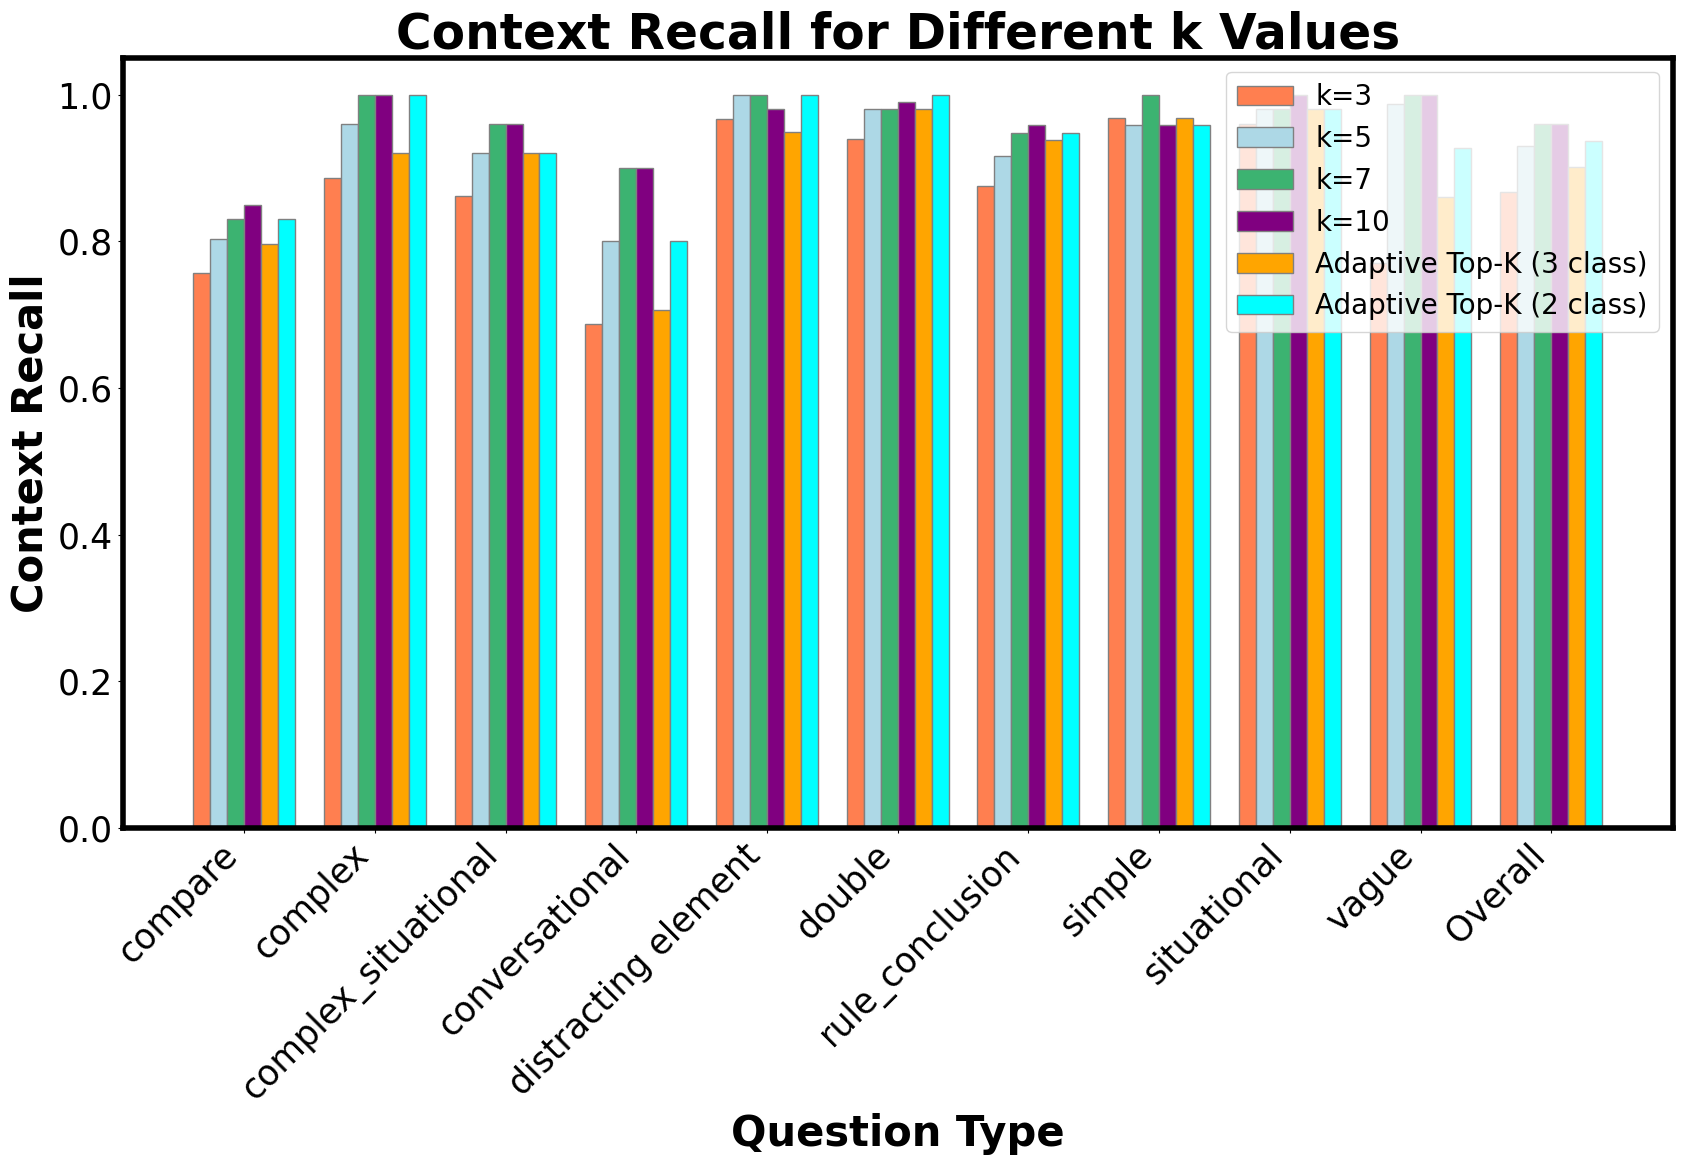

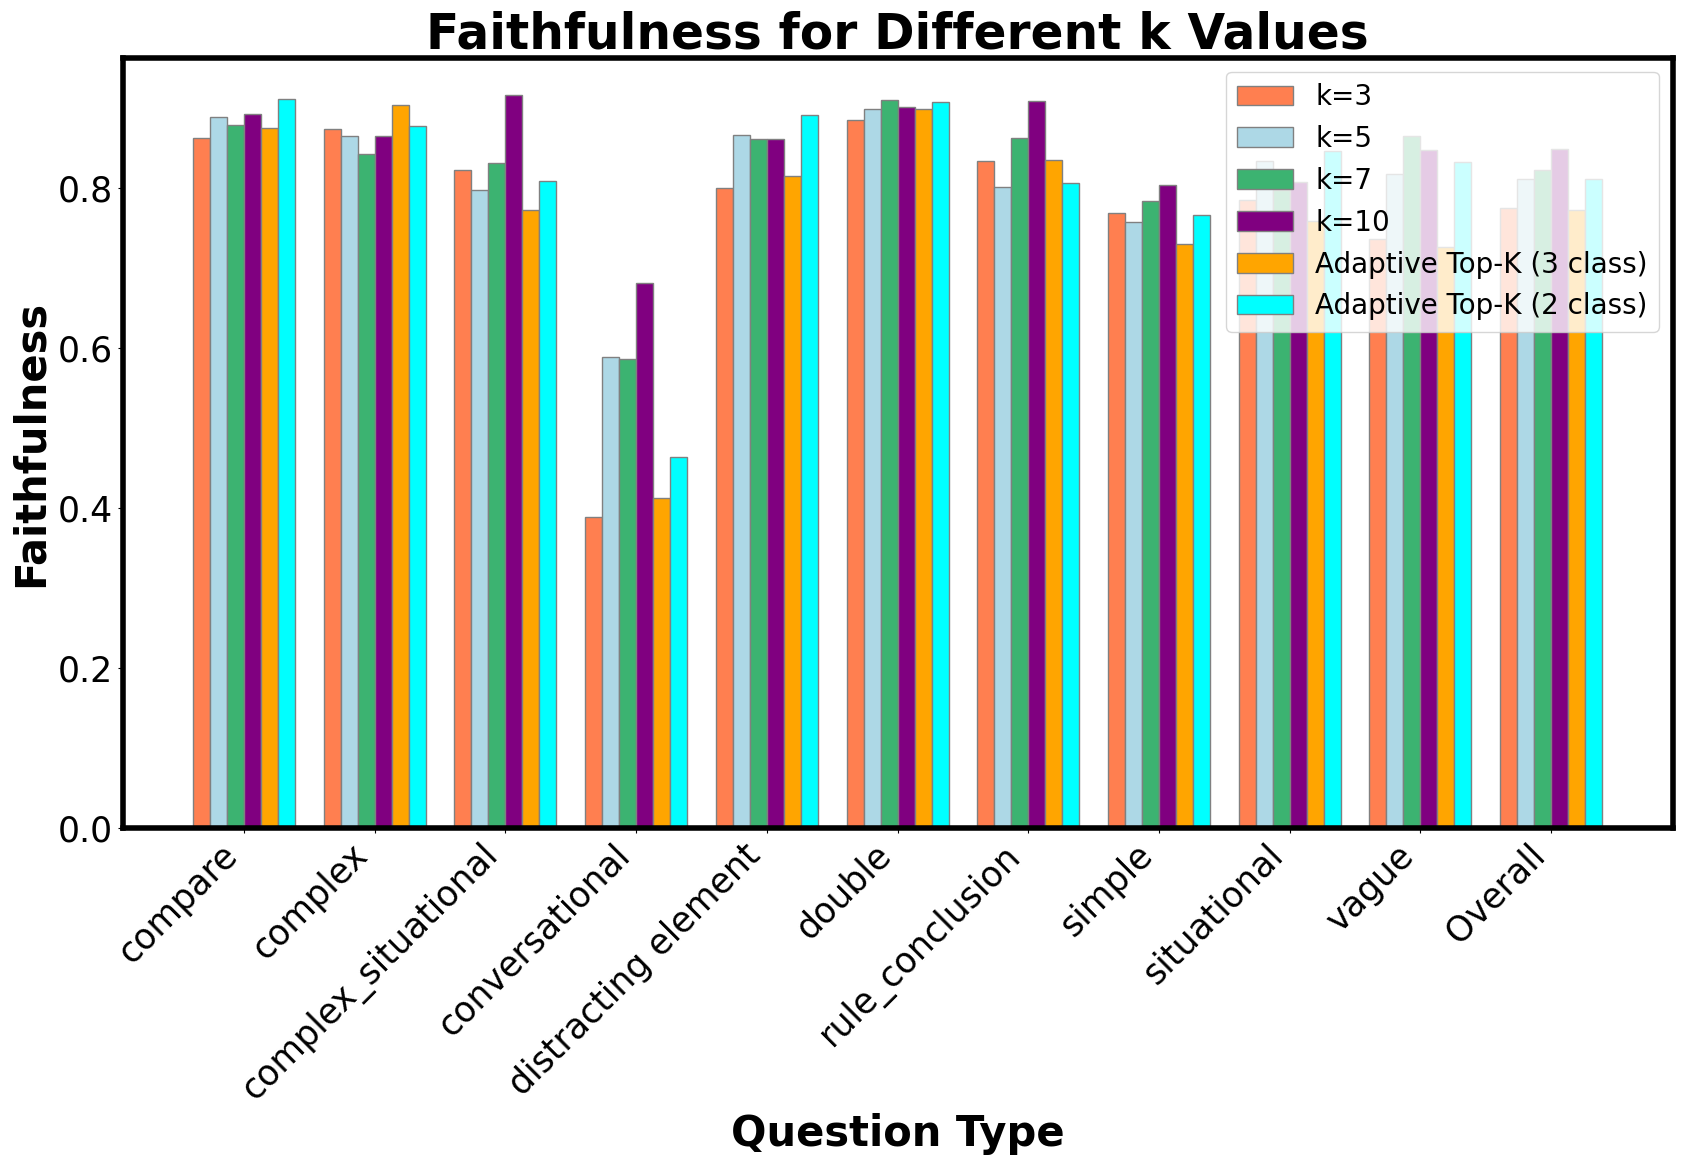

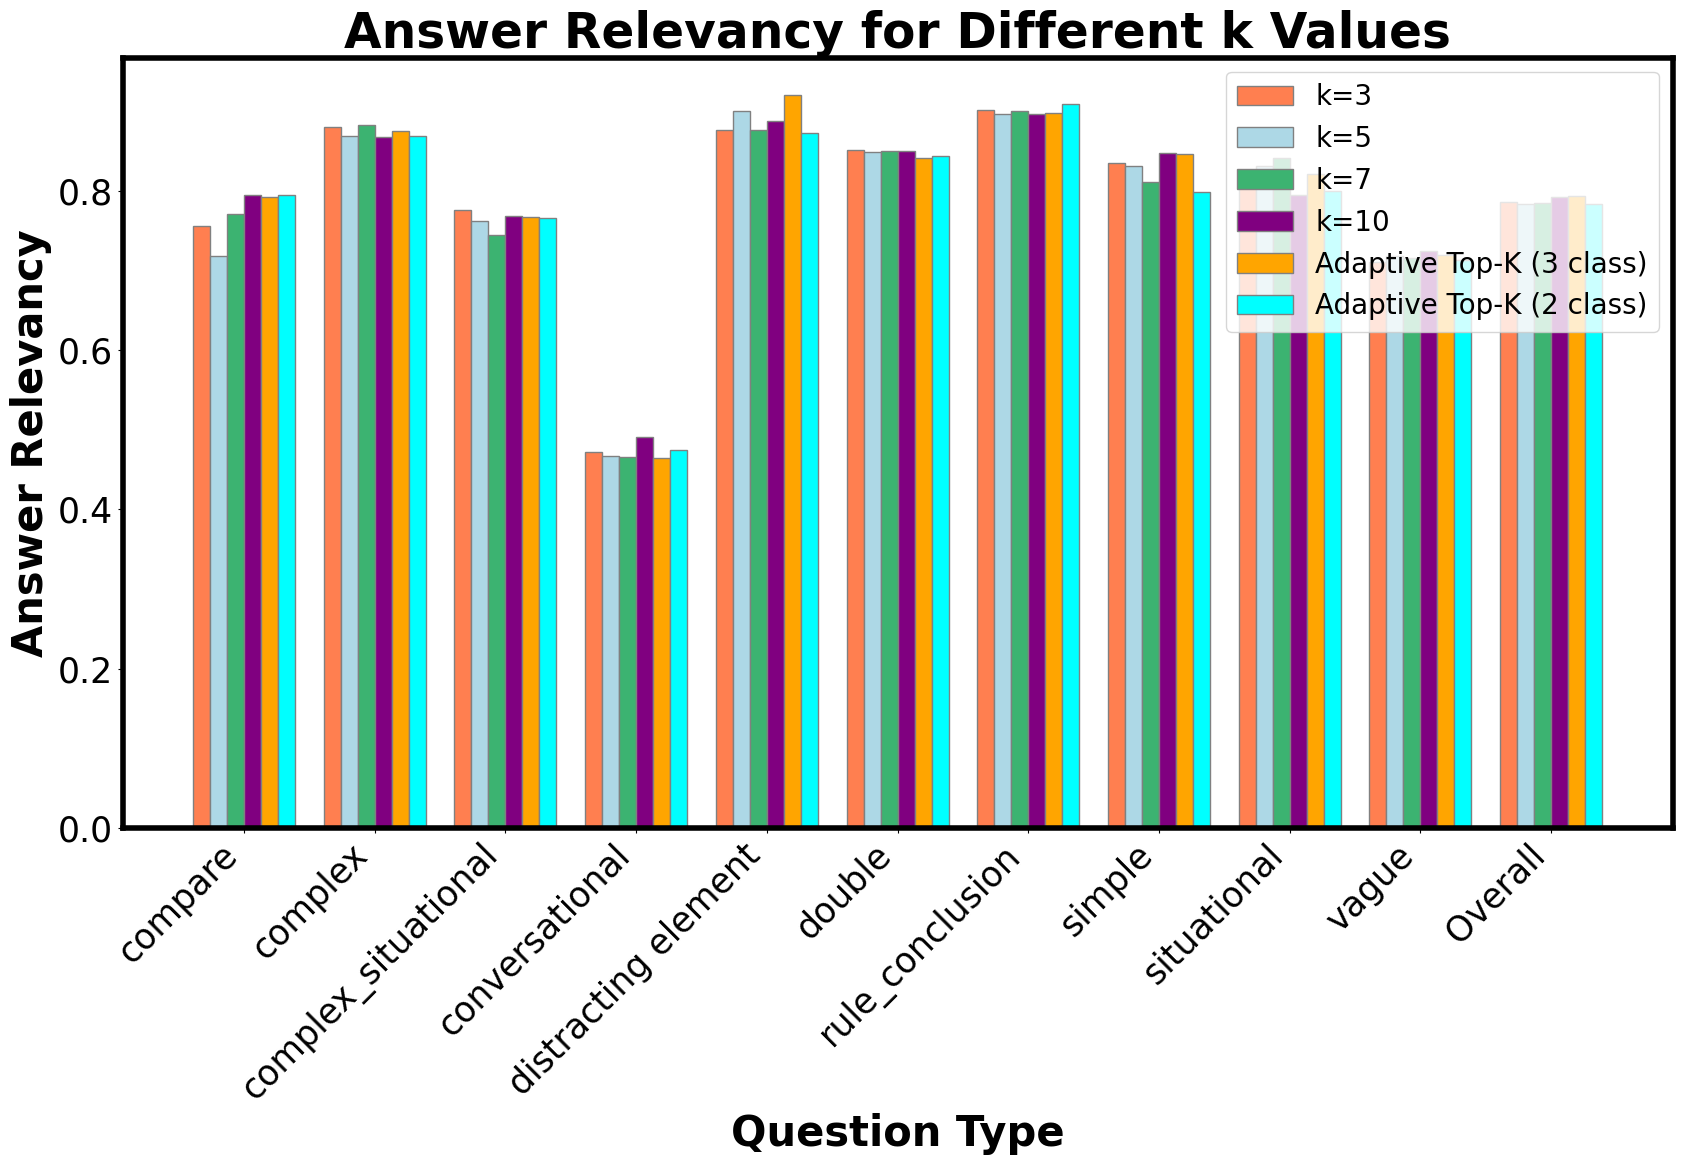

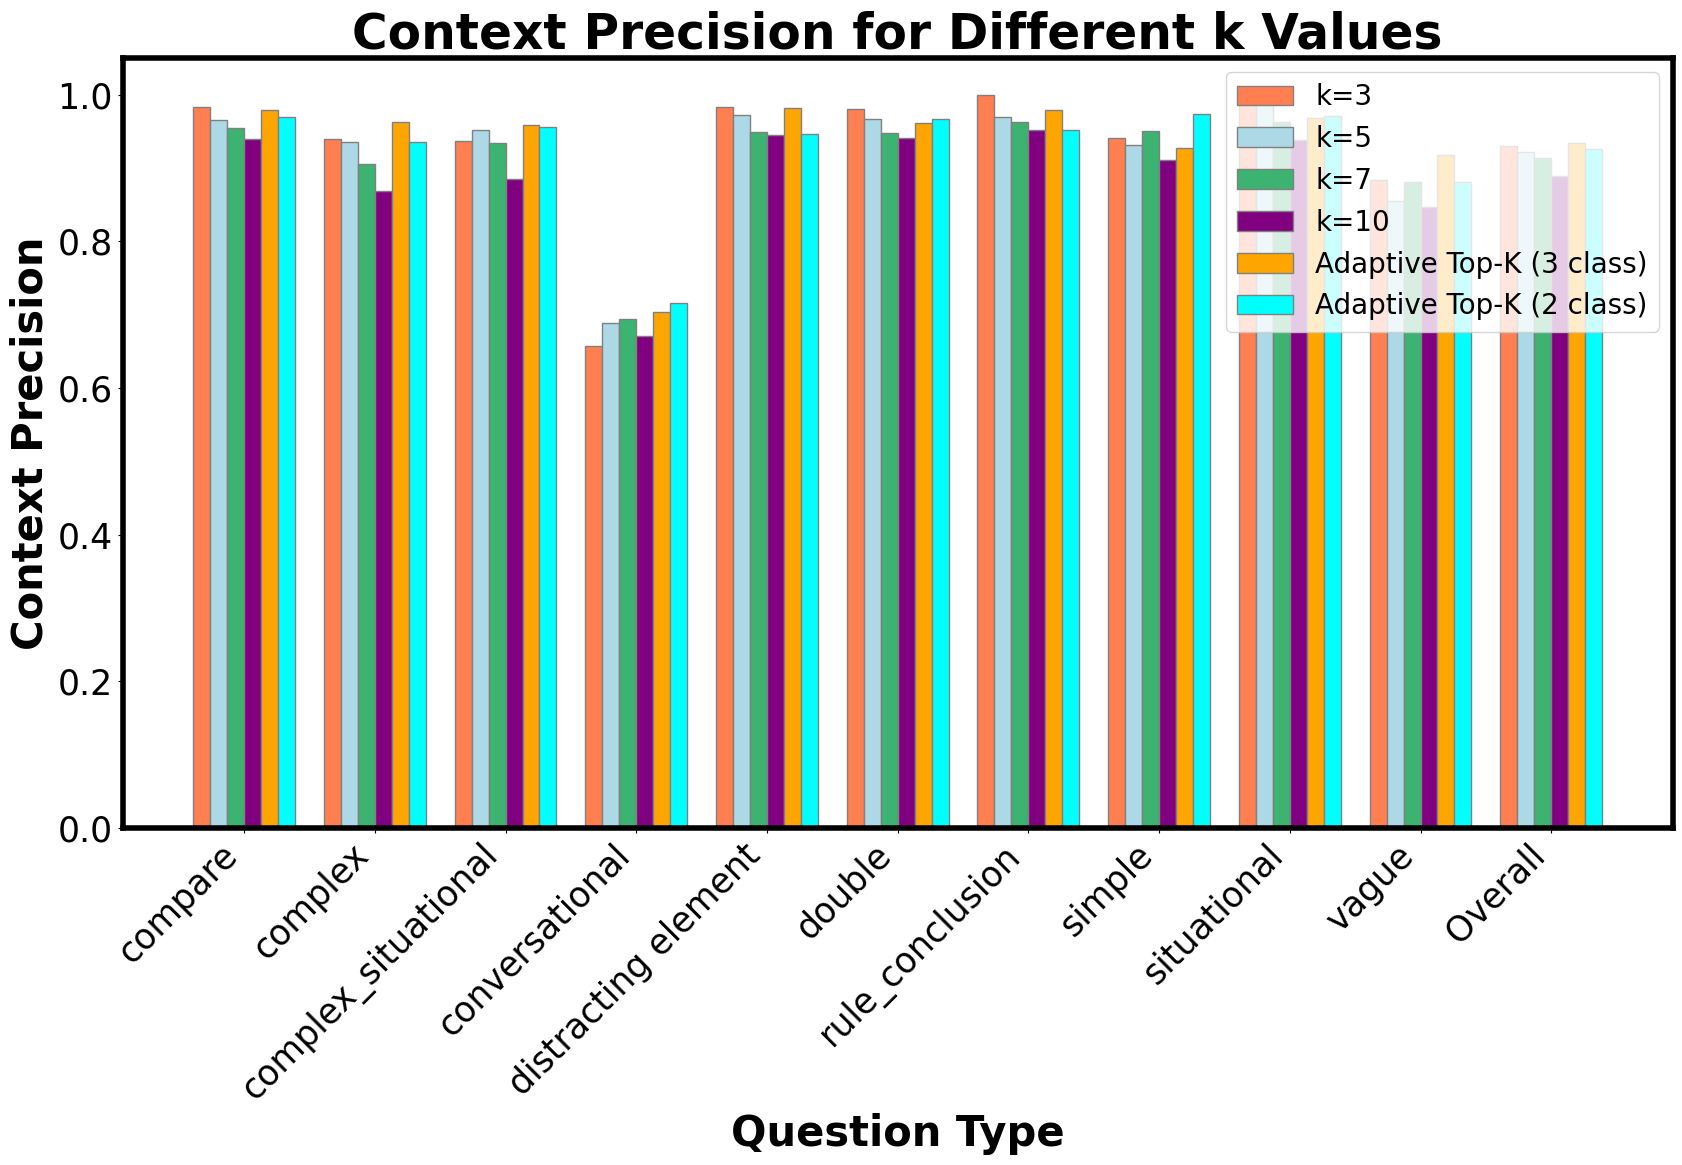

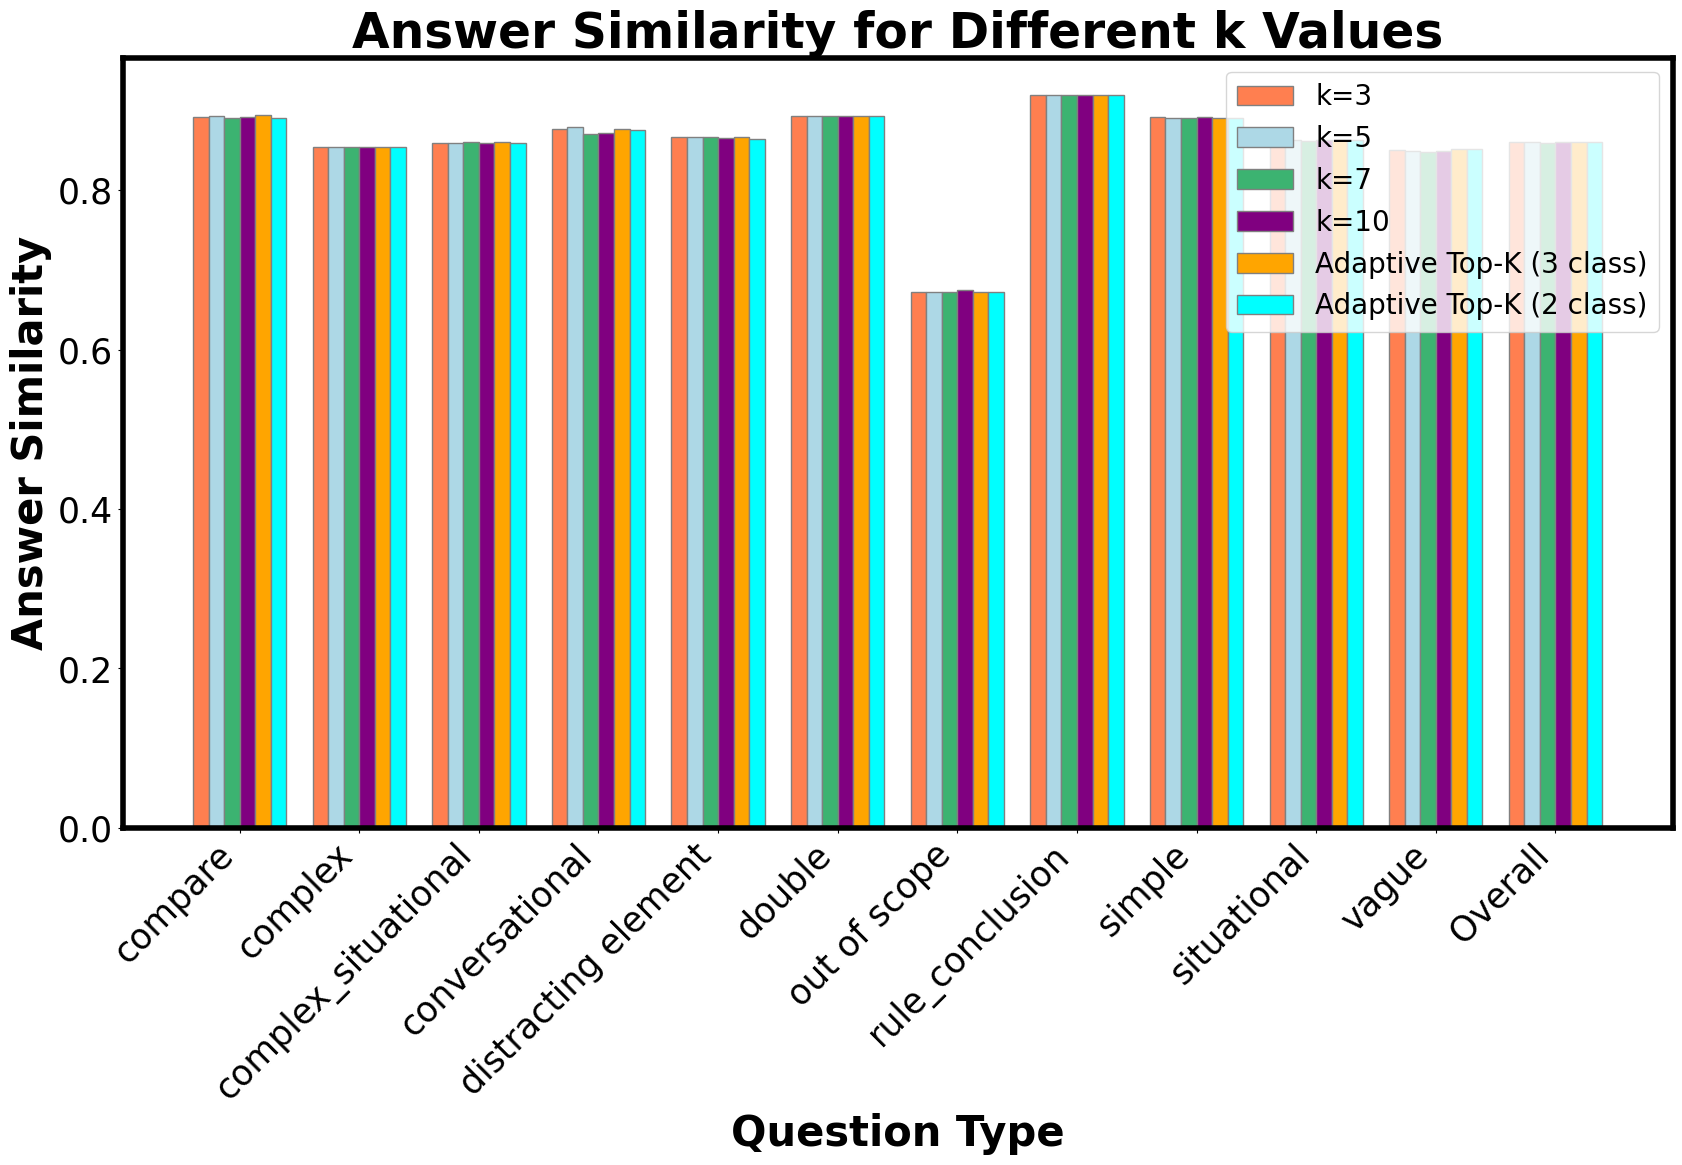

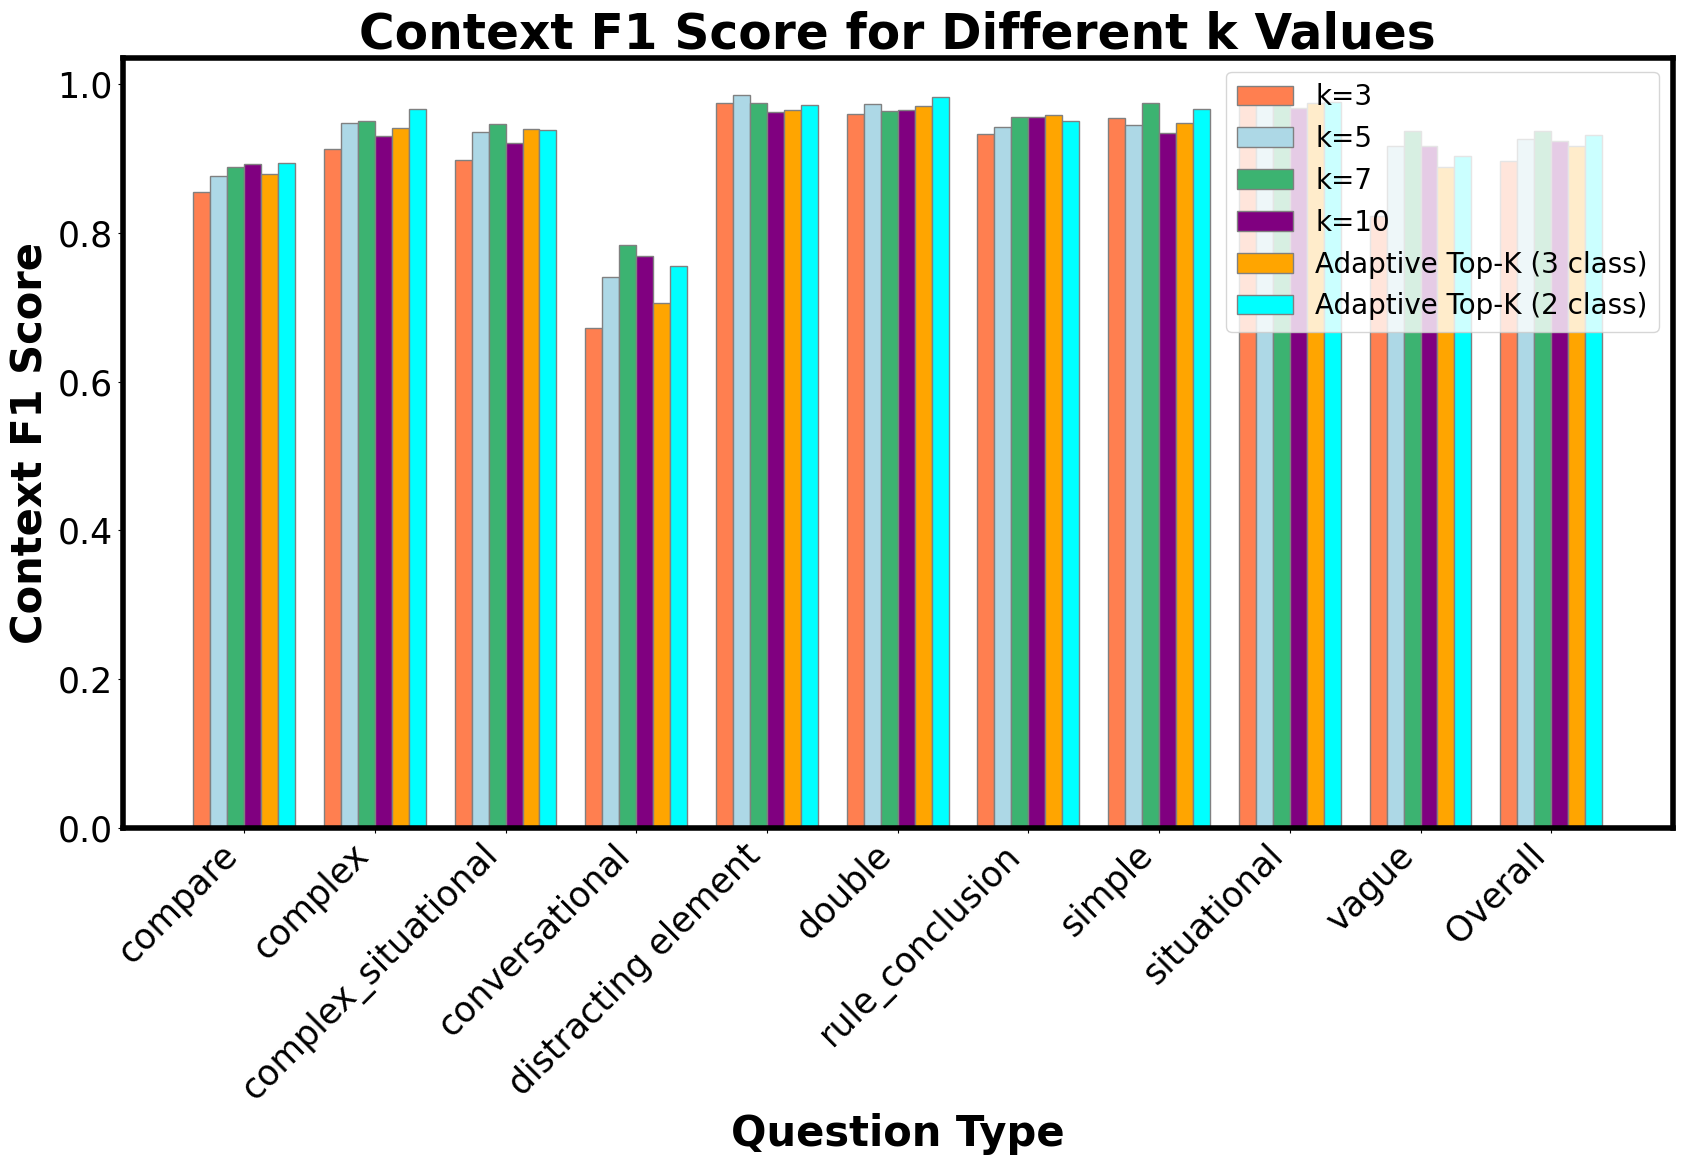

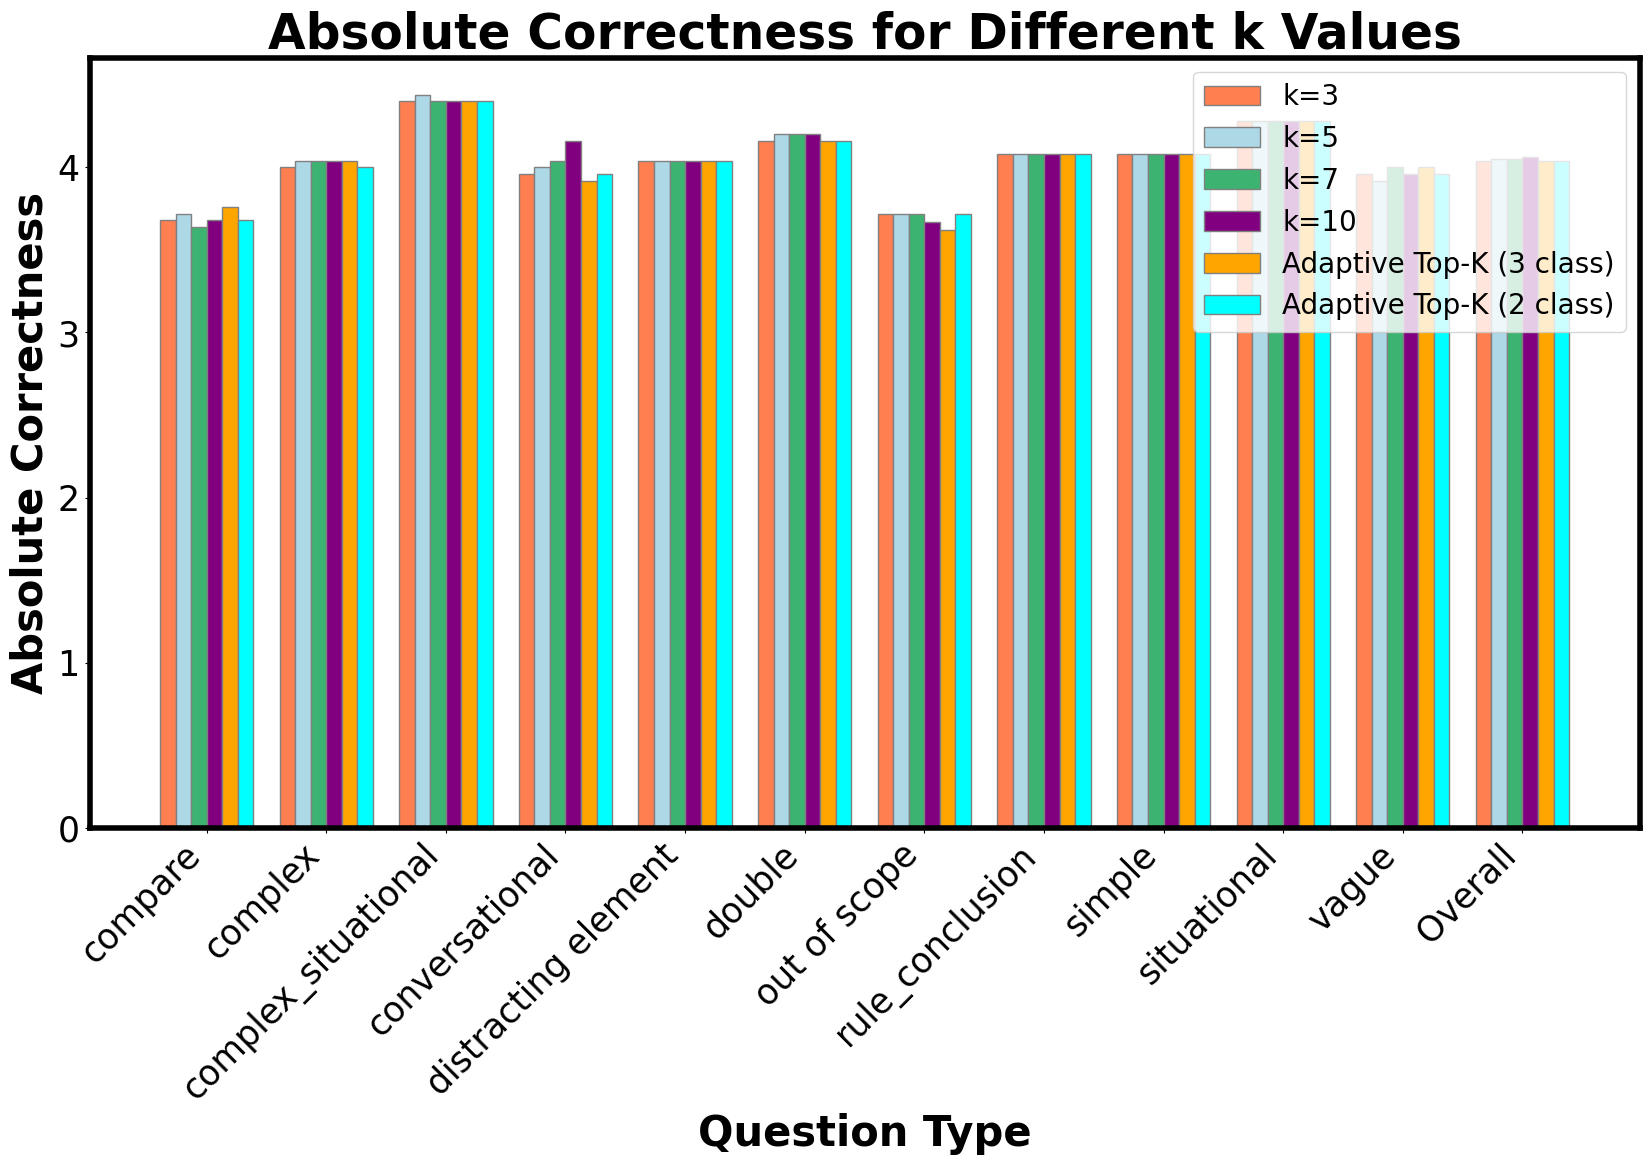

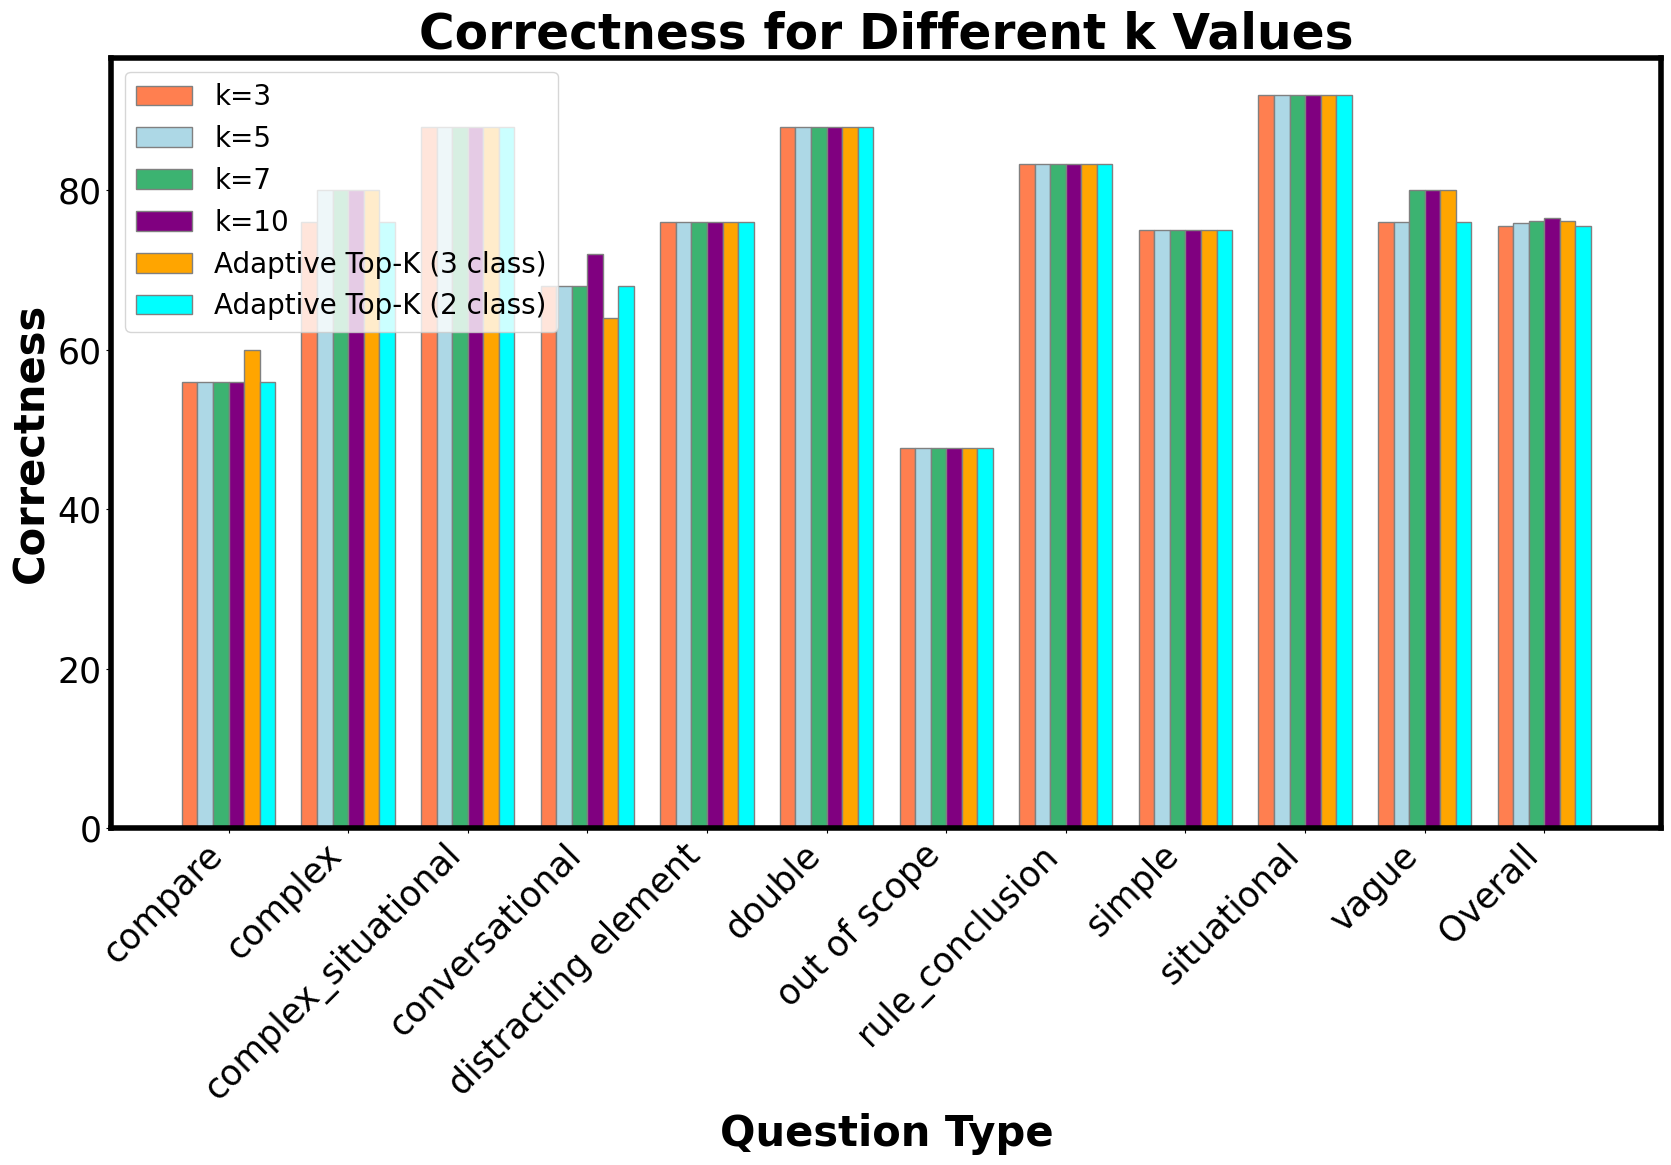

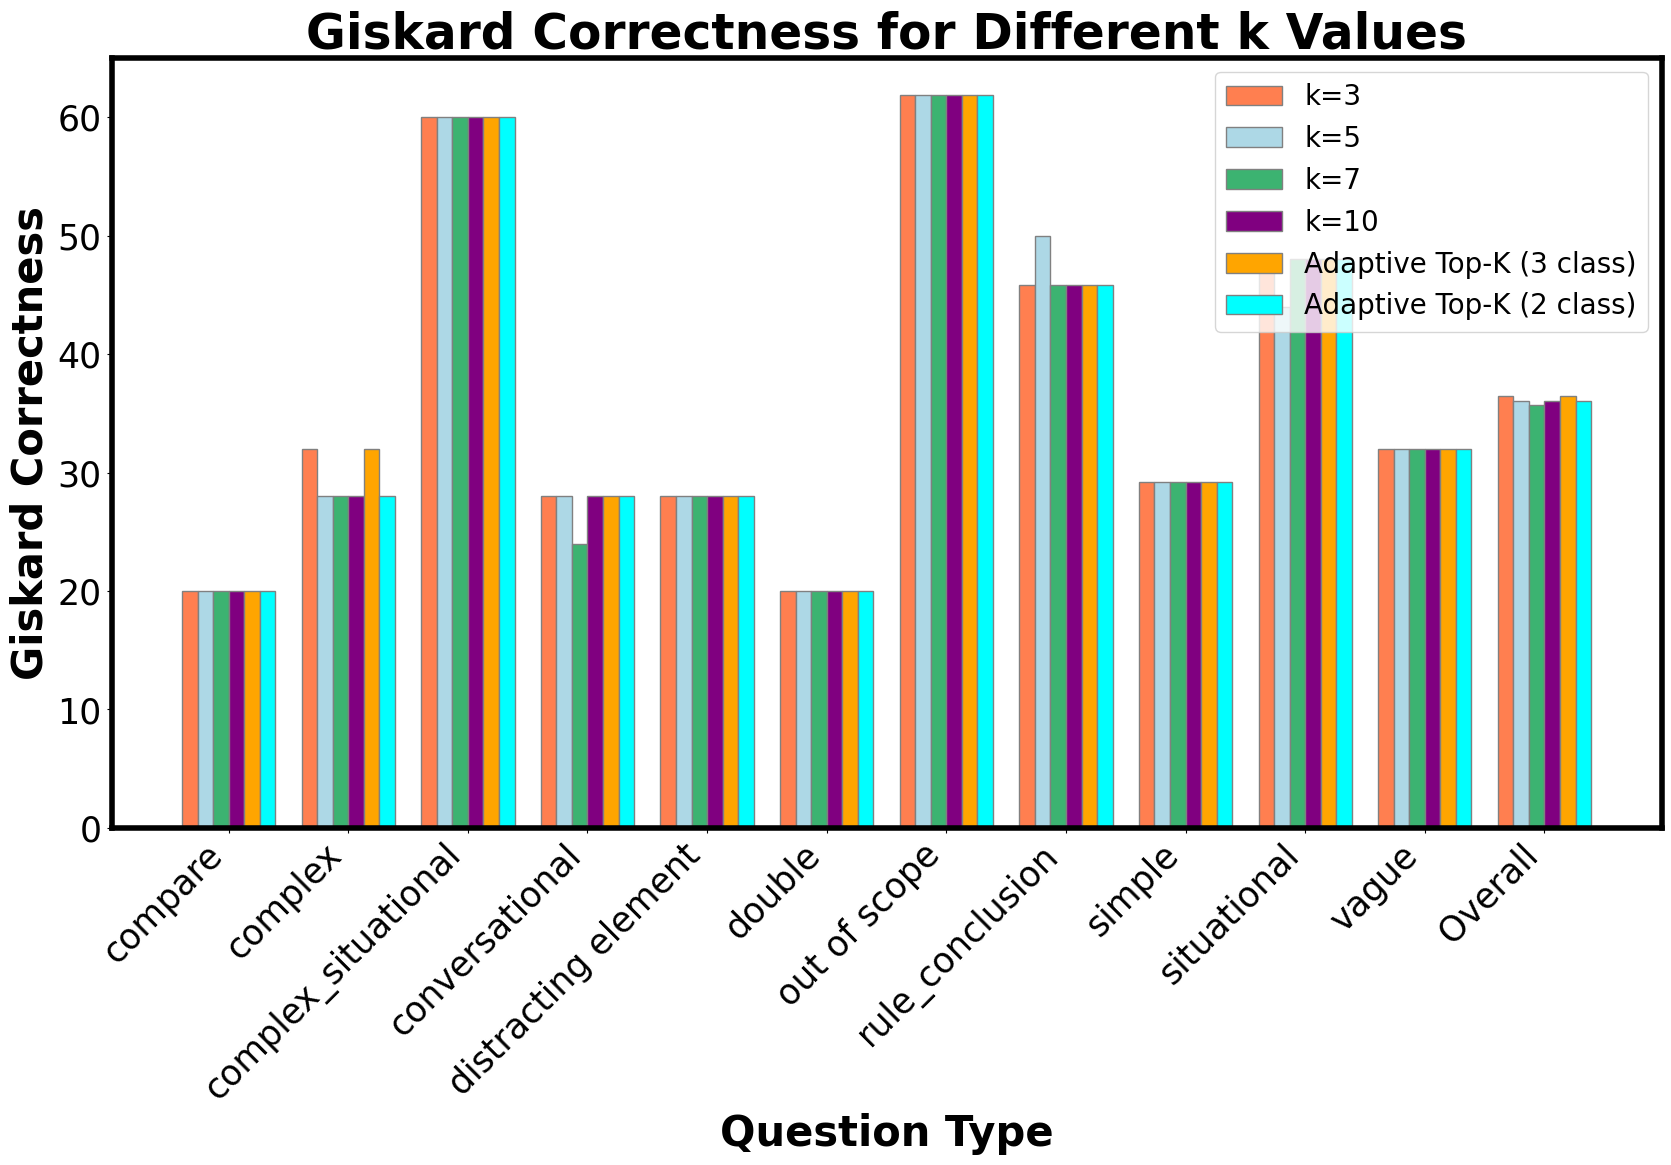

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

metrics_labels = {
    'RAGAS Context Recall': 'Context Recall',
    'RAGAS Faithfulness': 'Faithfulness',
    'RAGAS Answer Relevancy': 'Answer Relevancy',
    'RAGAS Context Precision': 'Context Precision',
    'answer similarity': 'Answer Similarity',
    'RAGAS Context F1 Score': 'Context F1 Score',
    'correctness_method2': 'Absolute Correctness',
    'correctness_method2_mapped': 'Correctness',
    'correctness': 'Giskard Correctness'
}

metrics_to_plot = [col for col in metrics_df_k3.columns if col not in ['question_type']]

for metric in metrics_to_plot:
    combined_df_metric = pd.DataFrame({
        'question_type': metrics_df_k3['question_type'],
        f'{metric}_k3': metrics_df_k3[metric],
        f'{metric}_k5': metrics_df_k5[metric],
        f'{metric}_k7': metrics_df_k7[metric],
        f'{metric}_k10': metrics_df_k10[metric],
        f'{metric}_adaptive_3class': metrics_df_adaptive_3class[metric],
        f'{metric}_adaptive_2class': metrics_df_adaptive_2class[metric]
    })

    combined_df_metric = combined_df_metric.dropna(subset=[
        f'{metric}_k3', 
        f'{metric}_k5', 
        f'{metric}_k7', 
        f'{metric}_k10', 
        f'{metric}_adaptive_3class', 
        f'{metric}_adaptive_2class'
    ], how='all')

    bar_width = 0.13

    r1 = range(len(combined_df_metric))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    r6 = [x + bar_width for x in r5]

    plt.figure(figsize=(20, 10))  #

    plt.bar(r1, combined_df_metric[f'{metric}_k3'], color='coral', width=bar_width, edgecolor='grey', label='k=3')
    plt.bar(r2, combined_df_metric[f'{metric}_k5'], color='lightblue', width=bar_width, edgecolor='grey', label='k=5')
    plt.bar(r3, combined_df_metric[f'{metric}_k7'], color='mediumseagreen', width=bar_width, edgecolor='grey', label='k=7')
    plt.bar(r4, combined_df_metric[f'{metric}_k10'], color='purple', width=bar_width, edgecolor='grey', label='k=10')
    plt.bar(r5, combined_df_metric[f'{metric}_adaptive_3class'], color='orange', width=bar_width, edgecolor='grey', label='Adaptive Top-K (3 class)')
    plt.bar(r6, combined_df_metric[f'{metric}_adaptive_2class'], color='cyan', width=bar_width, edgecolor='grey', label='Adaptive Top-K (2 class)')

    plt.xlabel('Question Type', fontsize=30, fontweight='bold')  # x label fontsize 30
    plt.ylabel(metrics_labels.get(metric, metric.replace('RAGAS ', '')), fontsize=30, fontweight='bold')  # y label fontsize 30
    plt.title(f'{metrics_labels.get(metric, metric.replace("RAGAS ", ""))} for Different k Values', fontsize=35, fontweight='bold')  # title fontsize 35
    plt.xticks([r + bar_width*2.5 for r in range(len(combined_df_metric))], combined_df_metric['question_type'], rotation=45, ha='right', fontsize=25)  # xticks fontsize 25
    plt.yticks(fontsize=25)  # yticks fontsize 25

    for spine in plt.gca().spines.values():
        spine.set_linewidth(4)

    # Show plot
    plt.legend(fontsize=20)
    plt.show()


In [8]:
import pandas as pd

# Assuming the metrics DataFrames are already defined
# metrics_df_k3, metrics_df_k5, metrics_df_k7, metrics_df_k10, metrics_df_adaptive_3class, metrics_df_adaptive_2class

# List of all the DataFrames and their corresponding labels
dfs = {
    'k3': metrics_df_k3,
    'k5': metrics_df_k5,
    'k7': metrics_df_k7,
    'k10': metrics_df_k10,
    'adaptive (3 class)': metrics_df_adaptive_3class,
    'adaptive (2 class)': metrics_df_adaptive_2class,
    'graph': graph_metrics_df
}

# List of metrics to aggregate
metrics_to_aggregate = [col for col in metrics_df_k3.columns if col not in ['question_type']]

# Dictionary to store aggregated results
aggregated_results = {metric: {} for metric in metrics_to_aggregate}

# Calculate the mean for each metric across all question types
for label, df in dfs.items():
    for metric in metrics_to_aggregate:
        aggregated_results[metric][label] = df[metric].mean()

# Convert the aggregated results into a DataFrame
aggregated_df = pd.DataFrame(aggregated_results)

# Transpose the DataFrame to have the metrics as columns and the labels as rows
aggregated_df = aggregated_df.transpose()

# Update the row names
row_names_map = {
    'RAGAS Context Recall': 'Context Recall',
    'RAGAS Faithfulness': 'Faithfulness',
    'RAGAS Answer Relevancy': 'Answer Relevancy',
    'RAGAS Context Precision': 'Context Precision',
    'answer similarity': 'Answer Embedding Similarity',
    'RAGAS Context F1 Score': 'Context F1 Score',
    'correctness_method2': 'Absolute Correctness (1-5)',
    'correctness_method2_mapped': 'Correctness (Threshold=4.0)',
    'correctness': 'Giskard Correctness'
}

# Rename the rows in the DataFrame
aggregated_df.rename(index=row_names_map, inplace=True)

# Divide the values of "Correctness (Threshold=4.0)" and "Giskard Correctness" by 100
aggregated_df.loc['Correctness (Threshold=4.0)'] /= 100
aggregated_df.loc['Giskard Correctness'] /= 100

# Print or display the aggregated DataFrame
aggregated_df


NameError: name 'metrics_df_k3' is not defined

In [23]:
!pip install openpyxl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [24]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font

# Assuming aggregated_df is already defined
# aggregated_df = ...

# Export aggregated_df to Excel with bold formatting for the largest value in each row
with pd.ExcelWriter('aggregated_results.xlsx', engine='openpyxl') as writer:
    aggregated_df.to_excel(writer, sheet_name='Results')
    worksheet = writer.sheets['Results']
    
    # Iterate over the DataFrame to find and format the largest value in each row
    for row in range(2, aggregated_df.shape[0] + 2):  # Data starts from row 2 in Excel
        row_values = [cell.value for cell in worksheet[row]][1:]  # Get all values except the metric name
        max_value = max(row_values)  # Find the maximum value in the row
        for col in range(2, aggregated_df.shape[1] + 2):  # Data starts from column 2 in Excel
            cell = worksheet.cell(row=row, column=col)
            if cell.value == max_value:
                cell.font = Font(bold=True)  # Apply bold font to the cell

print("Exported aggregated results to Excel with formatting.")


Exported aggregated results to Excel with formatting.


In [28]:
import pandas as pd

# List of all the DataFrames and their corresponding labels
dfs = {
    'k3': metrics_df_k3,
    'k5': metrics_df_k5,
    'k7': metrics_df_k7,
    'k10': metrics_df_k10,
    'adaptive (3 class)': metrics_df_adaptive_3class,
    'adaptive (2 class)': metrics_df_adaptive_2class
}

# List of metrics to aggregate
metrics_to_aggregate = [col for col in metrics_df_k3.columns if col not in ['question_type']]

# Get unique question types
question_types = metrics_df_k3['question_type'].unique()

# Dictionary to store DataFrames for each question type
question_type_dfs = {q_type: pd.DataFrame(columns=['Metric'] + list(dfs.keys())) for q_type in question_types}

# Calculate the mean for each metric across all question types and populate the DataFrames
for q_type in question_types:
    rows = []
    for metric in metrics_to_aggregate:
        row = {'Metric': metric}
        for label, df in dfs.items():
            df_filtered = df[df['question_type'] == q_type]
            row[label] = df_filtered[metric].mean()
        rows.append(row)
    question_type_dfs[q_type] = pd.concat([question_type_dfs[q_type], pd.DataFrame(rows)], ignore_index=True)

# Update row names and adjust values for specific metrics
row_names_map = {
    'RAGAS Context Recall': 'Context Recall',
    'RAGAS Faithfulness': 'Faithfulness',
    'RAGAS Answer Relevancy': 'Answer Relevancy',
    'RAGAS Context Precision': 'Context Precision',
    'answer similarity': 'Answer Embedding Similarity',
    'RAGAS Context F1 Score': 'Context F1 Score',
    'correctness_method2': 'Absolute Correctness (1-5)',
    'correctness_method2_mapped': 'Correctness (Threshold=4.0)',
    'correctness': 'Giskard Correctness'
}

for q_type, df in question_type_dfs.items():
    df['Metric'] = df['Metric'].map(row_names_map).fillna(df['Metric'])
    if 'Correctness (Threshold=4.0)' in df['Metric'].values:
        df.loc[df['Metric'] == 'Correctness (Threshold=4.0)', dfs.keys()] /= 100
    if 'Giskard Correctness' in df['Metric'].values:
        df.loc[df['Metric'] == 'Giskard Correctness', dfs.keys()] /= 100

# Print or display the aggregated DataFrames
for q_type, df in question_type_dfs.items():
    print(f"\nAggregated results for question type: {q_type}\n")
    print(df)



Aggregated results for question type: compare

                        Metric        k3        k5        k7       k10  \
0               Context Recall  0.756667  0.803333  0.830000  0.850000   
1                 Faithfulness  0.862128  0.887885  0.878549  0.891429   
2             Answer Relevancy  0.755762  0.717563  0.771229  0.794698   
3            Context Precision  0.983333  0.964833  0.955146  0.940088   
4  Answer Embedding Similarity  0.891244  0.892438  0.890750  0.891743   
5             Context F1 Score  0.855236  0.876708  0.888186  0.892777   
6   Absolute Correctness (1-5)  3.680000  3.720000  3.640000  3.680000   
7  Correctness (Threshold=4.0)  0.560000  0.560000  0.560000  0.560000   
8          Giskard Correctness  0.200000  0.200000  0.200000  0.200000   

   adaptive (3 class)  adaptive (2 class)  
0            0.796667            0.830000  
1            0.874911            0.910867  
2            0.791991            0.794724  
3            0.978937            0.

/var/folders/vh/rp6l70s568gc8_g2c6pn2lnc0000gn/T/ipykernel_1769/3356326658.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  question_type_dfs[q_type] = pd.concat([question_type_dfs[q_type], pd.DataFrame(rows)], ignore_index=True)


In [31]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font

# Function to export DataFrame to Excel with bold and underline formatting
def export_to_excel_with_bolding_and_underlining(df, filename):
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='Results', index=False)
        worksheet = writer.sheets['Results']

        # Iterate over the DataFrame to find and format the largest and second largest value in each row
        for row in range(2, df.shape[0] + 2):  # Data starts from row 2 in Excel
            row_values = [cell.value for cell in worksheet[row]][1:]  # Get all values except the metric name
            # Filter only numeric values for max calculation
            numeric_row_values = [val for val in row_values if isinstance(val, (int, float))]
            if numeric_row_values:
                sorted_values = sorted(numeric_row_values, reverse=True)
                max_value = sorted_values[0]  # Find the maximum value in the row
                second_max_value = sorted_values[1] if len(sorted_values) > 1 else None  # Find the second largest value

                for col in range(2, df.shape[1] + 2):  # Data starts from column 2 in Excel
                    cell = worksheet.cell(row=row, column=col)
                    if cell.value == max_value:
                        cell.font = Font(bold=True)  # Apply bold font to the cell
                    elif cell.value == second_max_value:
                        cell.font = Font(underline='single')  # Apply underline to the cell

# Export each question type DataFrame to Excel
for q_type, df in question_type_dfs.items():
    filename = f'aggregated_results_{q_type}.xlsx'
    export_to_excel_with_bolding_and_underlining(df, filename)
    print(f"Exported aggregated results for question type '{q_type}' to '{filename}'")


Exported aggregated results for question type 'compare' to 'aggregated_results_compare.xlsx'
Exported aggregated results for question type 'complex' to 'aggregated_results_complex.xlsx'
Exported aggregated results for question type 'complex_situational' to 'aggregated_results_complex_situational.xlsx'
Exported aggregated results for question type 'conversational' to 'aggregated_results_conversational.xlsx'
Exported aggregated results for question type 'distracting element' to 'aggregated_results_distracting element.xlsx'
Exported aggregated results for question type 'double' to 'aggregated_results_double.xlsx'
Exported aggregated results for question type 'out of scope' to 'aggregated_results_out of scope.xlsx'
Exported aggregated results for question type 'rule_conclusion' to 'aggregated_results_rule_conclusion.xlsx'
Exported aggregated results for question type 'simple' to 'aggregated_results_simple.xlsx'
Exported aggregated results for question type 'situational' to 'aggregated_resu

: 

In [5]:
# Usage example
file_path = '../eval_results/semantic_results/semantic_3_90_results.csv'
metrics_df = compute_metrics(file_path)

metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.675333            0.705770   
1               complex              0.875000            0.830996   
2   complex_situational              0.768667            0.769930   
3        conversational              0.106667            0.124111   
4   distracting element              0.786667            0.839066   
5                double              0.780000            0.720392   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.888889            0.970753   
8                simple              0.823333            0.861948   
9           situational              0.820000            0.771435   
10                vague              0.626667            0.736171   
11              Overall              0.713777            0.732070   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.953361                 0.640000           0.881919   
1                 0.913407                 0.793333           0.836370   
2                 0.934171                 0.800000           0.841297   
3                 0.780090                 0.220000           0.886044   
4                 0.962947                 0.753333           0.850065   
5                 0.933340                 0.770000           0.880644   
6                      NaN                      NaN           0.472944   
7                 0.961402                 0.843750           0.916101   
8                 0.930516                 0.756667           0.893762   
9                 0.940349                 0.736667           0.855520   
10                0.848880                 0.500000           0.779421   
11                0.915663                 0.680723           0.826409   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.657192             3.840000                   72.000000   
1                 0.832168             4.200000                   84.000000   
2                 0.784020             4.240000                   80.000000   
3                 0.143673             4.160000                   84.000000   
4                 0.769639             4.040000                   72.000000   
5                 0.774968             3.920000                   64.000000   
6                      NaN             2.720000                   28.000000   
7                 0.865731             3.708333                   70.833333   
8                 0.788594             3.880000                   64.000000   
9                 0.776103             4.080000                   68.000000   
10                0.556213             3.200000                   48.000000   
11                0.696858             3.817518                   66.788321   

    correctness  
0     60.000000  
1     56.000000  
2     52.000000  
3     60.000000  
4     56.000000  
5     44.000000  
6     20.000000  
7     58.333333  
8     56.000000  
9     48.000000  
10    48.000000  
11    50.729927

In [8]:
# Usage example
file_path = '../eval_results/semantic_results/semantic_5_90_results.csv'
metrics_df = compute_metrics(file_path)

metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.793333            0.781500   
1               complex              0.910000            0.806270   
2   complex_situational              0.816667            0.737370   
3        conversational              0.213333            0.267865   
4   distracting element              0.864000            0.828759   
5                double              0.776667            0.753872   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.937500            0.871836   
8                simple              0.774000            0.811984   
9           situational              0.900000            0.814039   
10                vague              0.600000            0.773363   
11              Overall              0.757831            0.744058   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.952978                 0.713333           0.878666   
1                 0.959678                 0.850000           0.839863   
2                 0.899528                 0.720000           0.841652   
3                 0.779510                 0.426667           0.887202   
4                 0.962621                 0.730000           0.859034   
5                 0.935067                 0.770000           0.886555   
6                      NaN                      NaN           0.479659   
7                 0.962710                 0.756944           0.899627   
8                 0.930275                 0.733333           0.885209   
9                 0.942947                 0.690000           0.866006   
10                0.879366                 0.606667           0.807127   
11                0.920298                 0.699465           0.829801   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.751209             3.720000                   68.000000   
1                 0.878977             4.280000                   84.000000   
2                 0.765293             4.280000                   80.000000   
3                 0.284444             4.160000                   76.000000   
4                 0.791368             4.000000                   72.000000   
5                 0.773319             3.920000                   72.000000   
6                      NaN             2.720000                   28.000000   
7                 0.837602             3.750000                   62.500000   
8                 0.753118             3.840000                   60.000000   
9                 0.781132             4.160000                   72.000000   
10                0.603315             3.560000                   48.000000   
11                0.727479             3.854015                   65.693431   

    correctness  
0     64.000000  
1     56.000000  
2     64.000000  
3     60.000000  
4     48.000000  
5     52.000000  
6     20.000000  
7     37.500000  
8     52.000000  
9     56.000000  
10    36.000000  
11    49.635036

In [10]:
# Usage example
file_path = '../eval_results/semantic_results/semantic_10_90_results.csv'
metrics_df = compute_metrics(file_path)

metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.763333            0.745681   
1               complex              0.820000            0.909007   
2   complex_situational              0.904000            0.705024   
3        conversational              0.420000            0.409351   
4   distracting element              0.900000            0.829582   
5                double              0.840000            0.803525   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.809028            0.942621   
8                simple              0.813333            0.845230   
9           situational              0.890000            0.765740   
10                vague              0.573333            0.740904   
11              Overall              0.773159            0.768972   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.954977                 0.663333           0.877877   
1                 0.875620                 0.800000           0.836432   
2                 0.889629                 0.780000           0.832473   
3                 0.781986                 0.440000           0.898214   
4                 0.962034                 0.866667           0.862263   
5                 0.934165                 0.750000           0.884781   
6                      NaN                      NaN           0.467391   
7                 0.964481                 0.781250           0.904366   
8                 0.927121                 0.746667           0.894046   
9                 0.945558                 0.876667           0.860772   
10                0.880669                 0.583333           0.794566   
11                0.911412                 0.728581           0.828194   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.709829             3.880000                   68.000000   
1                 0.809877             4.120000                   84.000000   
2                 0.837435             4.120000                   80.000000   
3                 0.429767             4.360000                   88.000000   
4                 0.883019             4.280000                   76.000000   
5                 0.792453             4.080000                   72.000000   
6                      NaN             2.760000                   36.000000   
7                 0.794896             3.708333                   79.166667   
8                 0.778575             3.960000                   64.000000   
9                 0.883283             4.280000                   84.000000   
10                0.578290             3.400000                   52.000000   
11                0.750209             3.905109                   71.167883   

    correctness  
0     56.000000  
1     48.000000  
2     64.000000  
3     72.000000  
4     72.000000  
5     48.000000  
6     20.000000  
7     41.666667  
8     64.000000  
9     60.000000  
10    52.000000  
11    54.379562

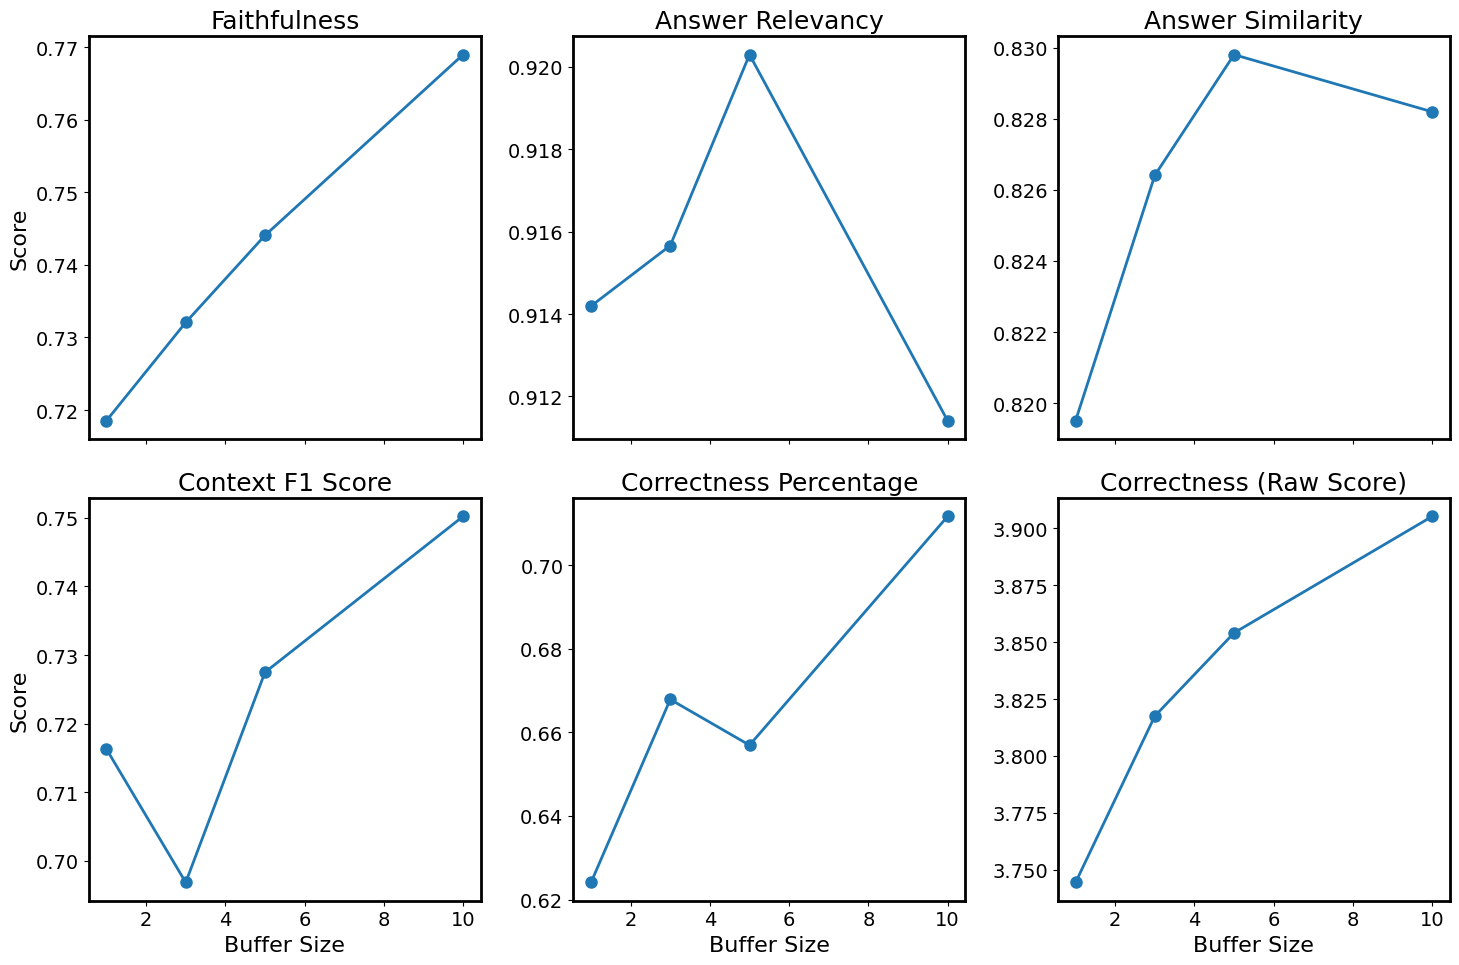

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Data
buffer_sizes = [1, 3, 5, 10]
faithfulness = [0.718541, 0.732070, 0.744058, 0.768972]
answer_relevancy = [0.914194, 0.915663, 0.920298, 0.911412]
answer_similarity = [0.819511, 0.826409, 0.829801, 0.828194]
context_f1 = [0.716290, 0.696858, 0.727479, 0.750209]
correctness = [3.744526, 3.817518, 3.854015, 3.905109]
correctness_percentage = np.array([62.408759, 66.788321, 65.693431, 71.167883]) / 100

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

# Adjust font sizes and line widths
plt.rcParams.update({
    'font.size': 18, 
    'axes.labelsize': 18, 
    'axes.titlesize': 18, 
    'xtick.labelsize': 18, 
    'ytick.labelsize': 18, 
    'lines.linewidth': 2, 
    'lines.markersize': 8
})

# Thicker border around each plot
for ax in axes.flatten():
    for spine in ax.spines.values():
        spine.set_linewidth(2)

# Faithfulness
axes[0, 0].plot(buffer_sizes, faithfulness, marker='o')
axes[0, 0].set_title('Faithfulness')
axes[0, 0].set_ylabel('Score')

# Answer Relevancy
axes[0, 1].plot(buffer_sizes, answer_relevancy, marker='o')
axes[0, 1].set_title('Answer Relevancy')

# Answer Similarity
axes[0, 2].plot(buffer_sizes, answer_similarity, marker='o')
axes[0, 2].set_title('Answer Similarity')

# Context F1 Score
axes[1, 0].plot(buffer_sizes, context_f1, marker='o')
axes[1, 0].set_title('Context F1 Score')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xlabel('Buffer Size')

# Correctness Percentage
axes[1, 1].plot(buffer_sizes, correctness_percentage, marker='o')
axes[1, 1].set_title('Correctness Percentage')
axes[1, 1].set_xlabel('Buffer Size')

# Correctness (Raw Score)
axes[1, 2].plot(buffer_sizes, correctness, marker='o')
axes[1, 2].set_title('Correctness (Raw Score)')
axes[1, 2].set_xlabel('Buffer Size')

# Adjust layout
fig.tight_layout()

plt.show()


In [4]:
# Usage example
file_path = 'rewriter_with_topics_n3.csv'
metrics_df = compute_metrics(file_path)

metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.870000            0.833215   
1               complex              0.990000            0.925037   
2   complex_situational              0.960000            0.808713   
3        conversational              0.500000            0.590947   
4   distracting element              0.960000            0.860974   
5                double              0.960000            0.873556   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.875000            0.943035   
8                simple              0.916667            0.917258   
9           situational              0.980000            0.867401   
10                vague              0.933333            0.844993   
11              Overall              0.894489            0.845838   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.897592                 0.691111           0.897716   
1                 0.962573                 0.824389           0.869368   
2                 0.931936                 0.818556           0.854517   
3                 0.654359                 0.604889           0.844365   
4                 0.974456                 0.837222           0.860968   
5                 0.893941                 0.748000           0.889554   
6                      NaN                      NaN           0.664717   
7                 0.957401                 0.837847           0.929835   
8                 0.978744                 0.839699           0.915830   
9                 0.936391                 0.822222           0.865457   
10                0.869619                 0.670778           0.835854   
11                0.905198                 0.768912           0.859479   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.770306             3.680000                   60.000000   
1                 0.899636             4.480000                  100.000000   
2                 0.883653             4.280000                   88.000000   
3                 0.547466             3.960000                   68.000000   
4                 0.894417             4.200000                   80.000000   
5                 0.840843             3.760000                   68.000000   
6                      NaN             4.000000                   76.190476   
7                 0.856021             4.041667                   79.166667   
8                 0.876496             4.333333                   91.666667   
9                 0.894205             4.080000                   88.000000   
10                0.780568             3.920000                   72.000000   
11                0.826961             4.066914                   79.182156   

    correctness  
0     56.000000  
1     60.000000  
2     80.000000  
3     36.000000  
4     68.000000  
5     52.000000  
6     76.190476  
7     58.333333  
8     79.166667  
9     76.000000  
10    60.000000  
11    63.568773

In [99]:
file_path = 'rewriter_with_topics_n3.csv'
metrics_df_n3_topics = compute_metrics(file_path)

file_path = 'rewriter_with_topics_n5.csv'
metrics_df_n3_topics = compute_metrics(file_path)

file_path = 'rewriter_with_topics_n7.csv'
metrics_df_n3_topics = compute_metrics(file_path)



KeyboardInterrupt: 

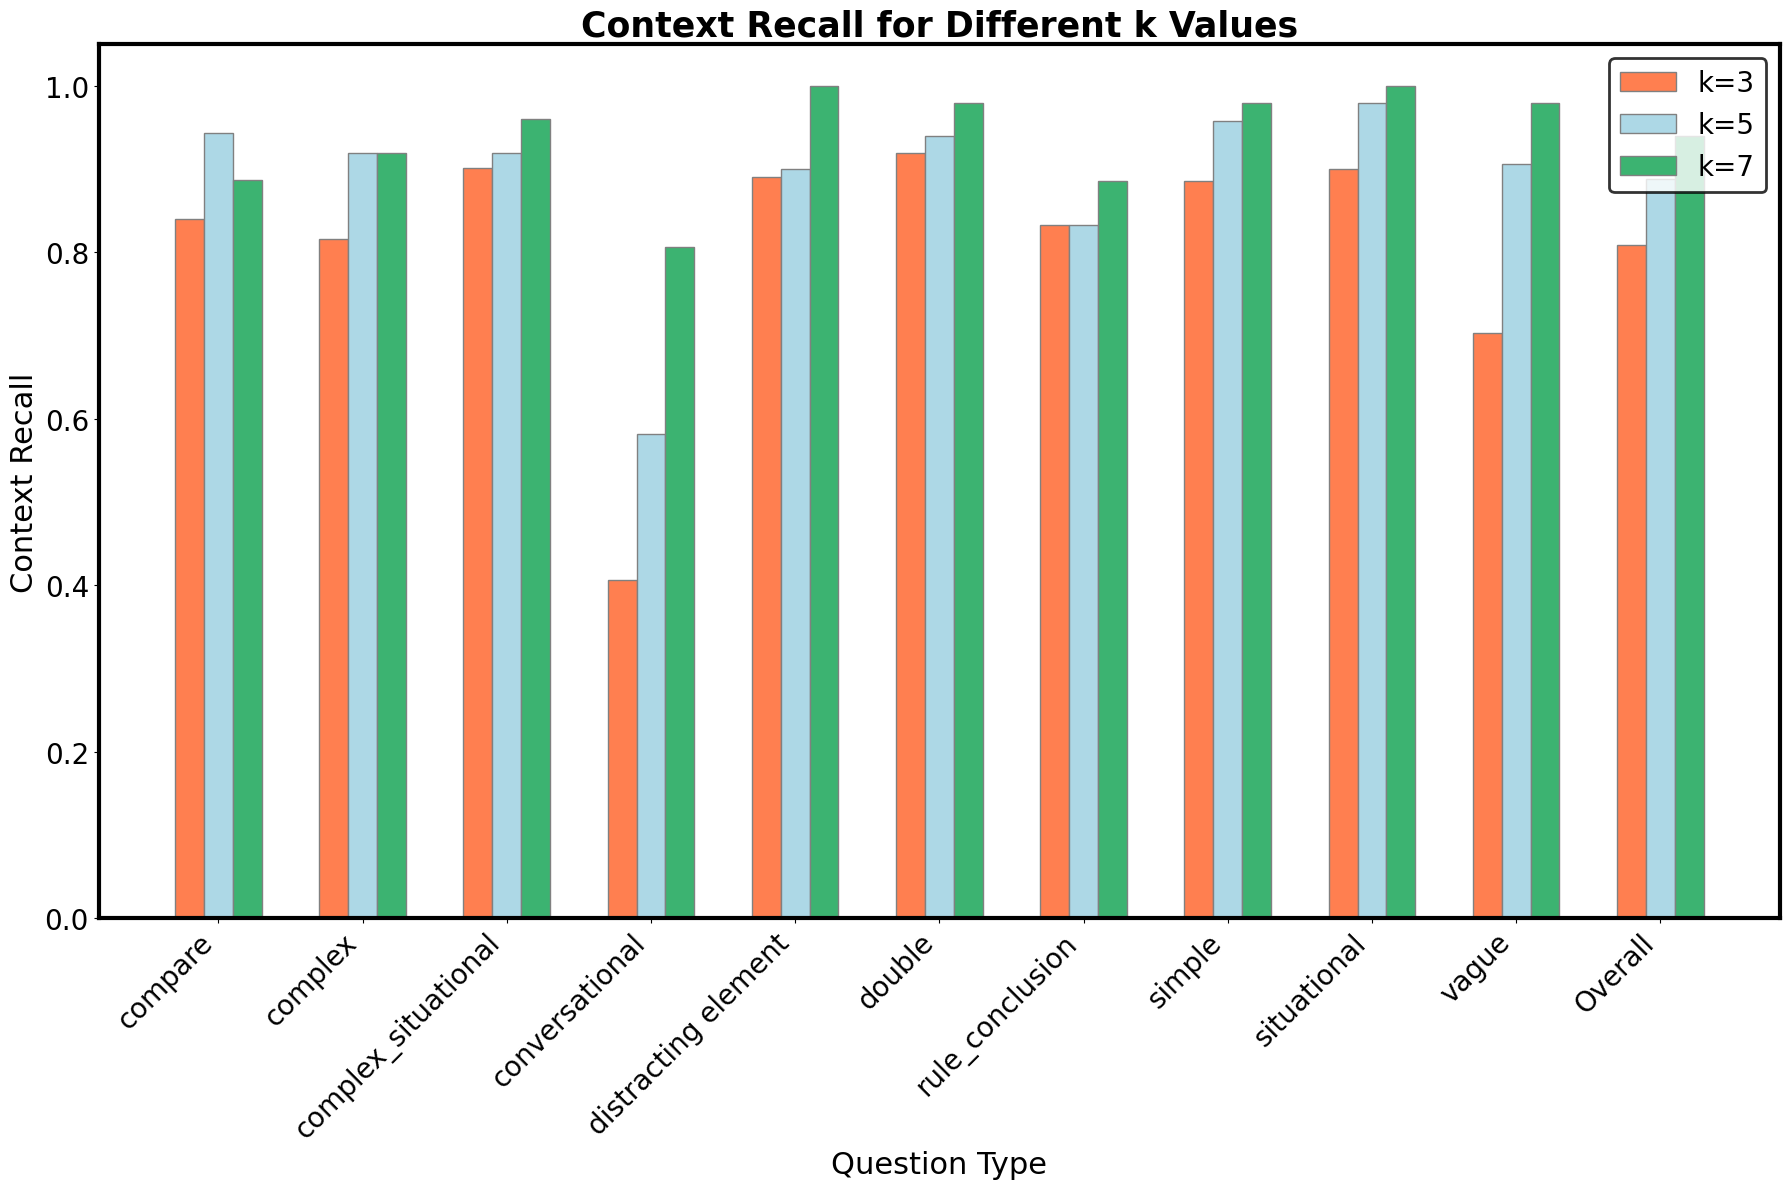

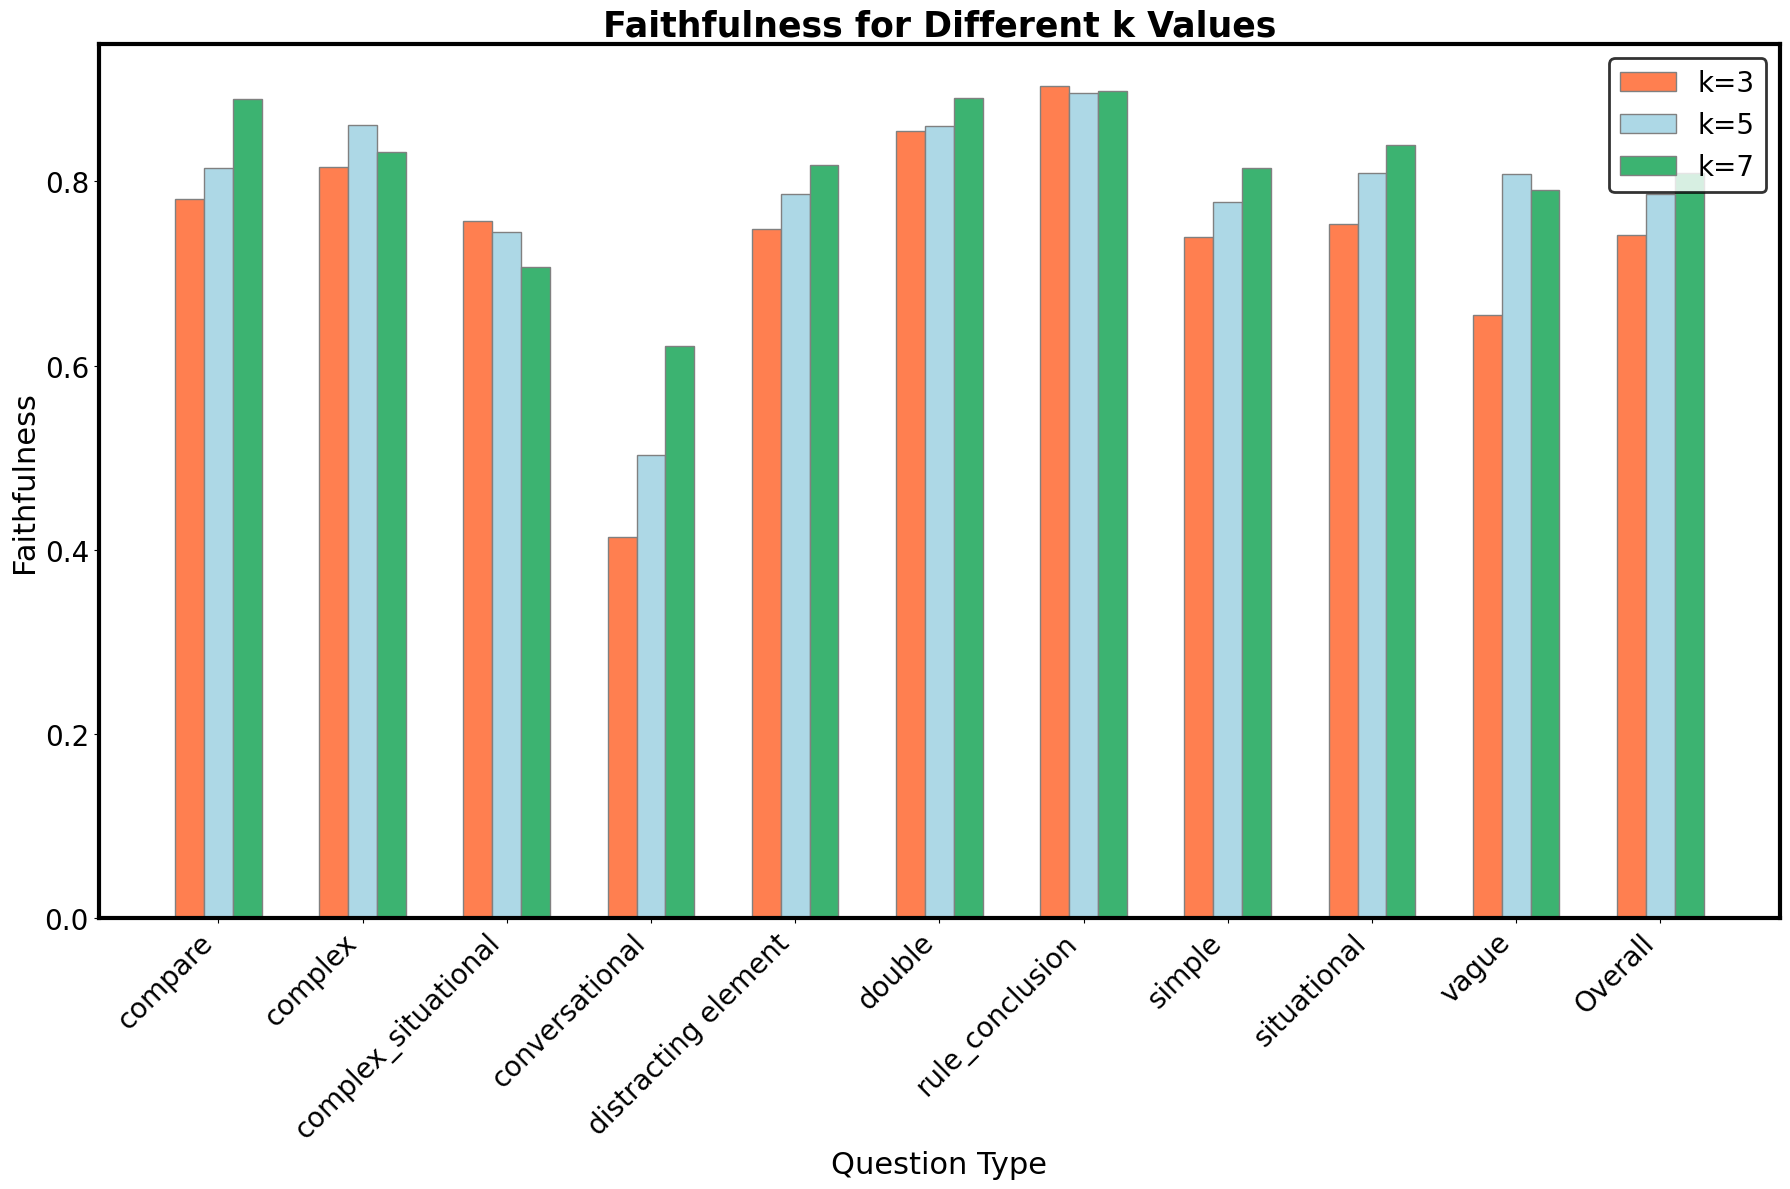

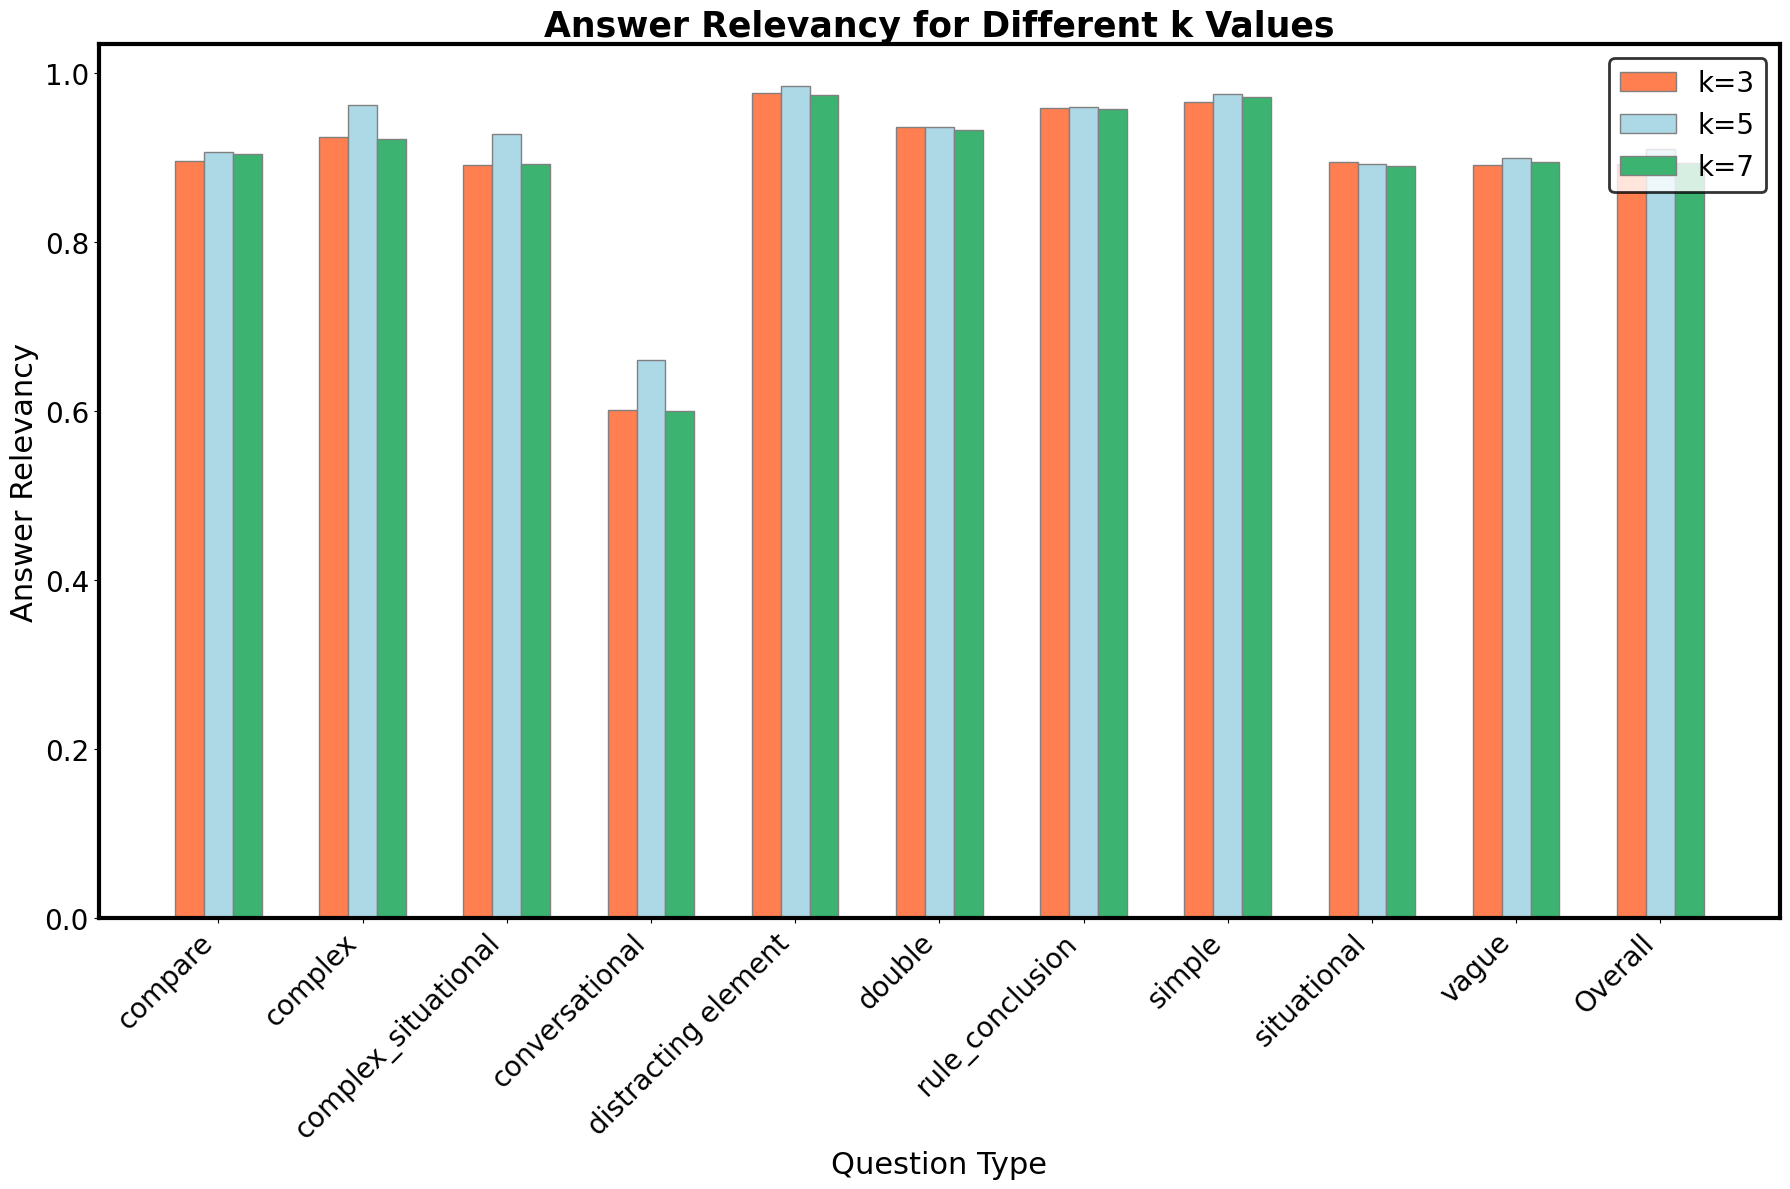

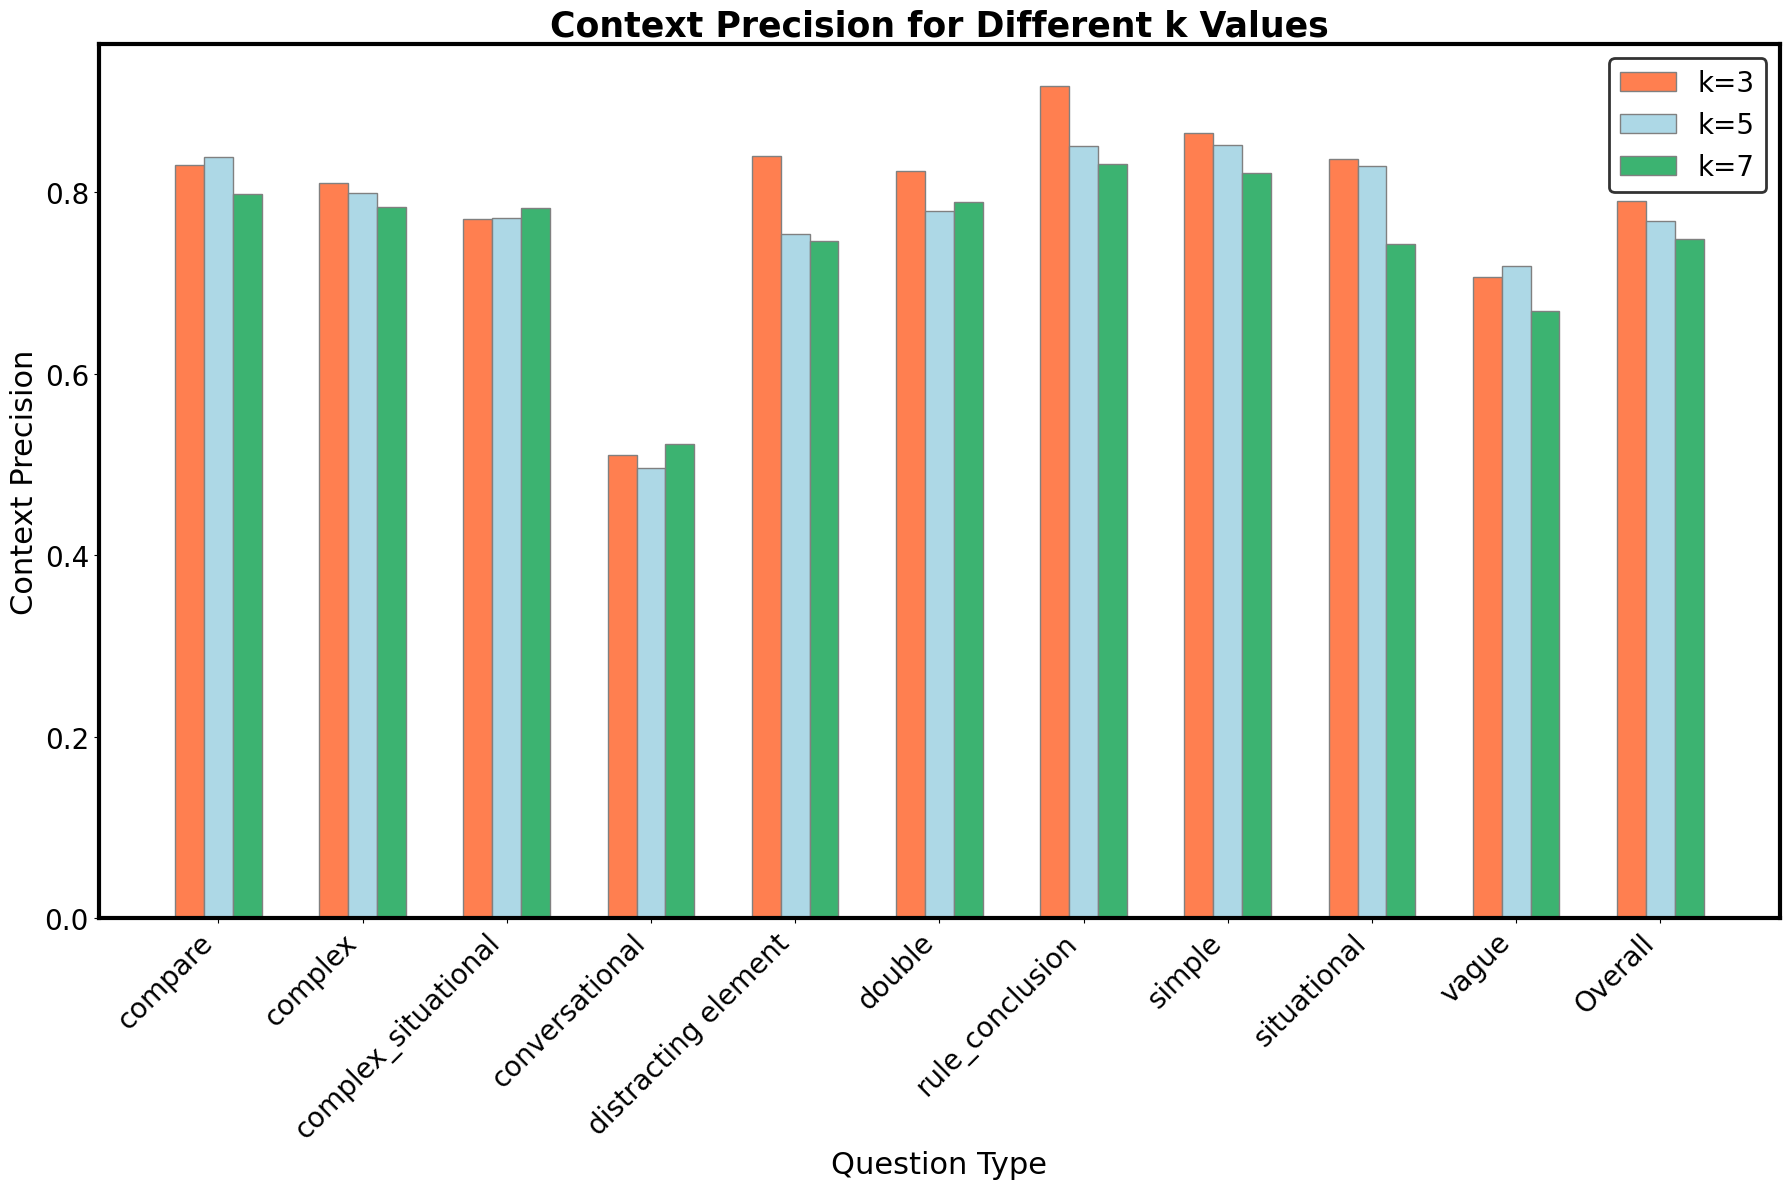

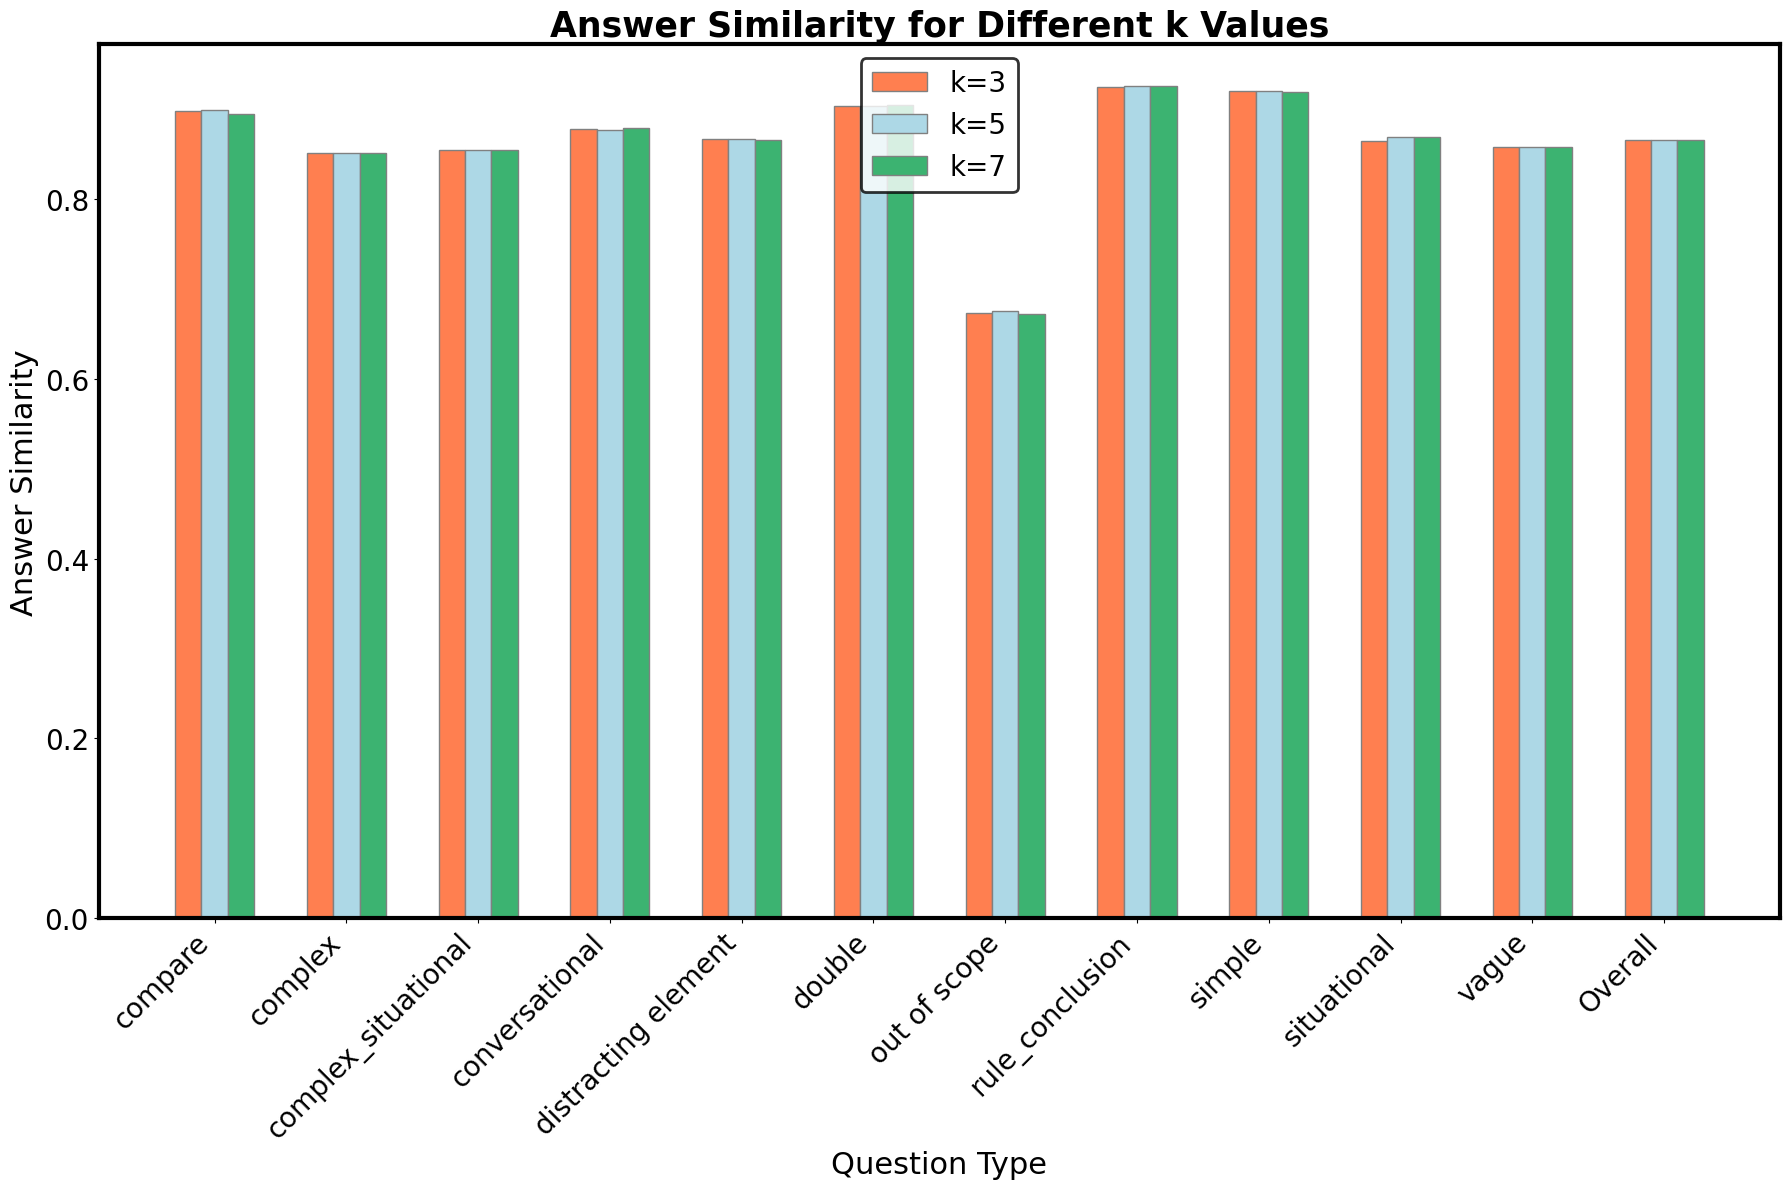

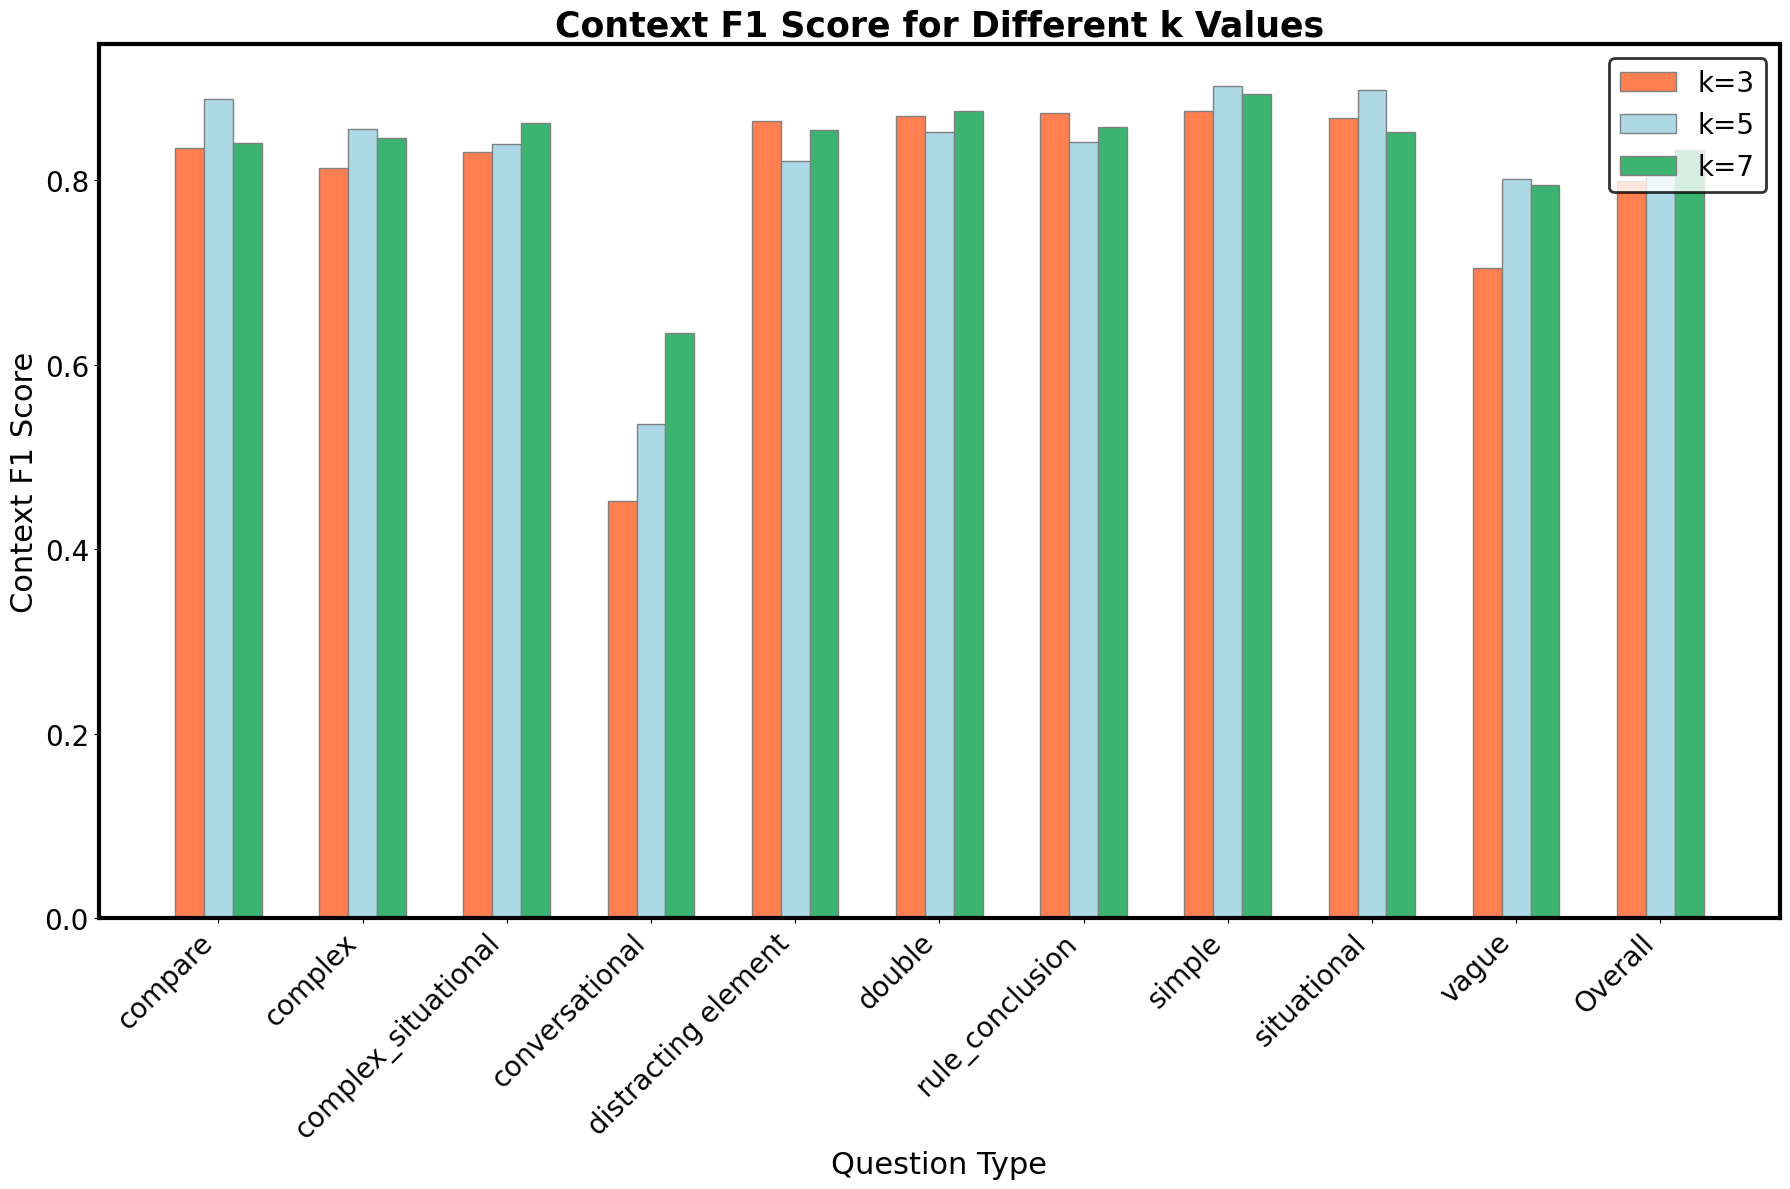

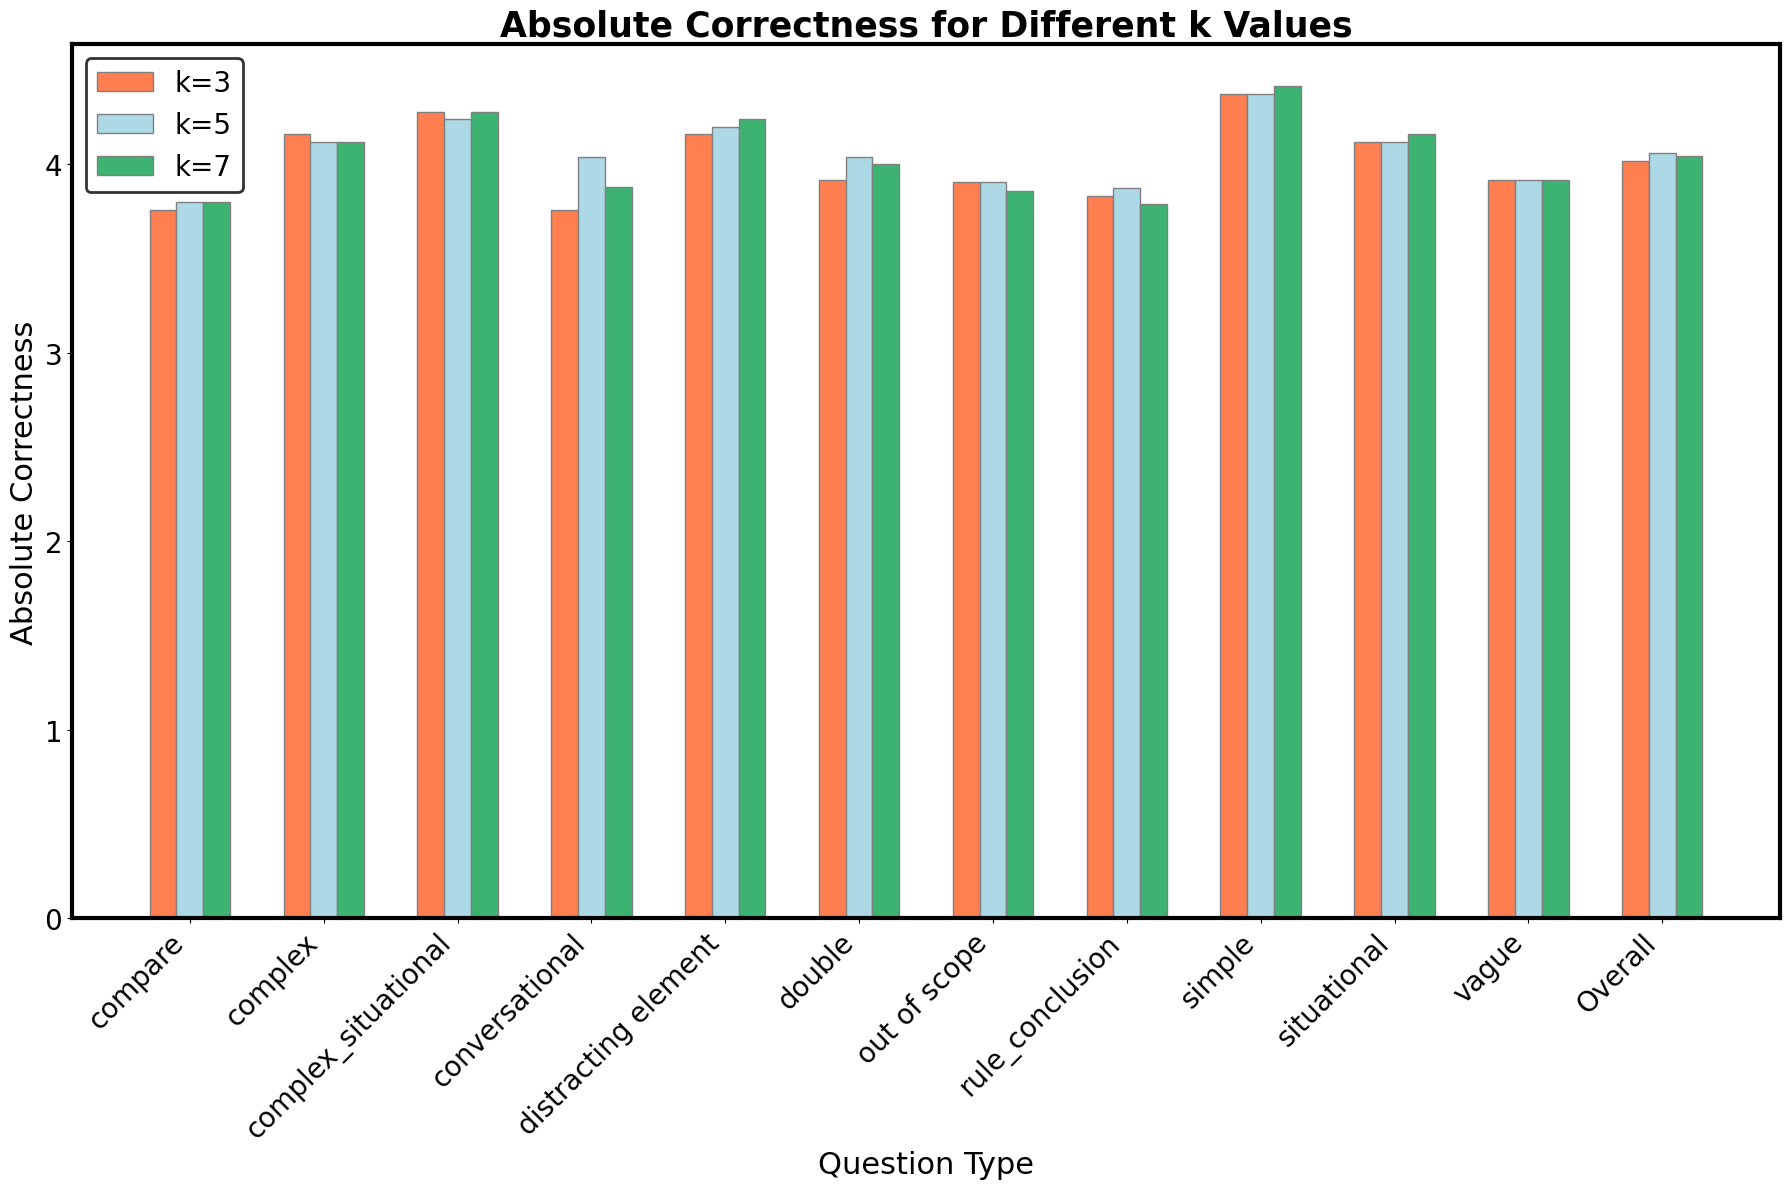

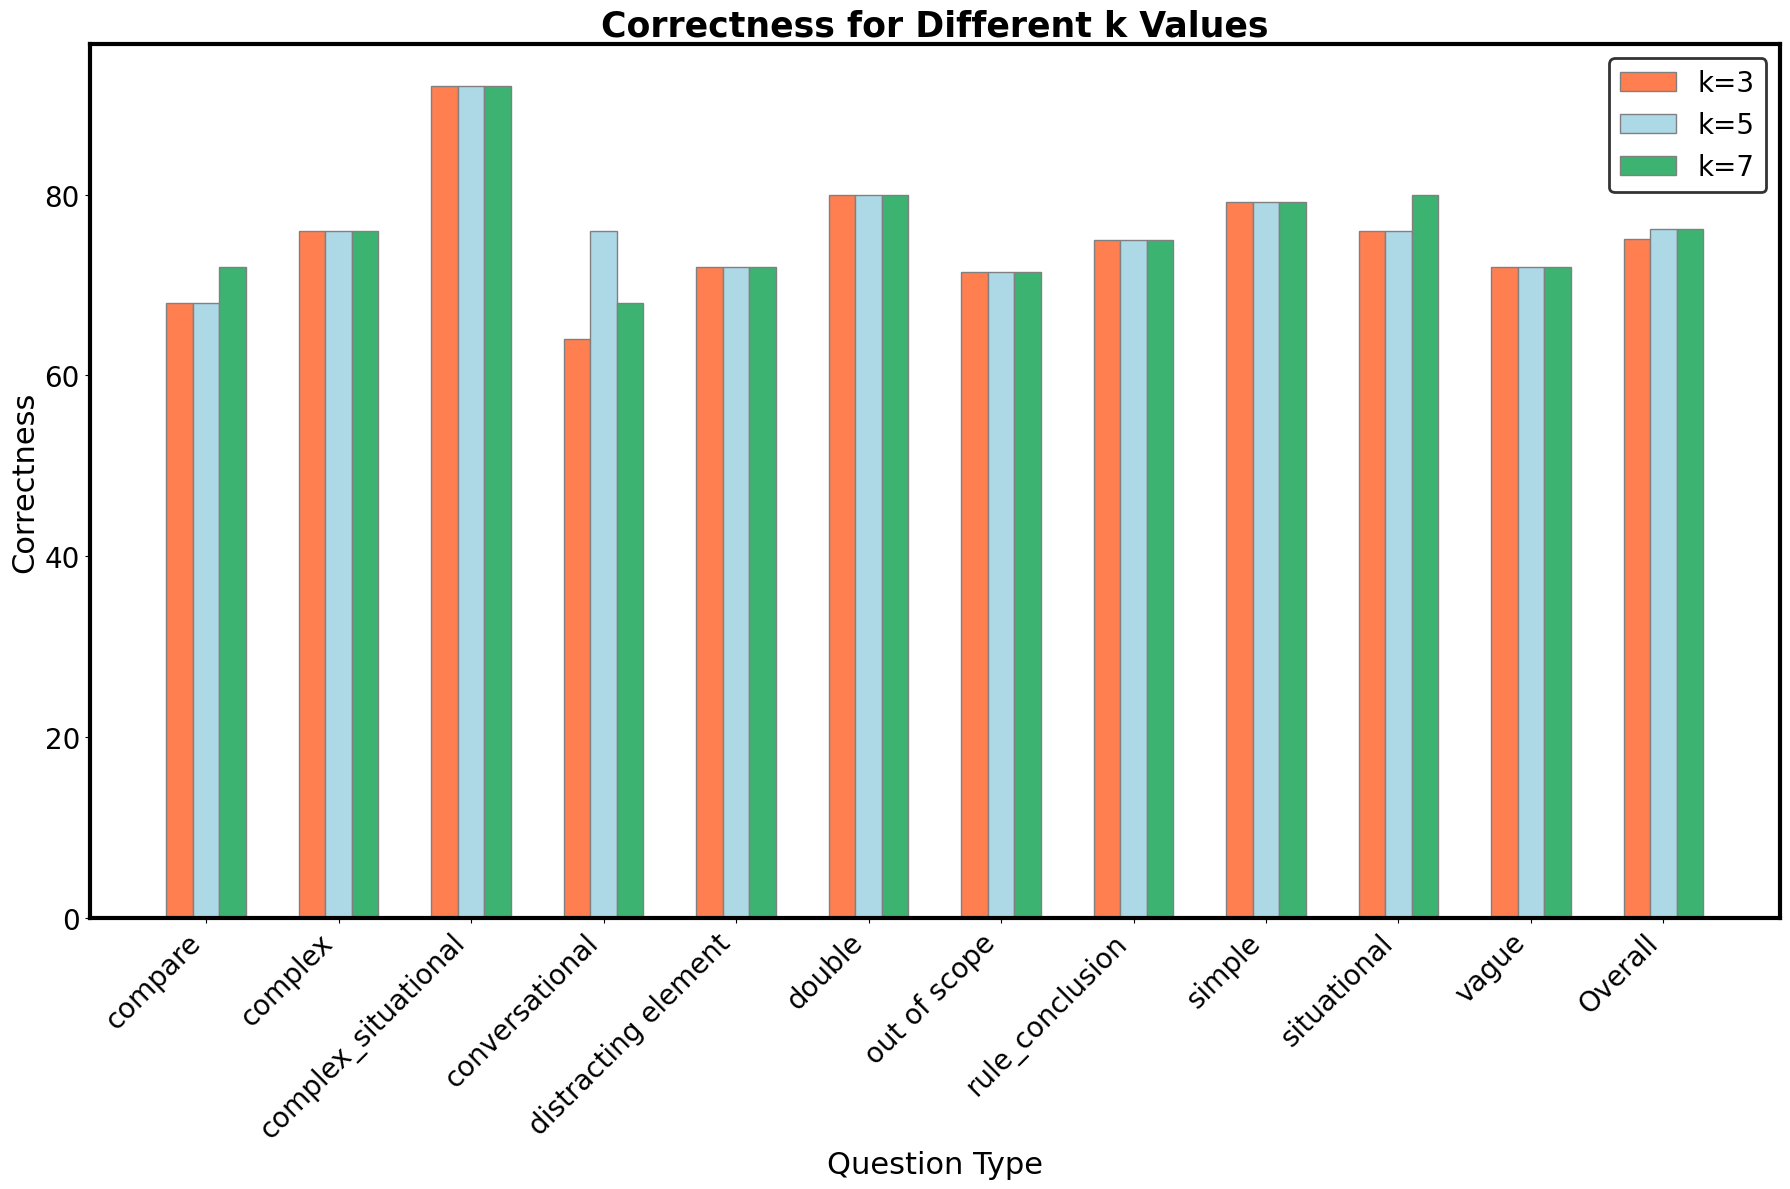

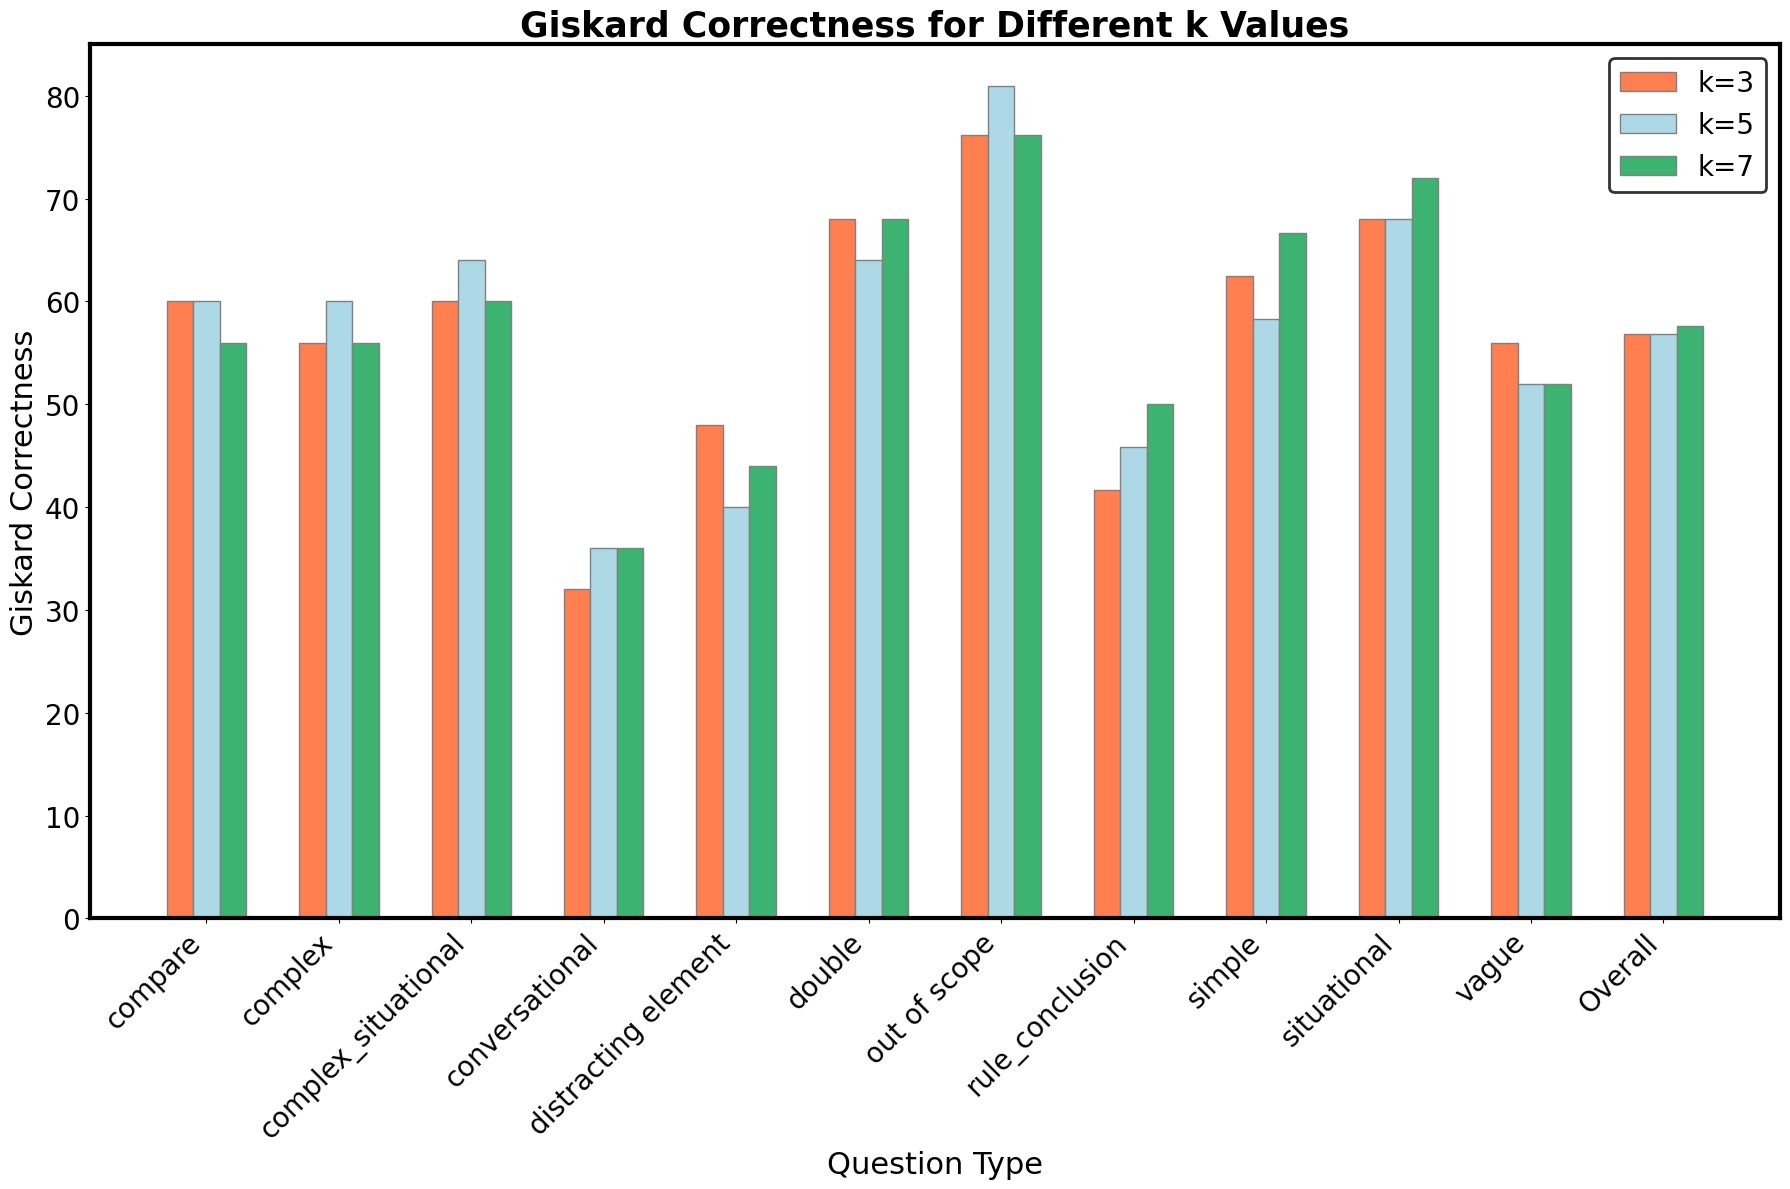

In [98]:
import numpy as np

# Define formatting parameters
fontsize_title = 25
fontsize_labels = 22
fontsize_ticks = 20
fontsize_legend = 20
bar_width = 0.2

# Loop through each metric and create a grouped bar chart with custom formatting
for metric in metrics_to_plot:
    combined_df_metric = pd.DataFrame({
        'question_type': metrics_df_k3['question_type'],
        f'{metric}_k3': metrics_df_k3[metric],
        f'{metric}_k5': metrics_df_k5[metric],
        f'{metric}_k7': metrics_df_k7[metric]
    })

    # Remove 'out of scope' rows if the value is NaN for the current metric
    combined_df_metric = combined_df_metric.dropna(subset=[f'{metric}_k3', f'{metric}_k5', f'{metric}_k7'], how='all')

    # Set the positions of the bars
    r1 = np.arange(len(combined_df_metric))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Plotting the grouped bar chart for the current metric
    fig, ax = plt.subplots(figsize=(18, 12))

    ax.bar(r1, combined_df_metric[f'{metric}_k3'], color='coral', width=bar_width, edgecolor='grey', label='k=3')
    ax.bar(r2, combined_df_metric[f'{metric}_k5'], color='lightblue', width=bar_width, edgecolor='grey', label='k=5')
    ax.bar(r3, combined_df_metric[f'{metric}_k7'], color='mediumseagreen', width=bar_width, edgecolor='grey', label='k=7')

    # Add labels and title
    ax.set_xlabel('Question Type', fontsize=fontsize_labels)
    ax.set_ylabel(metrics_labels.get(metric, metric.replace('RAGAS ', '')), fontsize=fontsize_labels)
    ax.set_title(f'{metrics_labels.get(metric, metric.replace("RAGAS ", ""))} for Different k Values', fontsize=fontsize_title, fontweight='bold')
    ax.set_xticks([r + bar_width for r in range(len(combined_df_metric))])
    ax.set_xticklabels(combined_df_metric['question_type'], rotation=45, ha='right', fontsize=fontsize_ticks)
    ax.tick_params(axis='y', labelsize=fontsize_ticks)

    # Add legend with a border and increased font size
    legend = ax.legend(fontsize=fontsize_legend)
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(2)

    # Customize the border of the plot
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

    # Display the bar chart
    plt.tight_layout()
    plt.show()


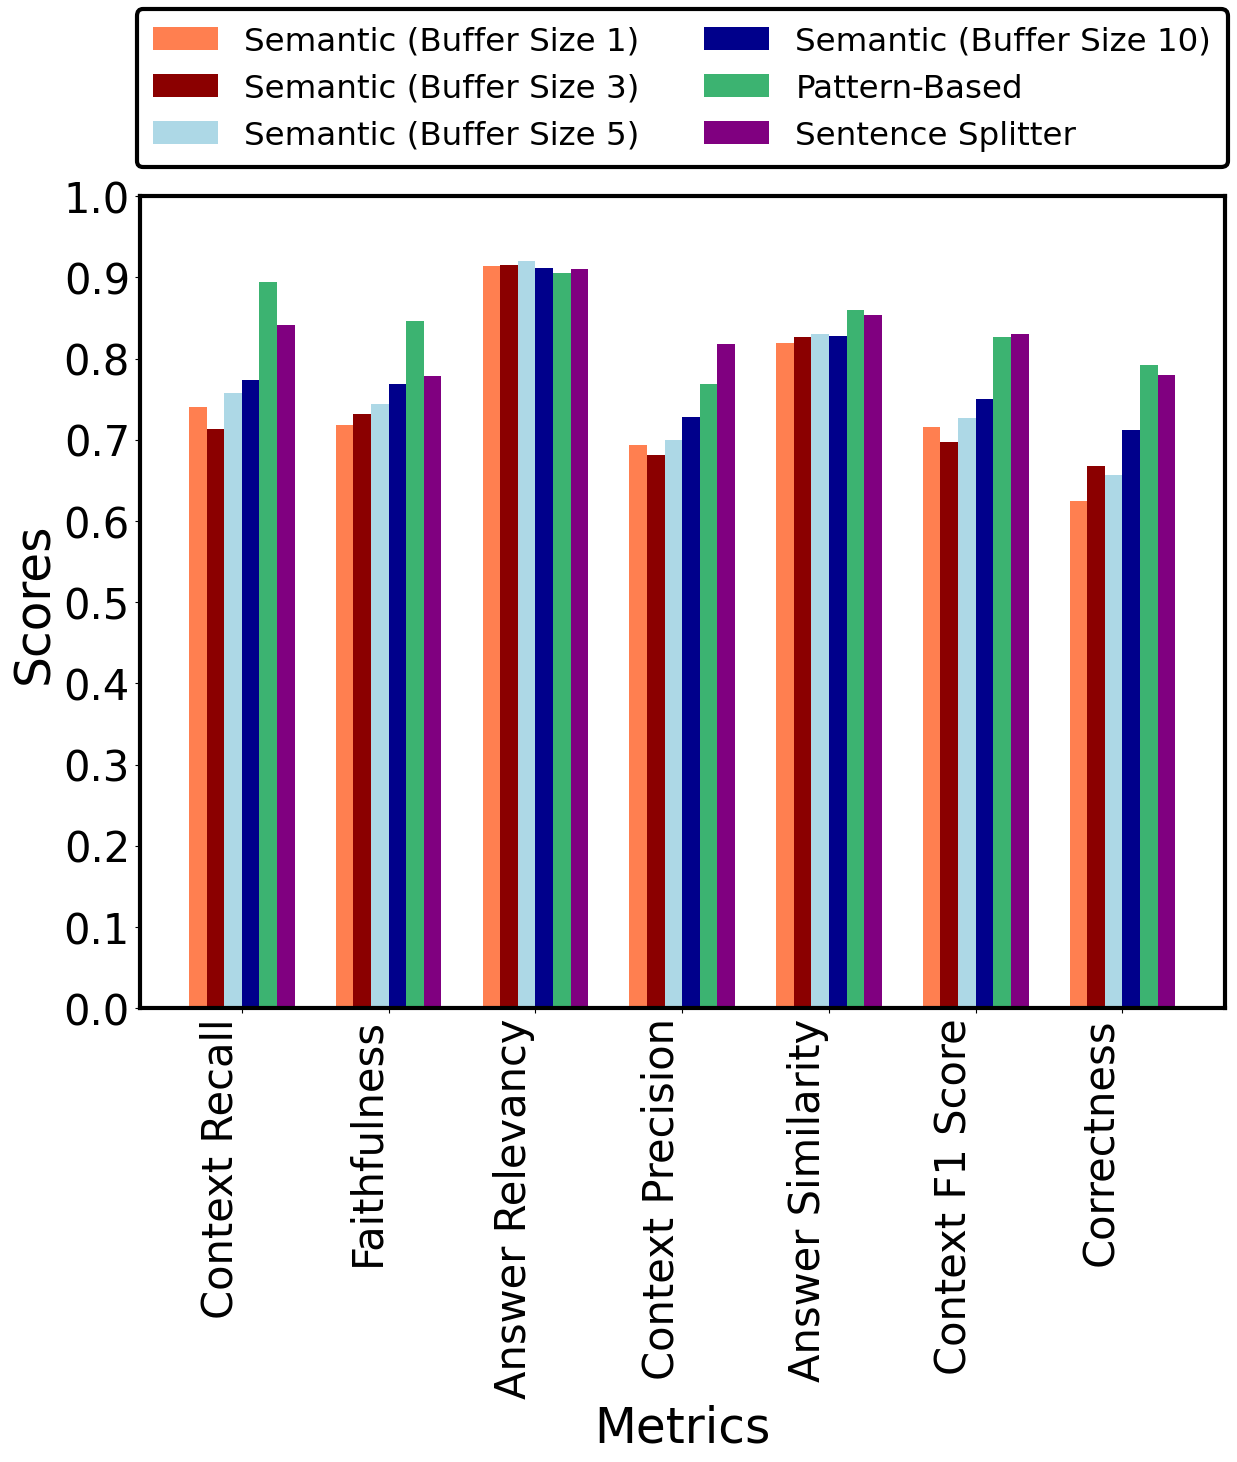

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics labels
labels = [
    'Context Recall', 'Faithfulness', 'Answer Relevancy',
    'Context Precision', 'Answer Similarity', 'Context F1 Score',
    'Correctness'
]

# Metrics for sentence splitter
sentence_splitter = [0.841903, 0.778554, 0.910375, 0.818151, 0.854159, 0.829857, 77.985075 / 100]

# Metrics for semantic splitting with different buffer sizes (excluding absolute correctness)
semantic_metrics_buffer_1 = [0.740696, 0.718541, 0.914194, 0.693440, 0.819511, 0.716290, 62.408759 / 100]
semantic_metrics_buffer_3 = [0.713777, 0.732070, 0.915663, 0.680723, 0.826409, 0.696858, 66.788321 / 100]
semantic_metrics_buffer_5 = [0.757831, 0.744058, 0.920298, 0.699465, 0.829801, 0.727479, 65.693431 / 100]
semantic_metrics_buffer_10 = [0.773159, 0.768972, 0.911412, 0.728581, 0.828194, 0.750209, 71.167883 / 100]

# Metrics for character-based splitting
character_metrics = [0.894489, 0.845838, 0.905198, 0.768912, 0.859479, 0.826961, 79.182156 / 100]

x = np.arange(len(labels))  # label locations
width = 0.12  # bar width

fig, ax = plt.subplots(figsize=(14, 14))
bars1 = ax.bar(x - 2.5 * width, semantic_metrics_buffer_1, width, label='Semantic (Buffer Size 1)', color='coral')
bars2 = ax.bar(x - 1.5 * width, semantic_metrics_buffer_3, width, label='Semantic (Buffer Size 3)', color='darkred')
bars3 = ax.bar(x - 0.5 * width, semantic_metrics_buffer_5, width, label='Semantic (Buffer Size 5)', color='lightblue')
bars4 = ax.bar(x + 0.5 * width, semantic_metrics_buffer_10, width, label='Semantic (Buffer Size 10)', color='darkblue')
bars5 = ax.bar(x + 1.5 * width, character_metrics, width, label='Pattern-Based', color='mediumseagreen')
bars6 = ax.bar(x + 2.5 * width, sentence_splitter, width, label='Sentence Splitter', color='purple')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics', fontsize=35)
ax.set_ylabel('Scores', fontsize=35)
#ax.set_title('Comparison of Different Splitting Metrics', fontsize=30, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha="right", fontsize=25)
ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)

# Adjust y-axis intervals to be every 0.10
ax.set_yticks(np.arange(0, 1.1, 0.10))

# Add legend further below the plot
legend = ax.legend(fontsize=23.4, title_fontsize=40, frameon=True, loc='upper center', bbox_to_anchor=(0.5, 1.25),  ncol=2, framealpha=1., borderpad=.5, fancybox=True, shadow=False)
#legend.get_frame().set_edgecolor('black')
#legend.get_frame().set_linewidth(2)

# Adjust legend properties to be below the plot and span its full width
#legend = ax.legend(['Baseline', 'Prompt 1', 'Prompt 2', 'Giskard'], fontsize=23.4, title_fontsize=40, frameon=True, loc='upper center', bbox_to_anchor=(0.5, 1.15),  ncol=4, framealpha=1., borderpad=.9, fancybox=True, shadow=False)
legend.get_frame().set_linewidth(3)
legend.get_frame().set_edgecolor('black')  # Add black border to the legend

# Customize the border of the plot
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

# Adjust layout to make room for the legend
fig.subplots_adjust(bottom=0.3)  # Increase bottom margin

# Display the bar chart
plt.show()


question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.796667            0.874911   
1               complex              0.920000            0.903302   
2   complex_situational              0.920000            0.772058   
3        conversational              0.706667            0.412873   
4   distracting element              0.948667            0.814580   
5                double              0.980000            0.898014   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.937500            0.834623   
8                simple              0.968750            0.728998   
9           situational              0.980000            0.758683   
10                vague              0.860000            0.725931   
11              Overall              0.901411            0.772321   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.791991                 0.978937           0.894388   
1                 0.875007                 0.962333           0.854039   
2                 0.766799                 0.958389           0.859639   
3                 0.464842                 0.703333           0.876064   
4                 0.920787                 0.981333           0.866265   
5                 0.841477                 0.960722           0.893173   
6                      NaN                      NaN           0.672055   
7                 0.897638                 0.979340           0.919646   
8                 0.846477                 0.927778           0.890483   
9                 0.821122                 0.968667           0.862398   
10                0.719863                 0.917611           0.851018   
11                0.793976                 0.933685           0.860524   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.878446             3.760000                   60.000000   
1                 0.940691             4.040000                   80.000000   
2                 0.938802             4.400000                   88.000000   
3                 0.704996             3.920000                   64.000000   
4                 0.964724             4.040000                   76.000000   
5                 0.970265             4.160000                   88.000000   
6                      NaN             3.619048                   47.619048   
7                 0.957963             4.083333                   83.333333   
8                 0.947821             4.083333                   75.000000   
9                 0.974300             4.280000                   92.000000   
10                0.887872             4.000000                   80.000000   
11                0.917265             4.040892                   76.208178   

    correctness  
0     20.000000  
1     32.000000  
2     60.000000  
3     28.000000  
4     28.000000  
5     20.000000  
6     61.904762  
7     45.833333  
8     29.166667  
9     48.000000  
10    32.000000  
11    36.431227

In [18]:
file_path = 'rewriter_with_topics_n7.csv'
metrics_df = compute_metrics(file_path)

metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.676667            0.248182   
1               complex              0.773333            0.235898   
2   complex_situational              0.820000            0.202107   
3        conversational              0.437500            0.192817   
4   distracting element              0.646667            0.311919   
5                double              0.826667            0.211074   
6          out of scope              0.785714            0.260416   
7       rule_conclusion              0.729167            0.166935   
8                simple              0.801389            0.139350   
9           situational              0.816667            0.301785   
10                vague              0.586000            0.088848   
11              Overall              0.717848            0.214726   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.881248                 0.739333           0.867421   
1                 0.953677                 0.646278           0.805242   
2                 0.781556                 0.715000           0.804683   
3                 0.716098                 0.553167           0.811788   
4                 0.925520                 0.694889           0.813006   
5                 0.887956                 0.790056           0.836296   
6                 0.277197                 0.317460           0.597741   
7                 0.799271                 0.796470           0.839040   
8                 0.933450                 0.771933           0.805745   
9                 0.859639                 0.628444           0.822577   
10                0.716102                 0.716167           0.666020   
11                0.800934                 0.674318           0.790718   

    RAGAS Context F1 Score  correctness  
0                 0.706613     8.000000  
1                 0.704120    12.000000  
2                 0.763909    12.000000  
3                 0.488581    20.000000  
4                 0.669911    20.000000  
5                 0.807947     4.000000  
6                 0.452210    42.857143  
7                 0.761334    12.500000  
8                 0.786385    12.500000  
9                 0.710298    20.000000  
10                0.644577    12.000000  
11                0.695403    15.613383

In [19]:
# Usage example
file_path = '../eval_results/baseline_results/baseline_results.csv'
metrics_df = compute_metrics(file_path)
metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.850000            0.724820   
1               complex              0.850000            0.913508   
2   complex_situational              0.834000            0.727737   
3        conversational              0.570000            0.510528   
4   distracting element              0.800000            0.830121   
5                double              0.920000            0.782381   
6          out of scope              0.708333            0.878667   
7       rule_conclusion              0.916667            0.899522   
8                simple              0.840000            0.862901   
9           situational              0.940000            0.861725   
10                vague              0.745333            0.880889   
11              Overall              0.815873            0.806279   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.944942                 0.826667           0.885556   
1                 0.915281                 0.753333           0.840241   
2                 0.863392                 0.770000           0.840083   
3                 0.778796                 0.680000           0.896639   
4                 0.969320                 0.793333           0.854879   
5                 0.924849                 0.880000           0.890906   
6                 0.812343                 0.260000           0.490994   
7                 0.962952                 0.881944           0.909311   
8                 0.921582                 0.823333           0.899721   
9                 0.940329                 0.930000           0.872953   
10                0.900076                 0.813333           0.832708   
11                0.902860                 0.764294           0.837374   

    RAGAS Context F1 Score  correctness  
0                 0.838171    80.000000  
1                 0.798753    52.000000  
2                 0.800723    64.000000  
3                 0.620160    60.000000  
4                 0.796653    44.000000  
5                 0.899556    84.000000  
6                 0.380379    24.000000  
7                 0.898970    54.166667  
8                 0.831583    68.000000  
9                 0.934973    64.000000  
10                0.777850    60.000000  
11                0.789242    59.489051

In [73]:
# Usage example
file_path = '../eval_results/bm25_results/bm25_results.csv'
metrics_df = compute_metrics(file_path)
metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.806667            0.639982   
1               complex              0.800000            0.719756   
2   complex_situational              0.796667            0.639761   
3        conversational              0.512000            0.520478   
4   distracting element              0.813333            0.720238   
5                double              0.760000            0.691851   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.895833            0.856800   
8                simple              0.926667            0.727459   
9           situational              0.810000            0.705989   
10                vague              0.831333            0.685771   
11              Overall              0.794846            0.690142   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.940908                 0.690000           0.886145   
1                 0.913674                 0.583333           0.843916   
2                 0.897330                 0.700000           0.840595   
3                 0.777671                 0.343333           0.898729   
4                 0.967200                 0.763333           0.850193   
5                 0.927273                 0.786667           0.891833   
6                      NaN                      NaN           0.487914   
7                 0.963342                 0.888889           0.904449   
8                 0.929130                 0.846667           0.898153   
9                 0.935844                 0.653333           0.872125   
10                0.896311                 0.643333           0.830205   
11                0.914674                 0.689090           0.836503   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.743786             4.080000                    80.00000   
1                 0.674699             4.120000                    80.00000   
2                 0.745212             4.240000                    84.00000   
3                 0.411037             4.240000                    84.00000   
4                 0.787541             3.920000                    60.00000   
5                 0.773103             4.240000                    96.00000   
6                      NaN             3.040000                    36.00000   
7                 0.892348             3.750000                    75.00000   
8                 0.884862             3.920000                    68.00000   
9                 0.723280             4.080000                    68.00000   
10                0.725350             3.760000                    60.00000   
11                0.738199             3.945255                    71.89781   

    correctness  
0     80.000000  
1     48.000000  
2     68.000000  
3     68.000000  
4     52.000000  
5     84.000000  
6     24.000000  
7     45.833333  
8     60.000000  
9     60.000000  
10    56.000000  
11    58.759124

In [21]:
# Usage example
file_path = '../eval_results/chunk_results/chunk_results.csv'
metrics_df = compute_metrics(file_path)
metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.730000            0.639953   
1               complex              0.830000            0.742505   
2   complex_situational              0.810000            0.672949   
3        conversational              0.516667            0.465640   
4   distracting element              0.884000            0.777499   
5                double              0.800000            0.656625   
6          out of scope              0.645833            0.640774   
7       rule_conclusion              0.791667            0.851669   
8                simple              0.913333            0.835593   
9           situational              0.810000            0.741039   
10                vague              0.806000            0.793952   
11              Overall              0.776557            0.710231   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.866830                 0.866667           0.899400   
1                 0.914082                 0.873333           0.845974   
2                 0.936732                 0.860000           0.854645   
3                 0.749502                 0.700000           0.870085   
4                 0.969647                 0.913333           0.852831   
5                 0.872539                 0.770000           0.883683   
6                 0.685418                 0.173333           0.485459   
7                 0.960971                 0.916667           0.903529   
8                 0.929153                 0.900000           0.876535   
9                 0.940735                 0.860000           0.849532   
10                0.878415                 0.860000           0.772349   
11                0.881896                 0.789842           0.826449   

    RAGAS Context F1 Score  correctness  
0                 0.792484    72.000000  
1                 0.851115    48.000000  
2                 0.834251    72.000000  
3                 0.594521    40.000000  
4                 0.898427    44.000000  
5                 0.784713    52.000000  
6                 0.273313    32.000000  
7                 0.849593    62.500000  
8                 0.906618    48.000000  
9                 0.834251    60.000000  
10                0.832125    32.000000  
11                0.783143    51.094891

In [22]:
# Usage example
file_path = '../eval_results/metadata_results/metadata_results.csv'
metrics_df = compute_metrics(file_path)
metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.720000            0.646175   
1               complex              0.660000            0.783564   
2   complex_situational              0.696667            0.712456   
3        conversational              0.480000            0.437556   
4   distracting element              0.781333            0.801982   
5                double              0.800000            0.653588   
6          out of scope              0.660000            0.699940   
7       rule_conclusion              0.812500            0.903072   
8                simple              0.854167            0.828875   
9           situational              0.850000            0.773341   
10                vague              0.666667            0.756960   
11              Overall              0.724786            0.726194   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.917362                 0.813333           0.890266   
1                 0.872826                 0.746667           0.831335   
2                 0.895431                 0.760000           0.831184   
3                 0.781059                 0.460000           0.885185   
4                 0.960873                 0.753333           0.846508   
5                 0.933440                 0.753333           0.887352   
6                 0.617039                 0.226667           0.480752   
7                 0.967432                 0.875000           0.900437   
8                 0.966563                 0.770000           0.888983   
9                 0.941152                 0.806667           0.866245   
10                0.871810                 0.666667           0.805763   
11                0.883786                 0.693127           0.828284   

    RAGAS Context F1 Score  correctness  
0                 0.763826    68.000000  
1                 0.700664    44.000000  
2                 0.726957    52.000000  
3                 0.469787    48.000000  
4                 0.767078    36.000000  
5                 0.775966    60.000000  
6                 0.337444    28.000000  
7                 0.842593    50.000000  
8                 0.809903    60.000000  
9                 0.827767    68.000000  
10                0.666667    48.000000  
11                0.708603    51.094891

In [9]:
# Usage example
file_path = 'char_split_results.csv'
metrics_df = compute_metrics(file_path)
metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.922000            0.347030   
1               complex              0.970000            0.333557   
2   complex_situational              0.960000            0.363305   
3        conversational              0.520000            0.195235   
4   distracting element              0.960000            0.350054   
5                double              0.980000            0.353573   
6          out of scope              0.812500            0.273706   
7       rule_conclusion              0.895833            0.286734   
8                simple              0.916667            0.289190   
9           situational              0.960000            0.377429   
10                vague              0.873333            0.206389   
11              Overall              0.888358            0.307066   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.807358                 0.692389           0.870594   
1                 0.957262                 0.831778           0.804068   
2                 0.861642                 0.849000           0.803560   
3                 0.781487                 0.573778           0.812737   
4                 0.974664                 0.825500           0.827839   
5                 0.862339                 0.786056           0.849556   
6                 0.623543                 0.308667           0.478440   
7                 0.839918                 0.872801           0.838004   
8                 0.940031                 0.853588           0.813249   
9                 0.820563                 0.806611           0.811411   
10                0.651314                 0.641278           0.666784   
11                0.828656                 0.730072           0.779322   

    RAGAS Context F1 Score  correctness  
0                 0.790866    16.000000  
1                 0.895587    16.000000  
2                 0.901095     8.000000  
3                 0.545567    24.000000  
4                 0.887684    32.000000  
5                 0.872378    16.000000  
6                 0.447376    24.000000  
7                 0.884167     8.333333  
8                 0.884003    20.833333  
9                 0.876646    20.000000  
10                0.739529    12.000000  
11                0.801475    17.948718

In [25]:
# Usage example
file_path = 'results_no_rewriter_k3.csv'
metrics_df = compute_metrics(file_path)
metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.853333            0.779989   
1               complex              0.926667            0.803459   
2   complex_situational              0.910000            0.823108   
3        conversational              0.600000            0.434129   
4   distracting element              0.794667            0.801354   
5                double              0.920000            0.796127   
6          out of scope              0.785714            0.651671   
7       rule_conclusion              0.885417            0.911938   
8                simple              0.784722            0.839597   
9           situational              0.970000            0.730860   
10                vague              0.760000            0.872013   
11              Overall              0.836245            0.768194   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.915685                 0.823333           0.886752   
1                 0.877459                 0.793333           0.840119   
2                 0.931530                 0.766667           0.856819   
3                 0.781244                 0.700000           0.905323   
4                 0.968775                 0.826667           0.853264   
5                 0.930156                 0.843333           0.892119   
6                 0.596190                 0.448413           0.623026   
7                 0.964268                 0.923611           0.910209   
8                 0.929463                 0.802083           0.901283   
9                 0.942683                 0.873333           0.867517   
10                0.864623                 0.820000           0.823758   
11                0.885775                 0.788104           0.853907   

    RAGAS Context F1 Score  correctness  
0                 0.838065    84.000000  
1                 0.854832    40.000000  
2                 0.832207    68.000000  
3                 0.646154    52.000000  
4                 0.810351    44.000000  
5                 0.880000    84.000000  
6                 0.570969    42.857143  
7                 0.904111    41.666667  
8                 0.793308    66.666667  
9                 0.919132    64.000000  
10                0.788861    48.000000  
11                0.811461    57.992565

In [26]:
# Usage example
file_path = 'results_no_rewriter_k5.csv'
metrics_df = compute_metrics(file_path)
metrics_df

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.893333            0.821714   
1               complex              0.970000            0.855750   
2   complex_situational              0.950000            0.845578   
3        conversational              0.694444            0.605739   
4   distracting element              0.980000            0.812445   
5                double              0.940000            0.808857   
6          out of scope              0.761905            0.621429   
7       rule_conclusion              0.906250            0.958684   
8                simple              0.902778            0.845792   
9           situational              0.920000            0.842512   
10                vague              0.851333            0.807933   
11              Overall              0.890672            0.804146   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.955232                 0.751722           0.881719   
1                 0.880083                 0.791444           0.838071   
2                 0.931354                 0.802111           0.854570   
3                 0.779570                 0.700722           0.901416   
4                 0.970143                 0.797056           0.853635   
5                 0.920783                 0.823556           0.895216   
6                 0.585065                 0.316336           0.622473   
7                 0.959432                 0.876562           0.909674   
8                 0.930244                 0.776331           0.901804   
9                 0.943027                 0.792778           0.869007   
10                0.833720                 0.668833           0.809128   
11                0.884708                 0.741703           0.851734   

    RAGAS Context F1 Score  correctness  
0                 0.816433    72.000000  
1                 0.871672    44.000000  
2                 0.869814    64.000000  
3                 0.697569    56.000000  
4                 0.879111    40.000000  
5                 0.877933    76.000000  
6                 0.447058    47.619048  
7                 0.891159    45.833333  
8                 0.834793    58.333333  
9                 0.851664    64.000000  
10                0.749129    44.000000  
11                0.809390    55.762082

In [1]:
# Usage example
file_path = 'graph_k5.csv'
metrics_df = compute_metrics(file_path)
metrics_df

NameError: name 'compute_metrics' is not defined

In [13]:
# Create a blank DataFrame
import os
combined_metrics_df = pd.DataFrame()

folder_path = '../eval_results/semantic_results/'

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        metrics_df = compute_metrics(file_path, display_overall_only=True)

        # Add a column for the filename
        metrics_df['filename'] = filename.replace('semantic_', '').replace('_results.csv', '')

        # Append to the combined DataFrame
        combined_metrics_df = pd.concat([combined_metrics_df, metrics_df], ignore_index=True)

# Set the row label to be the filename
combined_metrics_df.set_index('filename', inplace=True)

In [14]:
combined_metrics_df

RAGAS Context Recall  RAGAS Faithfulness  RAGAS Answer Relevancy  \
filename                                                                     
5_90                  0.757831            0.744058                0.920298   
10_90                 0.773159            0.768972                0.911412   
3_90                  0.713777            0.732070                0.915663   
1_90                  0.740696            0.718541                0.914194   

          RAGAS Context Precision question_type  RAGAS Context F1 Score  \
filename                                                                  
5_90                     0.699465       Overall                0.727479   
10_90                    0.728581       Overall                0.750209   
3_90                     0.680723       Overall                0.696858   
1_90                     0.693440       Overall                0.716290   

          correctness  answer similarity  
filename                                  
5_90        49.635036           0.829801  
10_90       54.379562           0.828194  
3_90        50.729927           0.826409  
1_90        45.620438           0.819511

In [4]:
# Usage example
file_path = 'graph_k5.csv'
metrics_df = compute_metrics(file_path, display_overall_only=True)
metrics_df

RAGAS Context Recall  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0              0.752823             0.82259                0.709899   

   RAGAS Context Precision question_type  RAGAS Context F1 Score  correctness  \
0                 0.882784       Overall                 0.81264    27.509294   

   answer similarity  correctness_method2  correctness_method2_mapped  
0            0.83741             3.732342                   62.081784

In [11]:
# Usage example
file_path = 'char_split_results2.csv'
metrics_df = compute_metrics(file_path, display_overall_only=True)
metrics_df

RAGAS Context Recall  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               0.89715            0.843003                0.855833   

   RAGAS Context Precision  answer similarity question_type  \
0                 0.728201           0.859479       Overall   

   RAGAS Context F1 Score  correctness  
0                0.803895    63.568773

In [10]:
graph_all = compute_metrics('graph_hybrid_rewriter_classifier_3class.csv')
graph_all

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.823333            0.903925   
1               complex              1.000000            0.812239   
2   complex_situational              1.000000            0.801145   
3        conversational              0.748000            0.532520   
4   distracting element              0.946667            0.865468   
5                double              0.980000            0.881169   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.937500            0.789695   
8                simple              0.958333            0.864075   
9           situational              0.980000            0.885017   
10                vague              0.926667            0.770227   
11              Overall              0.929906            0.810416   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.727132                 0.985722           0.879961   
1                 0.808310                 0.968889           0.838243   
2                 0.809108                 0.970000           0.841987   
3                 0.478031                 0.864389           0.913687   
4                 0.843238                 0.985667           0.856243   
5                 0.798609                 0.978000           0.892408   
6                      NaN                      NaN           0.657654   
7                 0.894162                 0.972975           0.883939   
8                 0.812697                 0.980556           0.860813   
9                 0.845841                 0.988000           0.848676   
10                0.686991                 0.945056           0.816603   
11                0.769742                 0.963822           0.847137   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.897239             3.560000                   56.000000   
1                 0.984199             4.080000                   84.000000   
2                 0.984772             4.240000                   88.000000   
3                 0.801994             4.280000                   84.000000   
4                 0.965773             4.080000                   80.000000   
5                 0.978999             4.160000                   92.000000   
6                      NaN             3.428571                   47.619048   
7                 0.954908             3.958333                   79.166667   
8                 0.969317             4.208333                   79.166667   
9                 0.983984             4.200000                   92.000000   
10                0.935771             3.640000                   56.000000   
11                0.946560             3.992565                   76.579926   

    correctness  
0     12.000000  
1     40.000000  
2     40.000000  
3     20.000000  
4     36.000000  
5     32.000000  
6     61.904762  
7     29.166667  
8     50.000000  
9     40.000000  
10    28.000000  
11    34.944238

In [11]:
graph_no_rewriter_all = compute_metrics('graph_hybrid_no_rewriter_3class.csv')
graph_no_rewriter_all

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.816667            0.901883   
1               complex              0.980000            0.902411   
2   complex_situational              0.960000            0.852222   
3        conversational              0.780000            0.635244   
4   distracting element              0.986667            0.881364   
5                double              0.980000            0.885550   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.958333            0.821078   
8                simple              0.937500            0.803307   
9           situational              0.980000            0.841490   
10                vague              0.910000            0.831615   
11              Overall              0.928763            0.835805   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.801767                 0.962167           0.881364   
1                 0.862383                 0.980500           0.865106   
2                 0.777373                 0.973333           0.862833   
3                 0.484339                 0.831056           0.915823   
4                 0.832798                 0.968833           0.841999   
5                 0.782105                 0.985667           0.885062   
6                      NaN                      NaN           0.665300   
7                 0.847537                 0.963889           0.871581   
8                 0.822216                 0.985590           0.866970   
9                 0.804209                 0.982833           0.844299   
10                0.672192                 0.940444           0.806222   
11                0.768158                 0.957292           0.848566   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.883466             3.720000                   72.000000   
1                 0.980250             4.160000                   84.000000   
2                 0.966621             4.200000                   84.000000   
3                 0.804719             4.280000                   84.000000   
4                 0.977669             3.840000                   76.000000   
5                 0.982825             4.080000                   88.000000   
6                      NaN             3.523810                   47.619048   
7                 0.961103             3.750000                   75.000000   
8                 0.960944             3.958333                   75.000000   
9                 0.981415             4.040000                   76.000000   
10                0.924972             3.560000                   52.000000   
11                0.942812             3.925651                   74.349442   

    correctness  
0      8.000000  
1     36.000000  
2     44.000000  
3     20.000000  
4     28.000000  
5     16.000000  
6     66.666667  
7     33.333333  
8     33.333333  
9     40.000000  
10    12.000000  
11    30.111524

In [12]:
graph_hybrid_no_rewriter_classifier_3class_large_rerank = compute_metrics('graph_hybrid_no_rewriter_classifier_3class_large_rerank.csv')
graph_hybrid_no_rewriter_classifier_3class = compute_metrics('graph_hybrid_no_rewriter_classifier_3class.csv')
graph_hybrid_rewriter_classifier_2class_large_rerank = compute_metrics('graph_hybrid_rewriter_classifier_2class_large_rerank.csv')
graph_hybrid_rewriter_classifier_3class_large_rerank= compute_metrics('graph_hybrid_rewriter_classifier_3class_large_rerank.csv')

In [13]:
graph_hybrid_no_rewriter_classifier_3class_large_rerank 

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.818730            0.746708   
1               complex              0.891683            0.765246   
2   complex_situational              0.832905            0.596021   
3        conversational              0.800000            0.499947   
4   distracting element              0.894286            0.639437   
5                double              0.881571            0.737038   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.767659            0.593809   
8                simple              0.954167            0.707215   
9           situational              0.913905            0.755502   
10                vague              0.960000            0.716218   
11              Overall              0.871576            0.676567   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.757861                 0.967010           0.865323   
1                 0.789096                 0.942444           0.815262   
2                 0.782135                 0.941019           0.828405   
3                 0.483747                 0.780622           0.885741   
4                 0.729980                 0.961600           0.825278   
5                 0.827873                 0.968345           0.877792   
6                      NaN                      NaN           0.713893   
7                 0.780322                 0.957331           0.829447   
8                 0.752203                 0.959160           0.836614   
9                 0.771973                 0.974767           0.819859   
10                0.576065                 0.905554           0.767264   
11                0.724794                 0.935604           0.825652   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.886714             3.360000                   40.000000   
1                 0.916361             3.800000                   72.000000   
2                 0.883667             3.880000                   80.000000   
3                 0.790192             3.880000                   80.000000   
4                 0.926722             3.520000                   64.000000   
5                 0.922923             3.920000                   76.000000   
6                      NaN             3.571429                   57.142857   
7                 0.852067             2.875000                   33.333333   
8                 0.956657             3.791667                   70.833333   
9                 0.943355             3.600000                   64.000000   
10                0.931982             3.040000                   28.000000   
11                0.902456             3.568773                   60.594796   

    correctness  
0     16.000000  
1     12.000000  
2     20.000000  
3     12.000000  
4     16.000000  
5     16.000000  
6     80.952381  
7      4.166667  
8     25.000000  
9     40.000000  
10     4.000000  
11    21.561338

In [14]:
graph_hybrid_no_rewriter_classifier_3class

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.816667            0.901883   
1               complex              0.980000            0.902411   
2   complex_situational              0.960000            0.852222   
3        conversational              0.780000            0.635244   
4   distracting element              0.986667            0.881364   
5                double              0.980000            0.885550   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.958333            0.821078   
8                simple              0.937500            0.803307   
9           situational              0.980000            0.841490   
10                vague              0.910000            0.831615   
11              Overall              0.928763            0.835805   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.801767                 0.962167           0.881364   
1                 0.862383                 0.980500           0.865106   
2                 0.777373                 0.973333           0.862833   
3                 0.484339                 0.831056           0.915823   
4                 0.832798                 0.968833           0.841999   
5                 0.782105                 0.985667           0.885062   
6                      NaN                      NaN           0.665300   
7                 0.847537                 0.963889           0.871581   
8                 0.822216                 0.985590           0.866970   
9                 0.804209                 0.982833           0.844299   
10                0.672192                 0.940444           0.806222   
11                0.768158                 0.957292           0.848566   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.883466             3.720000                   72.000000   
1                 0.980250             4.160000                   84.000000   
2                 0.966621             4.200000                   84.000000   
3                 0.804719             4.280000                   84.000000   
4                 0.977669             3.840000                   76.000000   
5                 0.982825             4.080000                   88.000000   
6                      NaN             3.476190                   47.619048   
7                 0.961103             3.750000                   75.000000   
8                 0.960944             3.958333                   75.000000   
9                 0.981415             4.040000                   76.000000   
10                0.924972             3.560000                   52.000000   
11                0.942812             3.921933                   74.349442   

    correctness  
0      8.000000  
1     36.000000  
2     44.000000  
3     20.000000  
4     28.000000  
5     16.000000  
6     66.666667  
7     33.333333  
8     33.333333  
9     40.000000  
10    12.000000  
11    30.111524

In [15]:
graph_hybrid_rewriter_classifier_2class_large_rerank

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.771667            0.733253   
1               complex              0.852254            0.761043   
2   complex_situational              0.881000            0.618734   
3        conversational              0.750000            0.453229   
4   distracting element              0.852143            0.666859   
5                double              0.897857            0.700009   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.728836            0.590327   
8                simple              0.927778            0.725765   
9           situational              0.894238            0.691560   
10                vague              1.000000            0.703019   
11              Overall              0.855797            0.664287   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.717820                 0.969803           0.857099   
1                 0.805865                 0.937782           0.823827   
2                 0.663144                 0.958755           0.806001   
3                 0.477718                 0.814000           0.887434   
4                 0.742385                 0.952975           0.804749   
5                 0.788396                 0.971365           0.867131   
6                      NaN                      NaN           0.658482   
7                 0.618518                 0.933333           0.801766   
8                 0.656477                 0.923759           0.826866   
9                 0.724254                 0.967103           0.803665   
10                0.583018                 0.934837           0.760381   
11                0.678084                 0.936434           0.811050   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.859463             3.440000                   40.000000   
1                 0.892975             3.920000                   72.000000   
2                 0.918234             3.560000                   64.000000   
3                 0.780691             3.920000                   84.000000   
4                 0.899743             3.200000                   52.000000   
5                 0.933166             3.840000                   68.000000   
6                      NaN             3.142857                   33.333333   
7                 0.818505             3.000000                   29.166667   
8                 0.925764             3.291667                   62.500000   
9                 0.929244             3.640000                   76.000000   
10                0.966321             3.280000                   48.000000   
11                0.894302             3.483271                   57.620818   

    correctness  
0      8.000000  
1     24.000000  
2     20.000000  
3     12.000000  
4      8.000000  
5      4.000000  
6     71.428571  
7      4.166667  
8     20.833333  
9     40.000000  
10    12.000000  
11    19.702602

In [16]:
graph_hybrid_rewriter_classifier_3class_large_rerank

question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.783436            0.750064   
1               complex              0.856016            0.735826   
2   complex_situational              0.874905            0.664683   
3        conversational              0.726667            0.444389   
4   distracting element              0.854322            0.721833   
5                double              0.848238            0.709510   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.717030            0.539236   
8                simple              0.958102            0.676563   
9           situational              0.896000            0.629232   
10                vague              1.000000            0.695548   
11              Overall              0.851584            0.657082   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.759114                 0.954594           0.867287   
1                 0.766481                 0.938439           0.814808   
2                 0.763767                 0.943604           0.813735   
3                 0.482577                 0.817944           0.884472   
4                 0.751453                 0.974671           0.822357   
5                 0.773801                 0.969129           0.859855   
6                      NaN                      NaN           0.654703   
7                 0.747787                 0.946911           0.832413   
8                 0.721221                 0.943362           0.816254   
9                 0.673978                 0.954567           0.799385   
10                0.579943                 0.928968           0.755375   
11                0.701750                 0.937155           0.813192   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.860587             3.560000                   56.000000   
1                 0.895335             3.680000                   60.000000   
2                 0.907957             3.720000                   72.000000   
3                 0.769609             3.840000                   76.000000   
4                 0.910537             3.560000                   68.000000   
5                 0.904663             3.880000                   76.000000   
6                      NaN             3.190476                   38.095238   
7                 0.816091             3.083333                   33.333333   
8                 0.950675             3.458333                   58.333333   
9                 0.924357             3.440000                   64.000000   
10                0.963176             3.480000                   60.000000   
11                0.892323             3.542751                   60.594796   

    correctness  
0     24.000000  
1     16.000000  
2      8.000000  
3     12.000000  
4     24.000000  
5      8.000000  
6     71.428571  
7     16.666667  
8     16.666667  
9     36.000000  
10     8.000000  
11    21.189591

In [14]:
HGRAG_3class_base = compute_metrics('HGRAG_3class_base.csv')
HGRAG_2class_base = compute_metrics('HGRAG_2class_base.csv')

File already exists: HGRAG_3class_base_final_results.csv. Loading it directly.
File already exists: HGRAG_2class_base_final_results.csv. Loading it directly.


In [13]:
HGRAG_3class_rewriter = compute_metrics('HGRAG_3class_rewriter.csv')
HGRAG_3class_rewriter

Metrics saved to: HGRAG_3class_rewriter_final_results.csv


question_type  RAGAS Context Recall  RAGAS Faithfulness  \
0               compare              0.816667            0.892719   
1               complex              0.960000            0.905626   
2   complex_situational              0.960000            0.877137   
3        conversational              0.770000            0.560205   
4   distracting element              0.958667            0.916439   
5                double              0.980000            0.893411   
6          out of scope                   NaN                 NaN   
7       rule_conclusion              0.875000            0.843953   
8                simple              0.847222            0.862676   
9           situational              0.960000            0.859008   
10                vague              0.842000            0.824603   
11              Overall              0.897245            0.843499   

    RAGAS Answer Relevancy  RAGAS Context Precision  answer similarity  \
0                 0.789149                 0.891459           0.891009   
1                 0.843947                 0.870976           0.845964   
2                 0.799689                 0.886843           0.844539   
3                 0.422531                 0.734714           0.847747   
4                 0.861823                 0.914202           0.869615   
5                 0.802209                 0.928111           0.885764   
6                      NaN                      NaN           0.679909   
7                 0.850842                 0.891280           0.909700   
8                 0.840504                 0.885210           0.874425   
9                 0.819892                 0.896543           0.847370   
10                0.679205                 0.852551           0.829044   
11                0.770377                 0.875084           0.849901   

    RAGAS Context F1 Score  correctness_method2  correctness_method2_mapped  \
0                 0.852425             4.080000                   88.000000   
1                 0.913324             4.280000                   84.000000   
2                 0.921972             4.360000                   92.000000   
3                 0.751943             3.880000                   64.000000   
4                 0.935906             4.120000                   84.000000   
5                 0.953350             4.160000                   88.000000   
6                      NaN             3.619048                   61.904762   
7                 0.883065             3.791667                   62.500000   
8                 0.865800             4.000000                   79.166667   
9                 0.927187             4.160000                   84.000000   
10                0.847243             3.800000                   68.000000   
11                0.886026             4.029740                   78.066914   

    correctness  
0     32.000000  
1     28.000000  
2     48.000000  
3     16.000000  
4     44.000000  
5     28.000000  
6     61.904762  
7     29.166667  
8     25.000000  
9     48.000000  
10    28.000000  
11    34.944238

In [10]:
import pandas as pd

# List of all the DataFrames and their corresponding labels
dfs = {
    'hybrid (k=3)': metrics_df_k3,
    'hybrid (k=5)': metrics_df_k5,
    'hybrid (k=7)': metrics_df_k7,
    'hybrid (k=10)': metrics_df_k10,
    'adaptive hybrid (3 class)': metrics_df_adaptive_3class,
    'adaptive hybrid graph (3 class)': HGRAG_3class_base,
    'adaptive hybrid (2 class)': metrics_df_adaptive_2class,
    'adaptive hybrid graph (2 class)': HGRAG_2class_base
}

# List of metrics to aggregate
metrics_to_aggregate = [col for col in metrics_df_k3.columns if col not in ['question_type']]

# Get unique question types
question_types = metrics_df_k3['question_type'].unique()

# Dictionary to store DataFrames for each question type
question_type_dfs = {q_type: pd.DataFrame(columns=['Metric'] + list(dfs.keys())) for q_type in question_types}

# Calculate the mean for each metric across all question types and populate the DataFrames
for q_type in question_types:
    rows = []
    for metric in metrics_to_aggregate:
        row = {'Metric': metric}
        for label, df in dfs.items():
            df_filtered = df[df['question_type'] == q_type]
            row[label] = df_filtered[metric].mean()
        rows.append(row)
    question_type_dfs[q_type] = pd.concat([question_type_dfs[q_type], pd.DataFrame(rows)], ignore_index=True)

# Update row names and adjust values for specific metrics
row_names_map = {
    'RAGAS Context Recall': 'Context Recall',
    'RAGAS Faithfulness': 'Faithfulness',
    'RAGAS Answer Relevancy': 'Answer Relevancy',
    'RAGAS Context Precision': 'Context Precision',
    'answer similarity': 'Answer Embedding Similarity',
    'RAGAS Context F1 Score': 'Context F1 Score',
    'correctness_method2': 'Absolute Correctness (1-5)',
    'correctness_method2_mapped': 'Correctness (Threshold=4.0)',
    'correctness': 'Giskard Correctness'
}

for q_type, df in question_type_dfs.items():
    df['Metric'] = df['Metric'].map(row_names_map).fillna(df['Metric'])
    if 'Correctness (Threshold=4.0)' in df['Metric'].values:
        df.loc[df['Metric'] == 'Correctness (Threshold=4.0)', dfs.keys()] /= 100
    if 'Giskard Correctness' in df['Metric'].values:
        df.loc[df['Metric'] == 'Giskard Correctness', dfs.keys()] /= 100

# Print or display the aggregated DataFrames
for q_type, df in question_type_dfs.items():
    print(f"\nAggregated results for question type: {q_type}\n")
    print(df)



Aggregated results for question type: compare

                        Metric  hybrid (k=3)  hybrid (k=5)  hybrid (k=7)  \
0               Context Recall      0.756667      0.803333      0.830000   
1                 Faithfulness      0.862128      0.887885      0.878549   
2             Answer Relevancy      0.755762      0.717563      0.771229   
3            Context Precision      0.983333      0.964833      0.955146   
4  Answer Embedding Similarity      0.891244      0.892438      0.890750   
5             Context F1 Score      0.855236      0.876708      0.888186   
6   Absolute Correctness (1-5)      3.680000      3.720000      3.640000   
7  Correctness (Threshold=4.0)      0.560000      0.560000      0.560000   
8          Giskard Correctness      0.200000      0.200000      0.200000   

   hybrid (k=10)  adaptive hybrid (3 class)  adaptive hybrid graph (3 class)  \
0       0.850000                   0.796667                         0.786667   
1       0.891429               

/var/folders/vh/rp6l70s568gc8_g2c6pn2lnc0000gn/T/ipykernel_1415/2621504418.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  question_type_dfs[q_type] = pd.concat([question_type_dfs[q_type], pd.DataFrame(rows)], ignore_index=True)


In [11]:
question_type_dfs

{'compare':                         Metric  hybrid (k=3)  hybrid (k=5)  hybrid (k=7)  \
 0               Context Recall      0.756667      0.803333      0.830000   
 1                 Faithfulness      0.862128      0.887885      0.878549   
 2             Answer Relevancy      0.755762      0.717563      0.771229   
 3            Context Precision      0.983333      0.964833      0.955146   
 4  Answer Embedding Similarity      0.891244      0.892438      0.890750   
 5             Context F1 Score      0.855236      0.876708      0.888186   
 6   Absolute Correctness (1-5)      3.680000      3.720000      3.640000   
 7  Correctness (Threshold=4.0)      0.560000      0.560000      0.560000   
 8          Giskard Correctness      0.200000      0.200000      0.200000   
 
    hybrid (k=10)  adaptive hybrid (3 class)  adaptive hybrid graph (3 class)  \
 0       0.850000                   0.796667                         0.786667   
 1       0.891429                   0.874911           

In [12]:
import pandas as pd

# Create a writer object to save the Excel file
with pd.ExcelWriter('aggregated_metrics_graph.xlsx', engine='xlsxwriter') as writer:
    
    # Iterate over each question type and corresponding DataFrame
    for q_type, df in question_type_dfs.items():
        # Write the DataFrame to a sheet named after the question type
        df.to_excel(writer, sheet_name=q_type, index=False)

    # You can also customize the entire Excel file here if needed
    workbook  = writer.book
    workbook.filename = 'Aggregated_Metrics_Report_Graph_1.xlsx'

In [13]:
llm_only = compute_metrics('../exp3/llm_only.csv')

Metrics saved to: ../exp3/llm_only_final_results.csv


In [15]:
llm_only

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.477612                0.610198   
1               complex            0.320285                0.299314   
2   complex_situational            0.367717                0.432446   
3        conversational            0.170115                0.392526   
4   distracting element            0.302438                0.341559   
5                double            0.278302                0.716172   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.234234                0.423104   
8                simple            0.223528                0.476877   
9           situational            0.250345                0.356941   
10                vague            0.226534                0.302087   
11              Overall            0.285564                0.435003   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.860071                     NaN             2.840000   
1            0.787705                     NaN             2.600000   
2            0.771824                     NaN             2.560000   
3            0.811143                     NaN             3.240000   
4            0.769950                     NaN             2.680000   
5            0.839924                     NaN             2.640000   
6            0.608447                     NaN             3.142857   
7            0.788127                     NaN             2.458333   
8            0.797840                     NaN             2.500000   
9            0.788591                     NaN             2.880000   
10           0.655141                     NaN             2.160000   
11           0.773046                     NaN             2.695167   

    correctness_method2_mapped  correctness  
0                    16.000000     0.000000  
1                    20.000000     0.000000  
2                    24.000000     0.000000  
3                    32.000000     0.000000  
4                    28.000000     0.000000  
5                     8.000000     0.000000  
6                    23.809524    33.333333  
7                    12.500000     0.000000  
8                    12.500000     0.000000  
9                    16.000000     0.000000  
10                   24.000000     0.000000  
11                   19.702602     2.602230

In [16]:
llm_only_4o_mini = compute_metrics('../exp3/llm_only_4o_mini.csv')
llm_only_4o_mini

Metrics saved to: ../exp3/llm_only_4o_mini_final_results.csv


question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.562040                0.570131   
1               complex            0.350869                0.775087   
2   complex_situational            0.398155                0.618345   
3        conversational            0.207702                0.388975   
4   distracting element            0.331447                0.763476   
5                double            0.302580                0.755621   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.407195                0.630546   
8                simple            0.311739                0.662238   
9           situational            0.437218                0.689376   
10                vague            0.154950                0.466209   
11              Overall            0.346284                0.631884   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.840861                     NaN             3.720000   
1            0.773691                     NaN             3.560000   
2            0.775159                     NaN             3.680000   
3            0.793793                     NaN             3.440000   
4            0.797862                     NaN             3.600000   
5            0.817663                     NaN             3.360000   
6            0.560024                     NaN             3.333333   
7            0.823203                     NaN             3.208333   
8            0.800099                     NaN             3.000000   
9            0.772406                     NaN             3.640000   
10           0.653428                     NaN             2.280000   
11           0.767068                     NaN             3.349442   

    correctness_method2_mapped  correctness  
0                    64.000000     0.000000  
1                    52.000000     0.000000  
2                    60.000000     4.000000  
3                    48.000000     0.000000  
4                    56.000000     0.000000  
5                    36.000000     0.000000  
6                    42.857143    19.047619  
7                    33.333333     0.000000  
8                    29.166667     0.000000  
9                    56.000000     0.000000  
10                   24.000000     0.000000  
11                   45.724907     1.858736

In [6]:
HGRAG_2class_adaptive_v2_reranker = compute_metrics('../exp3/HGRAG_2class_adaptive_v2_reranker.csv')
HGRAG_2class_adaptive_v2_reranker

File already exists: ../exp3/HGRAG_2class_adaptive_v2_reranker_final_results.csv. Loading it directly.


question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.932826                0.820521   
1               complex            0.952941                0.907867   
2   complex_situational            0.844813                0.781466   
3        conversational            0.754571                0.450586   
4   distracting element            0.850087                0.856208   
5                double            0.885119                0.826785   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.908084                0.868756   
8                simple            0.901237                0.831348   
9           situational            0.813472                0.844143   
10                vague            0.948438                0.695721   
11              Overall            0.879218                0.787842   

    answer similarity  correctness_method2  correctness_method2_mapped  \
0            0.900973             4.000000                   80.000000   
1            0.861702             4.360000                   88.000000   
2            0.838741             4.160000                   88.000000   
3            0.879308             4.240000                   76.000000   
4            0.863332             4.200000                   76.000000   
5            0.897072             4.280000                   88.000000   
6            0.675165             3.809524                   57.142857   
7            0.904986             4.166667                   83.333333   
8            0.881859             4.208333                   87.500000   
9            0.852229             4.400000                   92.000000   
10           0.847274             4.000000                   76.000000   
11           0.857169             4.171004                   81.412639   

    correctness  RAGAS Context F1 Score  
0     24.000000                     NaN  
1     48.000000                     NaN  
2     52.000000                     NaN  
3     36.000000                     NaN  
4     36.000000                     NaN  
5     24.000000                     NaN  
6     71.428571                     NaN  
7     41.666667                     NaN  
8     29.166667                     NaN  
9     60.000000                     NaN  
10    28.000000                     NaN  
11    40.520446                     NaN

In [10]:
tree_class_adaptive_k_only_eu = compute_metrics('../exp3/2class_PA_k_Q_eu.csv')#../exp3/2class_PA_k_Q_eu.csv

Metrics saved to: ../exp3/2class_PA_k_Q_eu_final_results.csv


In [11]:
tree_class_adaptive_k_only_eu

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.891076                0.842403   
1               complex            0.939683                0.779215   
2   complex_situational            0.830892                0.784444   
3        conversational            0.412218                0.426581   
4   distracting element            0.786815                0.726301   
5                double            0.909052                0.806376   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.793034                0.676769   
8                simple            0.878266                0.896028   
9           situational            0.849958                0.812513   
10                vague            0.556401                0.234207   
11              Overall            0.790656                0.702576   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.901029                     NaN             4.071429   
1            0.754315                     NaN             4.571429   
2            0.752120                     NaN             4.535714   
3            0.725628                     NaN             3.608696   
4            0.732330                     NaN             4.074074   
5            0.809026                     NaN             4.038462   
6            0.553857                     NaN             3.629630   
7            0.817448                     NaN             4.407407   
8            0.795094                     NaN             4.461538   
9            0.785690                     NaN             4.111111   
10           0.543652                     NaN             2.185185   
11           0.743184                     NaN             3.979592   

    correctness_method2_mapped  correctness  
0                    85.714286    53.571429  
1                    96.428571    32.142857  
2                    92.857143    42.857143  
3                    56.521739     8.695652  
4                    77.777778    14.814815  
5                    88.461538    65.384615  
6                    51.851852    44.444444  
7                    96.296296    55.555556  
8                    92.307692    38.461538  
9                    74.074074    40.740741  
10                   14.814815     0.000000  
11                   75.510204    36.394558

In [5]:
class3_HyPA_k_Q_eu = compute_metrics('../exp3/3class_HyPA_k_Q_eu.csv')
class3_PA_k_Q_eu = compute_metrics('../exp3/3class_PA_k_Q_eu.csv')
fixed_k_7_eu = compute_metrics('../exp3/fixed_k_7_eu.csv')
class2_PA_k_Q_eu = compute_metrics('../exp3/2class_PA_k_Q_eu.csv')
class2_HyPA_k_Q_eu = compute_metrics('../exp3/2class_HyPA_k_Q_eu.csv')
llm_only_eu_4o_mini = compute_metrics('../exp3/llm_only_eu_4o_mini.csv')
llm_only_gpt35_eu = compute_metrics('../exp3/llm_only_gpt35_eu.csv')

File already exists: ../exp3/3class_HyPA_k_Q_eu_final_results.csv. Loading it directly.
File already exists: ../exp3/3class_PA_k_Q_eu_final_results.csv. Loading it directly.
Metrics saved to: ../exp3/fixed_k_7_eu_final_results.csv
File already exists: ../exp3/2class_PA_k_Q_eu_final_results.csv. Loading it directly.
Metrics saved to: ../exp3/2class_HyPA_k_Q_eu_final_results.csv
Metrics saved to: ../exp3/llm_only_eu_4o_mini_final_results.csv
Metrics saved to: ../exp3/llm_only_gpt35_eu_final_results.csv


In [6]:
class3_HyPA_k_Q_eu

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.814161                0.806256   
1               complex            0.720265                0.703052   
2   complex_situational            0.795576                0.789761   
3        conversational            0.243543                0.476928   
4   distracting element            0.706373                0.774276   
5                double            0.820071                0.846431   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.654388                0.674666   
8                simple            0.902885                0.797322   
9           situational            0.727860                0.744998   
10                vague            0.439967                0.200638   
11              Overall            0.688803                0.684399   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.892156                     NaN             3.964286   
1            0.721476                     NaN             4.000000   
2            0.742506                     NaN             4.464286   
3            0.728987                     NaN             3.652174   
4            0.732258                     NaN             4.148148   
5            0.795904                     NaN             4.000000   
6            0.540267                     NaN             3.370370   
7            0.797662                     NaN             4.185185   
8            0.779510                     NaN             4.230769   
9            0.771939                     NaN             3.962963   
10           0.515076                     NaN             1.888889   
11           0.729061                     NaN             3.809524   

    correctness_method2_mapped  correctness  
0                    82.142857    32.142857  
1                    75.000000    17.857143  
2                   100.000000    32.142857  
3                    60.869565     4.347826  
4                    85.185185    29.629630  
5                    84.615385    53.846154  
6                    37.037037    44.444444  
7                    81.481481    51.851852  
8                    84.615385    38.461538  
9                    70.370370    22.222222  
10                   14.814815     0.000000  
11                   70.748299    29.931973

In [7]:
class3_PA_k_Q_eu

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.906492                0.848600   
1               complex            0.949029                0.775491   
2   complex_situational            0.851497                0.751523   
3        conversational            0.415164                0.436247   
4   distracting element            0.703802                0.741157   
5                double            0.892611                0.838747   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.807223                0.736260   
8                simple            0.893924                0.895379   
9           situational            0.835347                0.810609   
10                vague            0.490653                0.284407   
11              Overall            0.780505                0.715707   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.900810                     NaN             4.071429   
1            0.757545                     NaN             4.571429   
2            0.757647                     NaN             4.500000   
3            0.723026                     NaN             3.478261   
4            0.729849                     NaN             4.111111   
5            0.807792                     NaN             4.038462   
6            0.551445                     NaN             3.481481   
7            0.814685                     NaN             4.444444   
8            0.796103                     NaN             4.500000   
9            0.782635                     NaN             4.148148   
10           0.548079                     NaN             2.259259   
11           0.743196                     NaN             3.972789   

    correctness_method2_mapped  correctness  
0                    85.714286    53.571429  
1                    96.428571    35.714286  
2                    96.428571    42.857143  
3                    47.826087     8.695652  
4                    85.185185    14.814815  
5                    88.461538    65.384615  
6                    44.444444    44.444444  
7                    92.592593    55.555556  
8                    92.307692    38.461538  
9                    77.777778    40.740741  
10                   18.518519     0.000000  
11                   75.510204    36.734694

In [8]:
fixed_k_7_eu

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.892928                0.911010   
1               complex            0.866773                0.914326   
2   complex_situational            0.724673                0.858140   
3        conversational            0.451227                0.488887   
4   distracting element            0.796062                0.868557   
5                double            0.930502                0.921384   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.725189                0.866963   
8                simple            0.956064                0.963087   
9           situational            0.835937                0.865102   
10                vague            0.839771                0.465602   
11              Overall            0.806402                0.817101   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.910912                     NaN             4.464286   
1            0.756308                     NaN             4.892857   
2            0.727877                     NaN             4.750000   
3            0.735848                     NaN             3.652174   
4            0.733574                     NaN             4.666667   
5            0.819662                     NaN             4.384615   
6            0.546764                     NaN             3.555556   
7            0.828290                     NaN             4.629630   
8            0.808695                     NaN             4.461538   
9            0.798652                     NaN             4.592593   
10           0.594909                     NaN             2.703704   
11           0.751305                     NaN             4.261905   

    correctness_method2_mapped  correctness  
0                    96.428571    28.571429  
1                   100.000000    10.714286  
2                   100.000000    14.285714  
3                    60.869565     4.347826  
4                   100.000000    11.111111  
5                    92.307692    42.307692  
6                    59.259259    37.037037  
7                    92.592593    48.148148  
8                    96.153846    26.923077  
9                    96.296296    44.444444  
10                   25.925926     0.000000  
11                   84.013605    24.489796

In [9]:
class2_PA_k_Q_eu

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.891076                0.842403   
1               complex            0.939683                0.779215   
2   complex_situational            0.830892                0.784444   
3        conversational            0.412218                0.426581   
4   distracting element            0.786815                0.726301   
5                double            0.909052                0.806376   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.793034                0.676769   
8                simple            0.878266                0.896028   
9           situational            0.849958                0.812513   
10                vague            0.556401                0.234207   
11              Overall            0.790656                0.702576   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.901029                     NaN             4.071429   
1            0.754315                     NaN             4.571429   
2            0.752120                     NaN             4.535714   
3            0.725628                     NaN             3.608696   
4            0.732330                     NaN             4.074074   
5            0.809026                     NaN             4.038462   
6            0.553857                     NaN             3.629630   
7            0.817448                     NaN             4.407407   
8            0.795094                     NaN             4.461538   
9            0.785690                     NaN             4.111111   
10           0.543652                     NaN             2.185185   
11           0.743184                     NaN             3.979592   

    correctness_method2_mapped  correctness  
0                    85.714286    53.571429  
1                    96.428571    32.142857  
2                    92.857143    42.857143  
3                    56.521739     8.695652  
4                    77.777778    14.814815  
5                    88.461538    65.384615  
6                    51.851852    44.444444  
7                    96.296296    55.555556  
8                    92.307692    38.461538  
9                    74.074074    40.740741  
10                   14.814815     0.000000  
11                   75.510204    36.394558

In [10]:
class2_HyPA_k_Q_eu

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.874173                0.807610   
1               complex            0.785302                0.710627   
2   complex_situational            0.781038                0.801837   
3        conversational            0.176062                0.473464   
4   distracting element            0.721200                0.710782   
5                double            0.824635                0.867942   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.759258                0.701812   
8                simple            0.786538                0.781183   
9           situational            0.634454                0.752325   
10                vague            0.507965                0.234814   
11              Overall            0.693228                0.687348   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.898272                     NaN             3.928571   
1            0.732637                     NaN             4.107143   
2            0.740899                     NaN             4.428571   
3            0.729051                     NaN             3.652174   
4            0.734750                     NaN             4.148148   
5            0.802371                     NaN             3.884615   
6            0.544415                     NaN             3.333333   
7            0.796987                     NaN             4.037037   
8            0.782283                     NaN             4.269231   
9            0.768613                     NaN             3.962963   
10           0.542457                     NaN             2.000000   
11           0.734132                     NaN             3.799320   

    correctness_method2_mapped  correctness  
0                    75.000000    39.285714  
1                    78.571429    25.000000  
2                   100.000000    46.428571  
3                    60.869565     4.347826  
4                    88.888889    18.518519  
5                    76.923077    50.000000  
6                    40.740741    51.851852  
7                    74.074074    59.259259  
8                    84.615385    46.153846  
9                    77.777778    25.925926  
10                   11.111111     0.000000  
11                   70.068027    33.673469

In [11]:
llm_only_eu_4o_mini

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.499147                0.873893   
1               complex            0.308341                0.914960   
2   complex_situational            0.294520                0.820450   
3        conversational            0.102947                0.472811   
4   distracting element            0.241428                0.819671   
5                double            0.400357                0.769644   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.482752                0.792196   
8                simple            0.250773                0.800194   
9           situational            0.347720                0.726672   
10                vague            0.070213                0.089898   
11              Overall            0.303335                0.712804   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.871739                     NaN             4.107143   
1            0.713161                     NaN             4.285714   
2            0.688084                     NaN             4.285714   
3            0.703904                     NaN             3.521739   
4            0.683054                     NaN             4.222222   
5            0.780270                     NaN             3.846154   
6            0.500616                     NaN             3.407407   
7            0.783869                     NaN             4.111111   
8            0.716047                     NaN             3.461538   
9            0.730774                     NaN             4.074074   
10           0.470084                     NaN             1.518519   
11           0.694845                     NaN             3.721088   

    correctness_method2_mapped  correctness  
0                    82.142857     7.142857  
1                    96.428571     3.571429  
2                    85.714286     0.000000  
3                    47.826087     0.000000  
4                    81.481481     3.703704  
5                    73.076923     3.846154  
6                    40.740741     7.407407  
7                    85.185185    29.629630  
8                    46.153846     0.000000  
9                    81.481481     3.703704  
10                    0.000000     0.000000  
11                   65.986395     5.442177

In [12]:
llm_only_gpt35_eu

question_type  RAGAS Faithfulness  RAGAS Answer Relevancy  \
0               compare            0.291172                0.791480   
1               complex            0.265027                0.557687   
2   complex_situational            0.323212                0.264307   
3        conversational            0.051473                0.441355   
4   distracting element            0.240892                0.709291   
5                double            0.339482                0.766221   
6          out of scope                 NaN                     NaN   
7       rule_conclusion            0.365653                0.520247   
8                simple            0.262270                0.514883   
9           situational            0.403872                0.576022   
10                vague            0.132910                0.083425   
11              Overall            0.270872                0.522995   

    answer similarity  RAGAS Context F1 Score  correctness_method2  \
0            0.880470                     NaN             3.357143   
1            0.716596                     NaN             3.464286   
2            0.694589                     NaN             3.285714   
3            0.694562                     NaN             3.000000   
4            0.682116                     NaN             3.518519   
5            0.791142                     NaN             3.500000   
6            0.577338                     NaN             2.925926   
7            0.775070                     NaN             3.518519   
8            0.710053                     NaN             2.961538   
9            0.734461                     NaN             3.407407   
10           0.470623                     NaN             1.481481   
11           0.702863                     NaN             3.132653   

    correctness_method2_mapped  correctness  
0                    42.857143     0.000000  
1                    57.142857     3.571429  
2                    35.714286     0.000000  
3                    43.478261     0.000000  
4                    51.851852     3.703704  
5                    57.692308     0.000000  
6                     7.407407    25.925926  
7                    59.259259    18.518519  
8                    26.923077     0.000000  
9                    59.259259     3.703704  
10                    0.000000     0.000000  
11                   40.136054     5.102041

: 